# Token Projection Analysis 

Token projection analysis consit out of: 
- Token Projection & Structural Analysis 
- Clique analysis

## Token Projection & Structural Analysis

### Raw Network Projects over time 

In [10]:
import pandas as pd
import os
from os.path import join

from dotenv import load_dotenv
load_dotenv()  

path = os.environ['PROJECT_PATH']
df_snapshots = pd.read_csv('../assets/snapshot_selection.csv')


In [11]:
# Assuming df_snapshots is your DataFrame
block_height_to_date_dict = df_snapshots.iloc[19:][['Block Height', 'Date']].set_index('Block Height').to_dict()['Date']


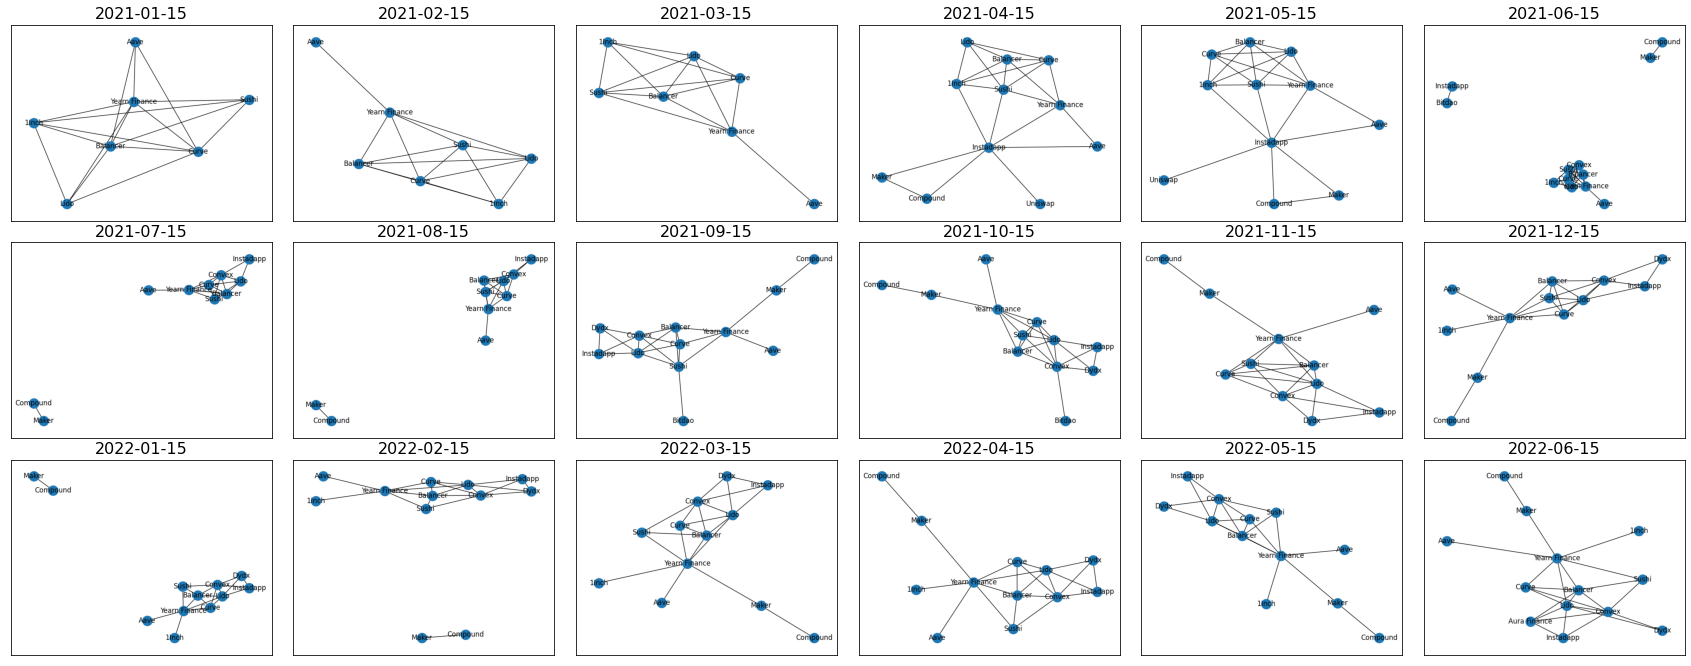

In [4]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid


## progression over time 
fig = plt.figure(figsize=(30, 13))
# fig.suptitle("Token-Projections over Time", fontsize=20, y=0.75)  # Add an overall title

# Add a short description using figtext
# description = """Visualization of Validated Token Projections based on Tokenholders for selected Governance tokens from January 15, 2021, to June 15, 2022."""
# plt.figtext(0.5, 0.65, description, fontsize=20, ha='center')

grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(3, int(len(block_height_to_date_dict)/3)),  # creates 2x2 grid of axes
                 axes_pad=0.3,  # pad between axes in inch.
                 )


for ax, snapshot in zip(grid, block_height_to_date_dict.keys()): 

    path_img = join(path, f'token_projection_output/output_f-none/pics/pic_vNetwork_{snapshot}_none.png')
    im = plt.imread(path_img)
    ax.imshow(im)
    # ax.set_title(f'{snapshot}', fontsize=10)
    ax.set_title(f'{block_height_to_date_dict[snapshot]}', fontsize=16)
    
    # Remove only axis labels (keep tick marks)
    ax.set_xticks([])
    ax.set_yticks([])


# fig.tight_layout()

# Save the figure as an image
output_image_path = "output/progression-output_f-none.png"
plt.savefig(output_image_path)


plt.show()


## Building Adjacency matrices and analysing them 

An adjacency matrix is a mathematical representation of a graph that uses a matrix to describe the connections between nodes in the graph. In this matrix, each row and column represents a node, and the value at the intersection of the row and column represents the weight or strength of the connection between those nodes. If there is no connection between two nodes, the value is typically set to zero.

Combining adjacency matrices from different snapshots allows us to analyze the changes and dynamics of the graph over time. By comparing the adjacency matrices from different time points, we can see how the connections between nodes change, which nodes become more or less connected, and how the overall structure of the graph evolves. This information can help us better understand the behavior of the system represented by the graph and can provide insights into important network phenomena, such as the spread of information or the emergence of communities.

In [14]:
# load snapshots
df_snapshots = pd.read_csv('../assets/snapshot_selection.csv')

# load tokens - act as ground truth 
# df_tokens = pd.read_csv('../assets/df_final_token_selection_20230813.csv')
df_tokens= pd.read_csv('../assets/archive/df_final_token_selection_20221209.csv')
df_addresses = pd.read_csv('../assets/archive/df_final_token_selection_20221209.csv')


### NOTE: YOU NEED TO RE-RUN TOKEN VALIDATION --> REMOVAL OF BITDAO CAUSED THIS.
### ALSO DOUBLE CHECK THAT A) BITDAO IS THE PROBLEM AND NOT AURA !!! 

In [16]:
# remove burner addresses 
known_burner_addresses = ['0x0000000000000000000000000000000000000000',
                        '0x0000000000000000000000000000000000000000',
                        '0x0000000000000000000000000000000000000001',
                        '0x0000000000000000000000000000000000000002',
                        '0x0000000000000000000000000000000000000003',
                        '0x0000000000000000000000000000000000000004',
                        '0x0000000000000000000000000000000000000005',
                        '0x0000000000000000000000000000000000000006',
                        '0x0000000000000000000000000000000000000007',
                        '0x000000000000000000000000000000000000dead']

In [234]:
import requests

def get_ticker(coingecko_id): 
    
    data = requests.get(f'https://api.coingecko.com/api/v3/coins/{coingecko_id}')
    ticker = data.json()['symbol']
    return ticker.upper()
                
df_tokens['symbol'] = df_tokens.coingecko_id.apply(lambda x: get_ticker(x))

df_tokens.replace('ETHDYDX', 'DYDX', inplace=True)


In [225]:
import pandas as pd
from ast import literal_eval
import numpy as np


## one grouping 
adj_matrix_list = [] 
edge_list_doc = {}

for block_height in df_snapshots[df_snapshots['Block Height']>= 11659570]['Block Height']: 


    # load pvalues 
    df_pvalues = pd.read_csv(join(path,f'token_projection_output/output_f-none/pvalues_{block_height}_none.csv'), index_col=[0])
    df_pvalues.combination = df_pvalues.combination.apply(lambda x: literal_eval(x))

    # create empty adj_matrx
    adj_matrix = np.zeros((len(df_tokens), len(df_tokens)))

    edge_list_projection = [] 
    # populate adj_matrix
    for index, row in df_pvalues.iterrows(): 
        
        # get address combination
        token1, token2 = row.combination

        # define index & col     
        t1_ind = df_tokens.loc[df_tokens.address == token1].index[0]
        t2_ind = df_tokens.loc[df_tokens.address == token2].index[0]


        # check if validated 
        if row.m_test_result == True:

            # populate adj matrix
            adj_matrix[t1_ind, t2_ind] = 1
            adj_matrix[t2_ind, t1_ind] = 1

            # projected links 
            edge_list_projection.append(tuple((token1, token2)))

        else: 
            # populate adj matrix
            adj_matrix[t1_ind, t2_ind] = 0   


    # append adj_matrix 
    adj_matrix_list.append(adj_matrix)
    edge_list_doc[block_height] = edge_list_projection

In [226]:
ddf = pd.read_csv(join(path,f"token_balance_lookup_tables_labelled/df_token_balenace_labelled_greater_01pct_bh14967365_v2.csv"), index_col=[0])


def manipulation(df_token_balenace): 
    
    ddf = df_token_balenace.rename(columns={'address_x': 'address'})
    ddf = ddf.rename(columns={'address_x': 'address'})

    # we only consider non-zero at snapshot 
    ddf = ddf[ddf.value > 0]

    ## keys 
    dict_ts = dict(ddf.groupby('token_address').value.sum())
    dict_ts.keys()

    ## define supply 
    ddf['pct_supply'] = int

    ## define supply
    for t in dict_ts.keys(): 

        ddf.loc[ddf.token_address == t, 'pct_supply'] = ddf[ddf.token_address == t].value / dict_ts[t]
    
    
    #  filter latest tokens 
    df_addresses = pd.read_csv('../assets/archive/df_final_token_selection_20221209.csv')
    ddf = ddf[ddf.token_address.isin(df_addresses.address) == True]

    # remove known burner addresses 
    ddf = ddf[ddf.address.isin(known_burner_addresses) == False]
    
    return ddf 

ddf = manipulation(ddf)



In [227]:
## all groupins 

folders = ['output_f-EMOA', 'output_f-IEMOA', 'output_f-none', 'output_f-pcv', 'output_f-other-bridge-vesting-pcv'] #'output_f-IEMOA-EMOA', 'output_f-lp-amm',
filters = ['EMOA', 'IEMOA', 'none', 'pcv', 'other-bridge-vesting-pcv'] #'IEMOA-EMOA', 'lp-amm', 


dict_stack_matrix = {}


for folder, filt in zip(folders, filters): 
    
    adj_matrix_list = [] 
    edge_list_doc = {}

    for block_height in df_snapshots[df_snapshots['Block Height']>= 11659570]['Block Height']: 
        
        # load pvalues 
        df_pvalues = pd.read_csv(join(path,f'token_projection_output/{folder}/pvalues_{block_height}_{filt}.csv'), index_col=[0])
        
        df_pvalues.combination = df_pvalues.combination.apply(lambda x: literal_eval(x))

        # create empty adj_matrx
        adj_matrix = np.zeros((len(df_tokens), len(df_tokens)))

        edge_list_projection = [] 
        # populate adj_matrix
        for index, row in df_pvalues.iterrows(): 

            # get address combination
            token1, token2 = row.combination

            # define index & col     
            t1_ind = df_tokens.loc[df_tokens.address == token1].index[0]
            t2_ind = df_tokens.loc[df_tokens.address == token2].index[0]


            # check if validated 
            if row.m_test_result == True:

                # populate adj matrix
                adj_matrix[t1_ind, t2_ind] = 1
                adj_matrix[t2_ind, t1_ind] = 1

                # projected links 
                edge_list_projection.append(tuple((token1, token2)))

            else: 
                # populate adj matrix
                adj_matrix[t1_ind, t2_ind] = 0   


        # append adj_matrix 
        adj_matrix_list.append(adj_matrix)
        edge_list_doc[block_height] = edge_list_projection
    
    
    stacked_adj_matrix = np.stack(adj_matrix_list, axis=2)
    dict_stack_matrix[folder] = stacked_adj_matrix
    

    

In [228]:
stacked_adj_matrix = np.stack(adj_matrix_list, axis=2)

In [12]:
# ### sample size 

# sample_size_list = []

# for filt in filters: 
    
#     for block_height in df_snapshots[df_snapshots['Block Height']> 11659570]['Block Height']: 
        
#         ddf = pd.read_csv(join(path,f"token_balance_lookup_tables_labelled/df_token_balenace_labelled_greater_01pct_bh{block_height}_v2.csv"), index_col=[0])
        
#         ddf = manipulation(ddf)
        
#         if filt == 'none': 
            
#             sample_size_list.append([filt, block_height, len(ddf.address.unique()), len(ddf.token_address.unique())])
            
#         elif filt == 'other-bridge-vesting-pcv':
            
#             sub_label_list = [    'internal_staking_contracts',    'external_staking_contracts',    'lp_amm',    'lending_borrowing_contract',    'EMOA',    'IEMOA']

#             sample_size_list.append([filt, block_height, len(ddf[ddf.label.isin(sub_label_list) == False].address.unique()), len(ddf.token_address.unique())])
            
#         else: 
        
#             sample_size_list.append([filt, block_height, len(ddf[ddf.label == filt].address.unique()), len(ddf.token_address.unique())])

        
        
# df_sample = pd.DataFrame(sample_size_list)        

In [ ]:
# df_sample['filter'].unique()

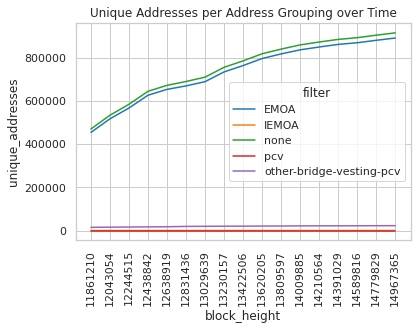

In [290]:
# import seaborn as sns
# import matplotlib.pyplot as plt

# df_sample.columns = ['filter', 'block_height', 'unique_addresses', 'token_addresses']
# df_sample.block_height = df_sample.block_height.astype(str)

# # Set the style of the plot
# sns.set_style("whitegrid")

# # Create a line plot for unique_addresses and token_addresses
# sns.lineplot(x='block_height', y='unique_addresses', hue='filter', data=df_sample)

# # Set the title and axis labels
# plt.title('Unique Addresses per Address Grouping over Time')
# ax.set_xlabel('Block Height')
# ax.set_ylabel('Number of Token Addresses')

# # rotate the x-axis labels
# plt.xticks(rotation=90)

# # save fig 
# # plt.savefig("outputs/poster_presentation/unique_address_over_time.png", dpi=300, bbox_inches='tight')

# # Show the plot
# plt.show()


/tmp/ipykernel_509454/3522060016.py:12: UserWarning:

FixedFormatter should only be used together with FixedLocator



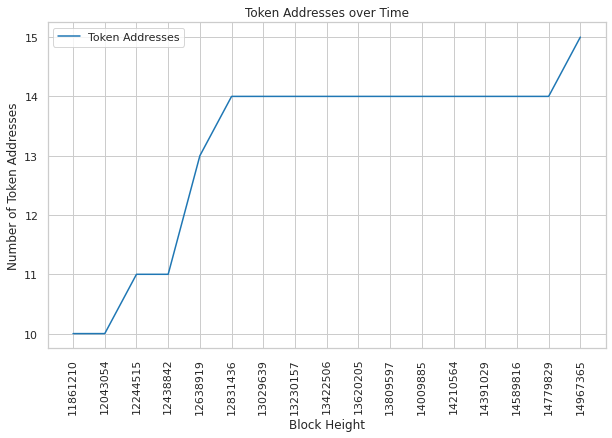

In [287]:
# fig, ax = plt.subplots(figsize=(10, 6))

# # Create the line plot for token addresses
# sns.lineplot(x='block_height', y='token_addresses', data=df_sample[df_sample['filter']=='none'], ax=ax, label='Token Addresses')

# # Set the title and axis labels
# ax.set_title('Token Addresses over Time')
# ax.set_xlabel('Block Height')
# ax.set_ylabel('Number of Token Addresses')

# # Rotate the x-axis labels by 90 degrees
# ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

# # save fig 
# plt.savefig("outputs/poster_presentation/tokens_over_time_address_groupings.png", dpi=300, bbox_inches='tight')

# # Show the plot
# plt.show()

### Frequency of links

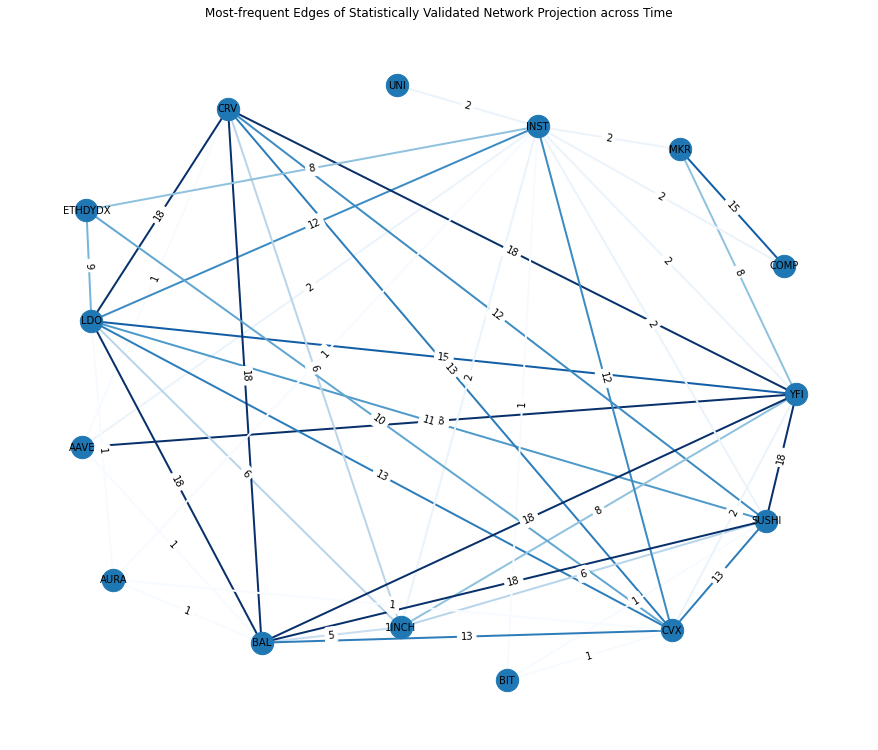

In [229]:
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns

G = nx.from_numpy_array(dict_stack_matrix['output_f-none'].sum(axis=2))

plt.figure(figsize=(12, 10))


# Define positions for the nodes
pos = nx.spring_layout(G, scale=2, k=20)

# Extract edge weights and round them to 0 decimal places
edge_weights = [round(G[u][v]['weight']) for u, v in G.edges()]  # Rounded to 0 decimal places

# Define a colormap for the edge weights using a seaborn palette
cmap = sns.color_palette("Blues", as_cmap=True)

# Create labels for nodes
labels = dict(df_tokens.symbol)

# Draw the graph with edge colors depending on their weights
nx.draw(G, pos, node_size=500, edge_color=edge_weights, edge_cmap=cmap, width=2)

# Edge labels with 0 decimal places
edge_labels = {(u, v): str(round(G[u][v]['weight'])) for u, v in G.edges()}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

# Add node labels to the graph
nx.draw_networkx_labels(G, pos, labels=labels, font_size=10)

# Add a colorbar to the graph
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=min(edge_weights), vmax=max(edge_weights)))
sm.set_array(edge_weights)
# cbar = plt.colorbar(sm, ax=plt.gca())

# Add a title to the graph
plt.title('Most-frequent Edges of Statistically Validated Network Projection across Time')

# If you want to save the figure, uncomment the line below
# plt.savefig('output/Most_frequent_Validated_Network_Graph_over_Time.png', dpi=300, bbox_inches='tight')

plt.show()


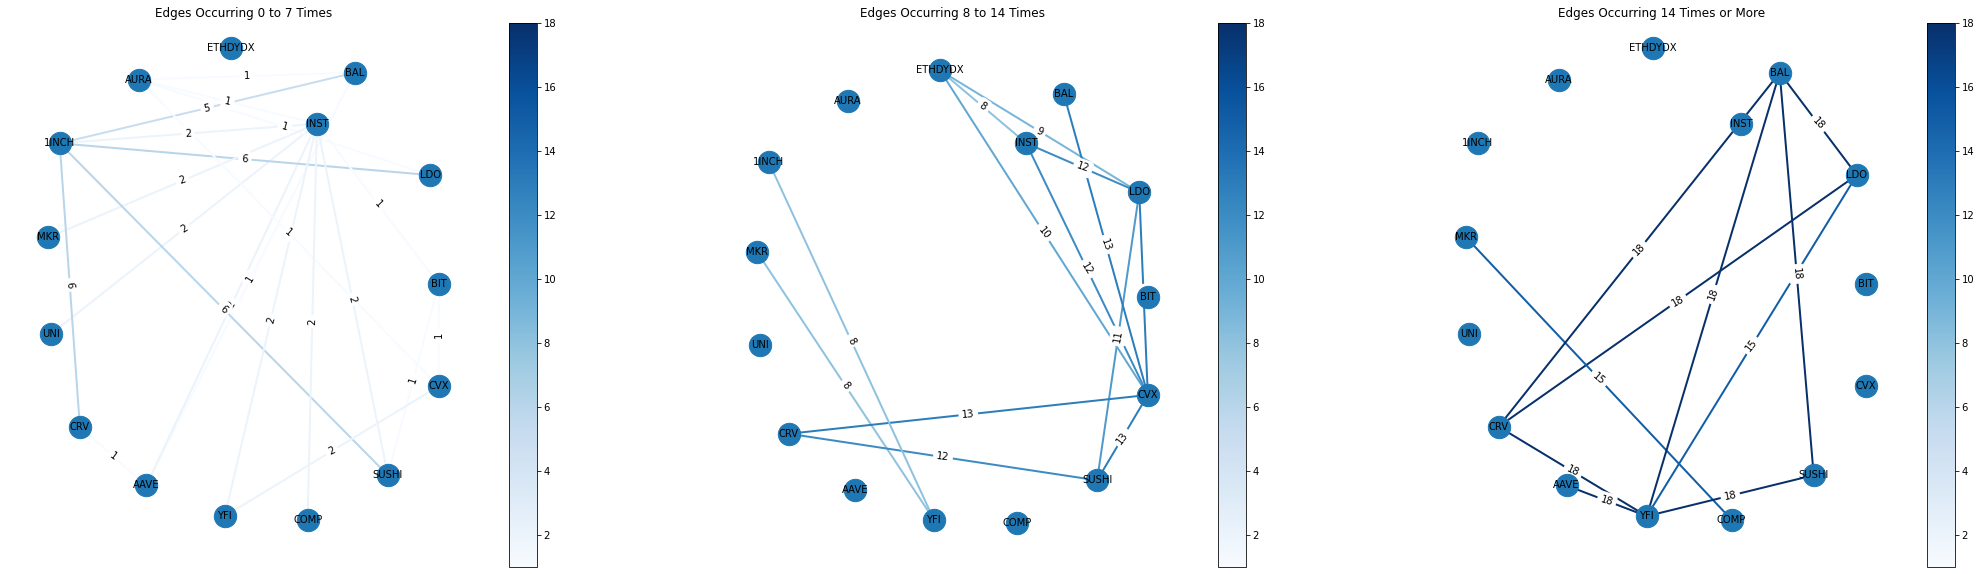

In [170]:
# import networkx as nx
# import matplotlib.pyplot as plt
# import seaborn as sns

# G = nx.from_numpy_array(dict_stack_matrix['output_f-none'].sum(axis=2))

# # Define positions for the nodes
# pos = nx.spring_layout(G, scale=2, k=20)
# labels = dict(df_tokens.symbol)

# # Extract edge weights and round them to 0 decimal places
# edge_weights = [round(G[u][v]['weight']) for u, v in G.edges()]

# # Define a colormap for the edge weights using a seaborn palette
# cmap = sns.color_palette("Blues", as_cmap=True)

# def draw_graph(G, title, ax):
#     # Normalize edge weights to range [0, 1]
#     norm = plt.Normalize(vmin=min(edge_weights), vmax=max(edge_weights))
#     edge_colors = cmap(norm([G[u][v]['weight'] for u, v in G.edges()]))

#     # Draw the graph with edge colors depending on their weights
#     nx.draw(
#         G, pos, 
#         node_size=500, 
#         edge_color=edge_colors, 
#         width=2, 
#         ax=ax
#     )
#     # Edge labels with 0 decimal places
#     edge_labels = {(u, v): str(round(G[u][v]['weight'])) for u, v in G.edges()}
#     nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, ax=ax)

#     # Add node labels to the graph
#     nx.draw_networkx_labels(G, pos, labels=labels, font_size=10, ax=ax)

#     # Add a colorbar to the graph
#     sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=min(edge_weights), vmax=max(edge_weights)))
#     sm.set_array(edge_weights)
#     plt.colorbar(sm, ax=ax)
    
#     # Add a title to the graph
#     ax.set_title(title)

# # Create a new figure with a specified size
# plt.figure(figsize=(36, 10))

# # Create subplots for each graph
# ax1 = plt.subplot(1, 3, 1)  # 1 row, 3 columns, first subplot
# ax2 = plt.subplot(1, 3, 2)  # 1 row, 3 columns, second subplot
# ax3 = plt.subplot(1, 3, 3)  # 1 row, 3 columns, third subplot

# # Draw each graph on a different subplot
# G = nx.from_numpy_array(dict_stack_matrix['output_f-none'].sum(axis=2))  # Reset graph
# edges_to_remove = [(u, v) for u, v in G.edges() if G[u][v]['weight'] >= 7 or G[u][v]['weight'] < 0]
# G.remove_edges_from(edges_to_remove)
# draw_graph(G, 'Edges Occurring 0 to 7 Times', ax1)

# G = nx.from_numpy_array(dict_stack_matrix['output_f-none'].sum(axis=2))  # Reset graph
# edges_to_remove = [(u, v) for u, v in G.edges() if G[u][v]['weight'] >= 14 or G[u][v]['weight'] < 7]
# G.remove_edges_from(edges_to_remove)
# draw_graph(G, 'Edges Occurring 8 to 14 Times', ax2)

# G = nx.from_numpy_array(dict_stack_matrix['output_f-none'].sum(axis=2))  # Reset graph
# edges_to_remove = [(u, v) for u, v in G.edges() if G[u][v]['weight'] < 14]
# G.remove_edges_from(edges_to_remove)
# draw_graph(G, 'Edges Occurring 14 Times or More', ax3)

# # Show the figure with all subplots
# plt.show()


### Pct Frequency of Possible Occurance

In [230]:
# get edge weight sums 

df_connection_frequency = pd.DataFrame([[df_tokens.address.loc[u],df_tokens.address.loc[v], G[u][v]['weight']] for u, v in G.edges()], columns=['node1', 'node2', 'total_occurances'])


token_timestep_dict = {} # address, no of times it occur in all timestpes

# check in how many network projection the link could have theoretically existed
for ind, block_height in enumerate(df_snapshots[df_snapshots['Block Height']>= 11659570]['Block Height']): 
        
        ddf = pd.read_csv(join(path,f"token_balance_lookup_tables_labelled/df_token_balenace_labelled_greater_01pct_bh{block_height}_v2.csv"), index_col=[0])
        
        ddf = manipulation(ddf)
        
        for token in ddf.token_address.unique(): 
            
            if token not in list(token_timestep_dict.keys()):
                             
                # update token_timestep_dict
                
                token_timestep_dict[token] = len(df_snapshots[df_snapshots['Block Height']>= 11659570]['Block Height']) - ind
                
            else:
                pass
                



In [239]:
# Replacing address keys with symbols in the dictionary
token_timestep_dict = {address_to_symbol.get(k, k): v for k, v in token_timestep_dict.items()}

In [240]:
# replace address with ticker symbol in df_connection_frequecny

# Creating a dictionary to map addresses to symbols
address_to_symbol = dict(zip(df_tokens['address'], df_tokens['symbol']))

# Replacing address values with symbols
df_connection_frequency['node1'] = df_connection_frequency['node1'].map(address_to_symbol).fillna(df_connection_frequency['node1'])
df_connection_frequency['node2'] = df_connection_frequency['node2'].map(address_to_symbol).fillna(df_connection_frequency['node2'])

In [241]:
df_connection_frequency['possible_occurances'] = int

# devided existance versus occurances 
for ind, row in df_connection_frequency.iterrows(): 
        
    if token_timestep_dict[row.node1] >= token_timestep_dict[row.node2]:

        df_connection_frequency.loc[ind, 'possible_occurances'] = token_timestep_dict[row.node2]
    
    else:
    
        df_connection_frequency.loc[ind, 'possible_occurances'] = token_timestep_dict[row.node1]

    
    


In [243]:
df_connection_frequency['pct_frequency'] = df_connection_frequency.total_occurances/df_connection_frequency.possible_occurances

In [244]:
df_connection_frequency.replace(df_tokens[['name','address']].set_index('address').to_dict()['name'], inplace=True)

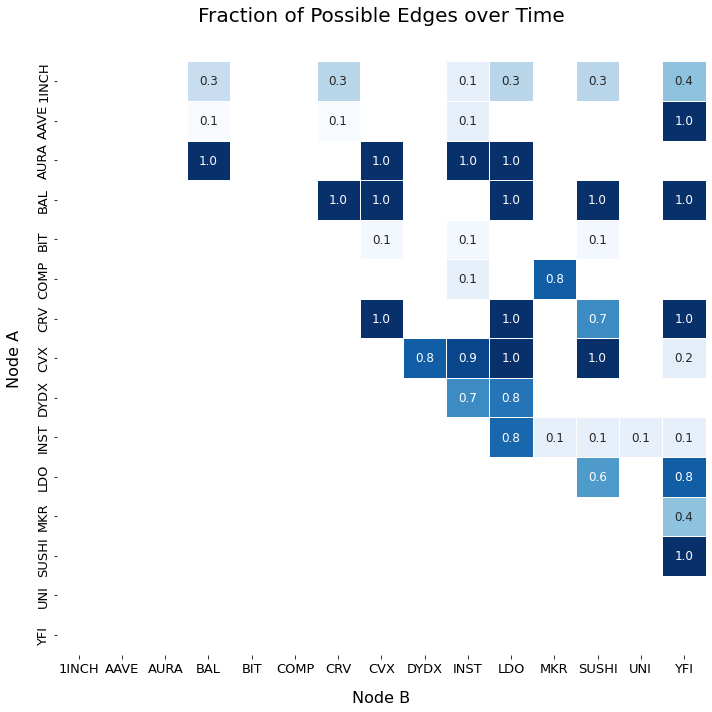

In [359]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Assuming df_connection_frequency is your DataFrame
# df_tokens.replace('ETHDYDX', 'DYDX', inplace=True)

# Get a sorted list of unique node names from both columns
all_nodes = sorted(list(set(df_connection_frequency['node1']) | set(df_connection_frequency['node2'])))

# Pivot the DataFrame to create a matrix of values
matrix = df_connection_frequency.pivot(index='node1', columns='node2', values='pct_frequency')

# Re-index the pivoted matrix using the sorted list
matrix = matrix.reindex(index=all_nodes, columns=all_nodes)

# Symmetrize the matrix
for i in all_nodes:
    for j in all_nodes:
        if pd.isna(matrix.at[i, j]) and i != j:
            matrix.at[i, j] = matrix.at[j, i]

# Create a larger figure for better visibility
plt.figure(figsize=(10, 10))

# Create a mask for the lower triangle
mask = np.tril(np.ones_like(matrix, dtype=bool), k=-1) | np.isnan(matrix)

# Create the heatmap
sns.heatmap(matrix, mask=mask, cmap='Blues', cbar=False, annot=True, fmt='.1f', linewidths=.5, annot_kws={"size": 12})

# Set grid on the background
ax.grid(True, which='both', color='black', linewidth=0.5)


# Adjust title and labels for clarity
plt.title('Fraction of Possible Edges over Time', fontsize=20, pad=40) 
plt.xlabel('Node B', fontsize=16, labelpad=15) 
plt.ylabel('Node A', fontsize=16, labelpad=15) 
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)


# Uncomment below line to save the figure
plt.savefig('output/pct_frequency_of_edges_across_Time.png')

# Show the plot
plt.tight_layout()
plt.show()




In [367]:
sub = df_connection_frequency[(df_connection_frequency.pct_frequency == 1) & (df_connection_frequency.possible_occurances > 1)].copy()
sub

node1  node2  total_occurances  possible_occurances  pct_frequency
3    AAVE    YFI              18.0                   18            1.0
5     LDO    CRV              18.0                   18            1.0
7     LDO    CVX              13.0                   13            1.0
9     LDO    BAL              18.0                   18            1.0
18    CRV    CVX              13.0                   13            1.0
19    CRV    BAL              18.0                   18            1.0
21    CRV    YFI              18.0                   18            1.0
30    CVX    BAL              13.0                   13            1.0
31    CVX  SUSHI              13.0                   13            1.0
37    BAL  SUSHI              18.0                   18            1.0
38    BAL    YFI              18.0                   18            1.0
40  SUSHI    YFI              18.0                   18            1.0

In [ ]:
sub

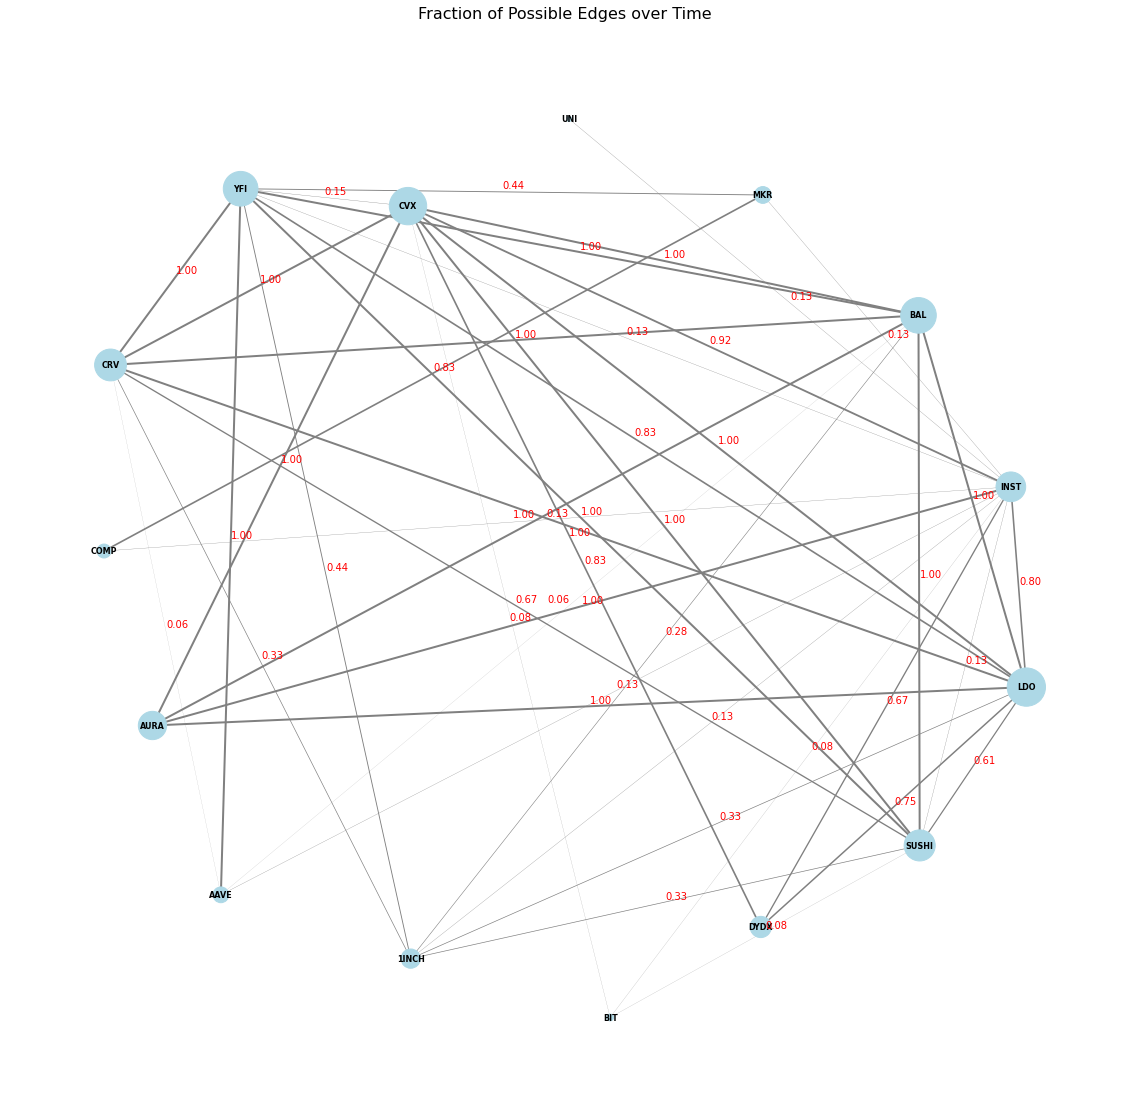

In [331]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from adjustText import adjust_text

# Create a new directed graph from the DataFrame
G = nx.from_pandas_edgelist(df_connection_frequency, 'node1', 'node2', ['pct_frequency'], create_using=nx.Graph())

# Get the weighted degree of each node (sum of edge weights)
weighted_degree = dict(G.degree(weight='pct_frequency'))

# Scale node sizes by weighted degree
node_sizes = [v * 200 for v in weighted_degree.values()]  # Adjust the multiplier to get the size you want

# Get the weight of each edge
weights = nx.get_edge_attributes(G, 'pct_frequency')
edge_weights = [weights[edge] for edge in G.edges()]

# Scale edge widths by weight
edge_widths = [w * 2 for w in edge_weights]  # Adjust the multiplier to get the size you want

# Determine node positions using a spring layout, taking edge weights into account
pos = nx.spring_layout(G, weight='pct_frequency', k=30, seed=42)  # seed for reproducibility

# Draw the graph
plt.figure(figsize=(20, 20))

plt.title('Fraction of Possible Edges over Time', fontsize=16) 

nx.draw(G, pos, with_labels=True, node_size=node_sizes, node_color='lightblue', font_size=8, font_weight='bold',
        edge_color='gray', width=edge_widths,
        edge_cmap=plt.cm.Blues)

# Prepare edge labels
texts = []
for (node1, node2, data) in G.edges(data=True):
    weight = data['pct_frequency']
    x, y = pos[node1]
    x2, y2 = pos[node2]
    label_pos = ((x + x2) / 2, (y + y2) / 2)
    texts.append(plt.text(label_pos[0], label_pos[1], f'{weight:.2f}', color='red'))

# Adjust edge labels to avoid overlap
adjust_text(texts)

# save 
plt.savefig('output/fraction_of_edges_network_across_Time.png')

# Show plot
plt.show()


### Centrality 

1. **Weighted Degree Centrality**: This measure reflects the total strength of connections a node has, taking into account the weight of the edges. Higher values indicate nodes with stronger or more numerous interactions, which could be pivotal in the network's function or structure.

2. **Weighted Betweenness Centrality**: Weighted betweenness centrality identifies nodes that frequently act as bridges along the shortest paths between other nodes, considering the weights of the edges. A higher value indicates a node has a significant influence over the flow of information or whatever the edges represent in the network.

3. **Weighted Eigenvector Centrality**: This measure signifies a node's influence based on the number and quality of its connections, considering the weights of the edges. Nodes with high weighted eigenvector centrality are connected to many nodes who themselves have high centrality.

4. **Weighted K-Core Centrality**: K-core decomposition identifies nodes that are part of larger cliques or tightly interconnected groups within the network. In a weighted version, it considers the strength of connections (weights) while identifying these core structures. Nodes within a high k-core value represent central, well-connected, and structurally cohesive parts of the network.

In [357]:
import networkx as nx

# Assuming G is your graph
weighted_degree_centrality = dict(G.degree(weight='pct_frequency'))

# Assuming G is your graph
weighted_betweenness_centrality = nx.betweenness_centrality(G, weight='pct_frequency')

# 
weighted_eigenvector_centrality = nx.eigenvector_centrality(G, weight='pct_frequency')

# Create a DataFrame
df_centrality = pd.DataFrame({
    'Node': list(G.nodes()),
    'Weighted Degree Centrality': [weighted_degree_centrality.get(node, 0) for node in G.nodes()],
    'Weighted Betweenness Centrality': [betweenness_centrality.get(node, 0) for node in G.nodes()],
    'Weighted Eigenvector Centrality': [weighted_eigenvector_centrality.get(node, 0) for node in G.nodes()]
})

# If you want to set the Node column as the index
df_centrality.set_index('Node', inplace=True)

df_centrality

Weighted Degree Centrality  Weighted Betweenness Centrality  \
Node                                                                 
UNI                      0.133333                         0.000000   
INST                     4.400000                         0.818681   
AAVE                     1.244444                         0.241758   
CRV                      5.055556                         0.000000   
BAL                      6.333333                         0.021978   
YFI                      6.009402                         0.000000   
LDO                      7.327778                         0.000000   
1INCH                    1.855556                         0.120879   
CVX                      6.987179                         0.005495   
DYDX                     2.250000                         0.000000   
SUSHI                    4.821368                         0.000000   
AURA                     4.000000                         0.000000   
MKR                      1.411111                         0.000000   
COMP                     0.966667                         0.000000   
BIT                      0.230769                         0.120879   

       Weighted Eigenvector Centrality  
Node                                    
UNI                           0.005821  
INST                          0.230177  
AAVE                          0.073105  
CRV                           0.342250  
BAL                           0.402401  
YFI                           0.313345  
LDO                           0.422461  
1INCH                         0.121977  
CVX                           0.408558  
DYDX                          0.153788  
SUSHI                         0.319250  
AURA                          0.277620  
MKR                           0.034008  
COMP                          0.011198  
BIT                           0.013978

In [346]:
# import networkx as nx

# def weighted_k_core(G, k, weight='weight'):
#     """
#     Compute the weighted k-core of a graph.

#     Parameters:
#     -----------
#     G : networkx.Graph
#         The input graph.
#     k : float
#         The minimum weighted degree for nodes to be kept.
#     weight : str, optional
#         The name of the edge attribute used as weight.

#     Returns:
#     --------
#     core_subgraph : networkx.Graph
#         The weighted k-core subgraph.
#     """
#     core_subgraph = G.copy()

#     while True:
#         weighted_degrees = {node: sum(data.get(weight, 0) for _, _, data in core_subgraph.edges(node, data=True))
#                             for node in core_subgraph.nodes()}
        
#         to_remove = [node for node, deg in weighted_degrees.items() if deg < k]
#         core_subgraph.remove_nodes_from(to_remove)
#         if not to_remove:
#             break  # Stop if no more nodes to remove

#     return core_subgraph

# # Usage:
# weighted_k_core_subgraph = weighted_k_core(G, k=1, weight='pct_frequency')


In [349]:
def compute_weighted_degree(G, alpha=0.5, weight='weight'):
    """
    Compute the weighted degree of each node in a graph based on the given formula:
    kw_i = alpha * k_i + (1 - alpha) * sum(w_ij), for all j in neighbors(i)

    Parameters:
    -----------
    G : networkx.Graph
        The input graph.
    alpha : float, optional
        The tuning parameter used in the weighted degree formula. Default is 0.5.
    weight : str, optional
        The name of the edge attribute used as weight. Default is 'weight'.

    Returns:
    --------
    weighted_degrees : dict
        A dictionary where keys are nodes and values are the computed weighted degrees.
        
    Implementation Reference: 
    -------------------------
    Wei, B., Liu, J., Wei, D., Gao, C., & Deng, Y. (2015). Weighted k-shell decomposition for
    complex networks based on potential edge weights. Physica A: Statistical Mechanics and its
    Applications, 420, 277-283.
    """
    # Dictionary to hold the weighted degree of each node
    weighted_degrees = {}
    
    for node in G.nodes():
        # Get the degree of the node
        k_i = G.degree(node)
        
        # Get the sum of the weights of the edges connected to the node
        sum_weights = sum(data.get(weight, 1) for _, _, data in G.edges(node, data=True))
        
        # Compute the weighted degree of the node using the formula
        k_w_i = alpha * k_i + (1 - alpha) * sum_weights
        
        # Store the weighted degree in the dictionary
        weighted_degrees[node] = k_w_i
    
    return weighted_degrees

weighted_degrees = compute_weighted_degree(G, alpha=0.5, weight='pct_frequency')

{'UNI': 0.5666666666666667,
 'INST': 8.2,
 'AAVE': 2.6222222222222222,
 'CRV': 6.027777777777778,
 'BAL': 7.166666666666666,
 'YFI': 7.504700854700856,
 'LDO': 8.163888888888888,
 '1INCH': 3.9277777777777776,
 'CVX': 7.9935897435897445,
 'DYDX': 2.625,
 'SUSHI': 6.41068376068376,
 'AURA': 4.0,
 'MKR': 2.2055555555555557,
 'COMP': 1.4833333333333334,
 'BIT': 1.6153846153846154}

In [354]:
import networkx as nx

def weighted_k_core(G, k, alpha=0.5, weight='weight'):
    """
    Compute the weighted k-core of a graph based on the provided weighted degree formula.

    Parameters:
    -----------
    G : networkx.Graph
        The input graph.
    k : float
        The minimum weighted degree for nodes to be kept.
    alpha : float, optional
        The tuning parameter used in the weighted degree formula. Default is 0.5.
    weight : str, optional
        The name of the edge attribute used as weight. Default is 'weight'.

    Returns:
    --------
    core_subgraph : networkx.Graph
        The weighted k-core subgraph.
    """
    # Create a copy of the graph to avoid modifying the original graph
    core_subgraph = G.copy()
    
    while True:
        # Compute the weighted degree of each node
        weighted_degrees = compute_weighted_degree(core_subgraph, alpha, weight)
        
        # Identify nodes to be removed based on the weighted degree
        to_remove = [node for node, deg in weighted_degrees.items() if deg < k]
        
        # If no nodes to remove, the current core is the final core
        if not to_remove:
            break
        
        # Remove nodes from the graph
        core_subgraph.remove_nodes_from(to_remove)
    
    return core_subgraph

# Usage example:
# Assume G is your graph
# G = nx.Graph()  # replace with your graph
# Call the function with k=2.0, alpha=0.5
# core_subgraph = weighted_k_core(G, k=2.0, alpha=0.5, weight='pct_frequency')


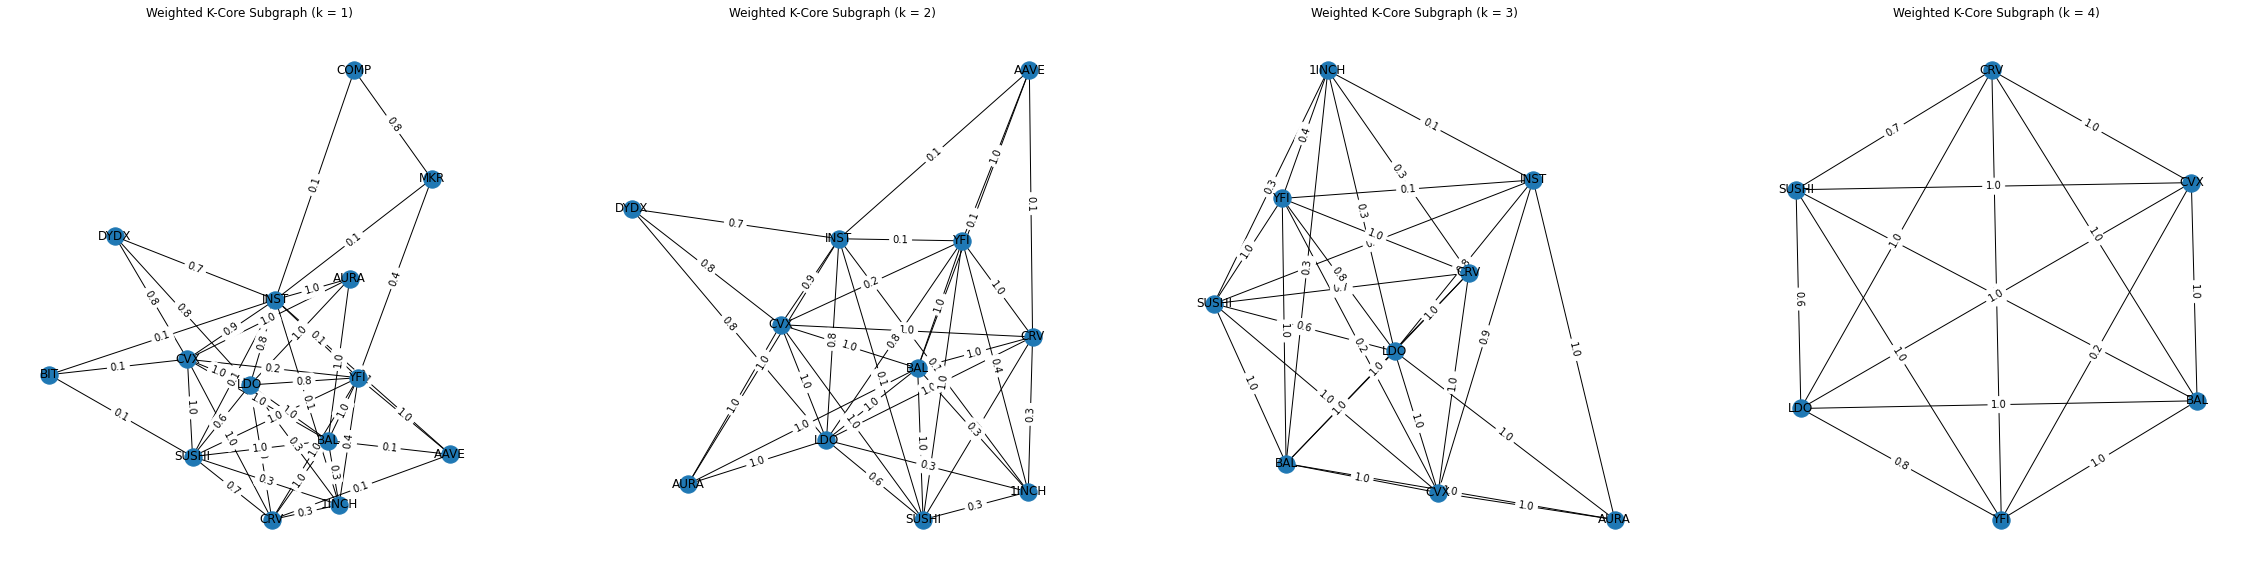

In [371]:
import networkx as nx
import matplotlib.pyplot as plt

k = 1  # starting value of k
k_increment = 1  # increment for k
subgraphs = []  # list to hold the subgraphs

# Generate the subgraphs
while True:
    core_subgraph = weighted_k_core(G, k, alpha=0.5, weight='pct_frequency')
    if not core_subgraph.nodes():
        break  # Stop if no more subgraphs
    subgraphs.append(core_subgraph)
    k += k_increment  # Increment k for the next iteration

# Determine the number of columns for the subplot grid
num_columns = len(subgraphs)

# Create a figure
plt.figure(figsize=(10 * num_columns, 10))

# Plot each subgraph in a separate subplot
for i, core_subgraph in enumerate(subgraphs, start=1):
    ax = plt.subplot(1, num_columns, i)  # 1 row, num_columns columns, index i
    pos = nx.spring_layout(core_subgraph, seed=42)  # for reproducible layouts
    nx.draw(core_subgraph, pos, with_labels=True, ax=ax)
    
    # Draw edge labels
    edge_labels = {(u, v): f'{d["pct_frequency"]:.1f}' for u, v, d in core_subgraph.edges(data=True)}
    nx.draw_networkx_edge_labels(core_subgraph, pos, edge_labels=edge_labels, ax=ax)
    
    ax.set_title(f'Weighted K-Core Subgraph (k = {k_start + (i - 1) * k_increment})')
    
plt.savefig('output/k-core.png')

# Show the plot
plt.show()


In [376]:
print(G.nodes())
print(subgraphs[0].nodes())
print(subgraphs[1].nodes())
print(subgraphs[2].nodes())
print(subgraphs[3].nodes())


['UNI', 'INST', 'AAVE', 'CRV', 'BAL', 'YFI', 'LDO', '1INCH', 'CVX', 'DYDX', 'SUSHI', 'AURA', 'MKR', 'COMP', 'BIT']
['INST', 'AAVE', 'CRV', 'BAL', 'YFI', 'LDO', '1INCH', 'CVX', 'DYDX', 'SUSHI', 'AURA', 'MKR', 'COMP', 'BIT']
['INST', 'AAVE', 'CRV', 'BAL', 'YFI', 'LDO', '1INCH', 'CVX', 'DYDX', 'SUSHI', 'AURA']
['INST', 'CRV', 'BAL', 'YFI', 'LDO', '1INCH', 'CVX', 'SUSHI', 'AURA']
['CRV', 'BAL', 'YFI', 'LDO', 'CVX', 'SUSHI']


## Clique Analysis
Conducting a clique analysis of a network graph involves identifying and analyzing the cliques within the graph. A clique is a subset of nodes in a graph where every node is directly connected to every other node within the subset. 

In [1]:
import pandas as pd
import numpy as np
import networkx as nx 

import matplotlib.pyplot as plt
from ast import literal_eval


from os.path import join
import os

from dotenv import load_dotenv
load_dotenv()  

path = os.environ['PROJECT_PATH']
covalent_key = os.environ['COVALENTHQ_API_KEY']

from dotenv import load_dotenv
load_dotenv()  



/home/user/eisermann/.local/lib/python3.9/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.2' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/home/user/eisermann/.local/lib/python3.9/site-packages/pandas/core/arrays/masked.py:59: UserWarning: Pandas requires version '1.3.2' or newer of 'bottleneck' (version '1.2.1' currently installed).
  from pandas.core import (


True

In [9]:
# load snapshots
df_snapshots = pd.read_csv('../assets/snapshot_selection.csv')

# load tokens - act as ground truth 
# df_tokens = pd.read_csv('../assets/df_final_token_selection_20230813.csv')
df_tokens = pd.read_csv("../assets/df_final_token_selection_20230813.csv")

# load token price data across snapshots
df_token_price = pd.read_csv('../assets/price_table.csv',  index_col=0)

# remove burner addresses 
known_burner_addresses = ['0x0000000000000000000000000000000000000000',
                        '0x0000000000000000000000000000000000000000',
                        '0x0000000000000000000000000000000000000001',
                        '0x0000000000000000000000000000000000000002',
                        '0x0000000000000000000000000000000000000003',
                        '0x0000000000000000000000000000000000000004',
                        '0x0000000000000000000000000000000000000005',
                        '0x0000000000000000000000000000000000000006',
                        '0x0000000000000000000000000000000000000007',
                        '0x000000000000000000000000000000000000dead']



In [3]:
# ## convert blockheight 
# from web3 import Web3, HTTPProvider
# import datetime


# def blockheight_to_date(block_height): 
    

#     # Connect to an Ethereum node (change the URL to the node you want to connect to)
#     web3 = Web3(HTTPProvider('https://mainnet.infura.io/v3/abe2e218809243b1b8e817b562a720d8'))

#     # Retrieve block information
#     block = web3.eth.get_block(block_height)

#     # Extract the timestamp from the block
#     timestamp = block.timestamp

#     # Convert the timestamp to a human-readable date and time
#     return datetime.datetime.fromtimestamp(timestamp).strftime('%Y-%m-%d')  # %H:%M:%S')

In [4]:
# df_snapshots['date'] = df_snapshots['Block Height'].apply(lambda x: blockheight_to_date(x))


In [23]:
df_snapshots

Nr.  Block Height        Date
0     1       7962629  2019-06-15
1     2       8155117  2019-07-15
2     3       8354625  2019-08-15
3     4       8553607  2019-09-15
4     5       8745378  2019-10-15
5     6       8938208  2019-11-15
6     7       9110216  2019-12-15
7     8       9285458  2020-01-15
8     9       9487426  2020-02-15
9    10       9676110  2020-03-15
10   11       9877036  2020-04-15
11   12      10070789  2020-05-15
12   13      10270349  2020-06-15
13   14      10467362  2020-07-15
14   15      10664157  2020-08-15
15   16      10866666  2020-09-15
16   17      11060222  2020-10-15
17   18      11262275  2020-11-15
18   19      11457486  2020-12-15
19   20      11659570  2021-01-15
20   21      11861210  2021-02-15
21   22      12043054  2021-03-15
22   23      12244515  2021-04-15
23   24      12438842  2021-05-15
24   25      12638919  2021-06-15
25   26      12831436  2021-07-15
26   27      13029639  2021-08-15
27   28      13230157  2021-09-15
28   29      13422506  2021-10-15
29   30      13620205  2021-11-15
30   31      13809597  2021-12-15
31   32      14009885  2022-01-15
32   33      14210564  2022-02-15
33   34      14391029  2022-03-15
34   35      14589816  2022-04-15
35   36      14779829  2022-05-15
36   37      14967365  2022-06-15

In [11]:
import requests
import time 

def get_ticker(coingecko_id): 
    print(coingecko_id)
    data = requests.get(f'https://api.coingecko.com/api/v3/coins/{coingecko_id}')
    ticker = data.json()['symbol']
    time.sleep(int(60/4))
    return ticker.upper()

df_tokens['symbol'] = df_tokens.coingecko_id.apply(lambda x: get_ticker(x))

uniswap
aave
lido-dao
maker
curve-dao-token
1inch
convex-finance
compound-governance-token
dydx
balancer
sushi
yearn-finance
instadapp
aura-finance


In [12]:
# replaces ETHDYDX with DYDX
df_tokens.loc[8, 'symbol'] = 'DYDX'

In [13]:
token_lookup = df_tokens[['address','symbol']].set_index('address')['symbol'].to_dict()

### Clique Identification 

In [383]:
from ast import literal_eval
from os.path import join
import networkx as nx
import pandas as pd

# Initialize a dictionary to store the cliques
cliques = {}

for block_height in df_snapshots[df_snapshots['Block Height'] >= 11547458]['Block Height']:
    # Load pvalues
    df_pvalues = pd.read_csv(join(path, f'token_projection_output/output_f-none/pvalues_{block_height}_none.csv'), index_col=[0])
    df_pvalues.combination = df_pvalues.combination.apply(lambda x: literal_eval(x))

    # Filter
    df_pvalues_validated = df_pvalues[df_pvalues.m_test_result == True]

    # Create an empty graph
    G = nx.Graph()
    G.add_edges_from(df_pvalues_validated.combination)
    nx.set_node_attributes(G, token_lookup, 'name')

    # Find all cliques in the graph
    all_cliques = list(nx.find_cliques(G))

    # Create a set to store unique cliques as frozensets
    unique_cliques = set()
    for clique in all_cliques:
        unique_cliques.add(frozenset([G.nodes[node]['name'] for node in clique]))
        
          
    # list all cliques of the given snapshot for analysis     
    for frozenset_clique in unique_cliques:
        
        list(frozenset_clique)
        
    #####
    # [INSERT ANALYSIS METRICS]
    #####
        
    # Convert frozensets back to lists and store in the cliques dictionary
    cliques[f"{block_height}"] = [sorted(list(frozenset_clique)) for frozenset_clique in unique_cliques]

KeyError: 'name'

In [ ]:
clique_counter = {}

for key in cliques.keys():
    
    for c in cliques[key]:
        c = str(c)
        
        if c in clique_counter:
            clique_counter[c] += 1
        else:
            clique_counter[c] = 1


In [6]:
# # Create a histogram
# plt.hist(clique_counter.values(), bins=8, edgecolor='black')  # You can adjust the number of bins
# plt.xlabel('Value')
# plt.ylabel('Frequency')
# plt.title('Histogram of Cliques occuring over Time')
# plt.show()

In [ ]:
presence = {}

for clique in clique_counter.keys():
    presence[clique] = []

    for snapshot in cliques.keys():
        
        if clique in str(cliques[snapshot]):
            presence[clique].append(1)
        else:
            presence[clique].append(0)



In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df_presence = pd.DataFrame(presence).T
df_presence.columns = list(cliques.keys())



# Create the binary chart
fig, ax = plt.subplots(figsize=(10, 8))
im = ax.imshow(df_presence.values, cmap='binary', aspect='auto', interpolation='none')

# Set ticks and labels
ax.set_xticks(np.arange(len(df_presence.columns)))
ax.set_yticks(np.arange(len(df_presence.index)))
ax.set_xticklabels(df_presence.columns, rotation='vertical')
ax.set_yticklabels(df_presence.index, fontsize=8, va='center', linespacing=1.5)  

# Set labels and title
plt.xlabel('Timestamps')
plt.ylabel('Cliques')
plt.title('Clique Presence Over Time')

# Show color bar indicating presence (1) or absence (0)
# cbar = ax.figure.colorbar(im, ax=ax)
# cbar.ax.set_ylabel('Presence', rotation=-90, va="bottom")

# Adjust spacing for vertical axis labels

plt.tight_layout()
plt.show()


In [ ]:
order_cliques = df_presence.index

TO-Do : Come up with summary statistics (one value) that you can add into the chart above heatmap style 

### Wallet Identification (rm)

In [ ]:
# Token price 
maker = df_addresses.address[3]
n_maker = df_addresses.name[3]
compound = df_addresses.address[7]
n_compound = df_addresses.name[7]

In [ ]:
# Get unqiue address between pair
## unique addresses pair 
set1_addresses = ddf[(ddf.token_address == maker)].address.unique()
set2_addresses = ddf[(ddf.token_address == compound)].address.unique()

## overlap between sets
overlap_addresses = set(set1_addresses) & set(set2_addresses)

# To-Do: use addresses to filter out same snapshot for on wallets side 
# modularity/ density --> high = clique is detached from rest/ spread out 

# filter for unique address
ddf_sub = ddf[ddf.address.isin(overlap_addresses)]

# Automatisation & Compartmentalisation

In [14]:
from itertools import combinations


def clique_member_wallets_upper(clique, dataFrame):
    """
    Retrieve unique wallet addresses that hold tokens in at least two communities 
    within the provided clique.

    The function identifies wallets that hold positions (of any size) in 
    at least two distinct token communities that are part of a given token 
    projection clique. 

    Parameters:
    - clique (list): List of Token Smart Contract Addresses that form the clique.
    - dataFrame (pandas.DataFrame): DataFrame containing wallet addresses and their 
      associated tokens.

    Returns:
    - list: List of unique wallet addresses that are part of the token projection clique.

    Notes:
    The function uses combinations to create pairs of tokens from the given clique. 
    For each token pair, it retrieves the set of unique wallet addresses for each token 
    and then determines the intersection of these sets to identify wallets that hold 
    both tokens. All such wallets are considered part of the token projection clique.

    Example:
    If the clique consists of tokens [A, B], the function will find all wallet 
    addresses that hold both token A and token B.
    """
    
    clique_members = []

    # Calculate possible combinations for the given clique 
    for c in combinations(clique, 2):
                
        # Retrieve unique addresses for each token in the pair
        set1_addresses = dataFrame[dataFrame.token_address == c[0]].address.unique()
        set2_addresses = dataFrame[dataFrame.token_address == c[1]].address.unique()

        # Identify overlapping addresses between the two sets
        overlap_addresses_pair = set(set1_addresses) & set(set2_addresses)

        # Accumulate the overlapping addresses
        clique_members += overlap_addresses_pair
        
    return list(set(clique_members))

# x1 = clique_member_wallets_upper(['0x9f8f72aa9304c8b593d555f12ef6589cc3a579a2', '0xc00e94cb662c3520282e6f5717214004a7f26888'], ddf)

In [15]:
from itertools import combinations


def clique_member_wallets_lower(clique, dataFrame):
    
    """
    Retrieve unique wallet addresses that hold ALL tokens in the provided clique.

    The function identifies wallets that possess all tokens within a given token 
    projection clique. These wallets have positions (of any size) in every token 
    community represented by the clique.

    Parameters:
    - clique (list): List of Token Smart Contract Addresses that form the clique.
    - dataFrame (pandas.DataFrame): DataFrame containing wallet addresses and their 
      associated tokens.

    Returns:
    - list: List of unique wallet addresses that hold all tokens in the clique.

    Notes:
    The function starts with a set of all wallet addresses for the first token in the 
    clique. For each subsequent token in the clique, it updates the set to the 
    intersection of the current set and the set of addresses for the current token. 
    This ensures that, by the end, the set only contains addresses that have all tokens 
    in the clique.

    Example:
    If the clique consists of tokens [A, B, C], the function will find all wallet 
    addresses that hold tokens A, B, AND C.
    """

    # Initialize with all wallets that hold the first token in the clique
    full_member_addresses = set(dataFrame[dataFrame.token_address == clique[0]].address.unique())

    # Intersect with wallets of each subsequent token in the clique
    for token in clique[1:]:
        token_addresses = set(dataFrame[dataFrame.token_address == token].address.unique())
        full_member_addresses &= token_addresses

        # Early exit: if no wallets hold all tokens so far, no need to check further
        if not full_member_addresses:
            return []

    return list(set(full_member_addresses))

# x = clique_member_wallets_lower(['0x9f8f72aa9304c8b593d555f12ef6589cc3a579a2', '0xc00e94cb662c3520282e6f5717214004a7f26888'], ddf)

In [16]:
import numpy as np
import pandas as pd

def gini(array):
    """
    Calculate the Gini coefficient of an array representing income or wealth distribution.

    Args:
        array (numpy.ndarray or list): 1D array-like object containing non-negative values.

    Returns:
        float: Gini coefficient value between 0 and 1.
    """
    # Convert input to a NumPy array
    array = np.asarray(array, dtype=float)

    # Check if array is empty
    if len(array) == 0:
        return np.nan

    # Ensure all values are non-negative
    if np.any(array < 0):
        raise ValueError("Input array contains negative values.")

    # Handle the case of a single element
    if len(array) == 1:
        return 0.0

    # Sort the array in ascending order
    array = np.sort(array)

    # Calculate the Gini coefficient
    n = len(array)
    index = np.arange(1, n + 1)
    gini_coefficient = (np.sum((2 * index - n - 1) * array)) / (n * np.sum(array))

    return gini_coefficient

# Example usage:
sub_dataFrame = pd.DataFrame({'value_usd': [10, 20, 30, 40, 50]})
gini_value = gini(sub_dataFrame['value_usd'])
print(f'Gini Coefficient: {gini_value}')


Gini Coefficient: 0.26666666666666666


In [17]:
def analyze_clique(sub_dataFrame, sub_dataFrame_control, dataFrame, clique, token_lookup):
    """
    Analyze the characteristics of a clique of wallets within a given DataFrame.

    Parameters:
    - sub_dataFrame (DataFrame): The DataFrame containing wallet data of given snapshot and a given clique.
    - sub_dataFrame_control (DataFrame): The DataFrame acting as control for subDataFrame containing wallet data of given snapshot and a members of given clique.
    - dataFrame (DataFrame): The DataFrame containing all wallet data of given snapshot.
    - clique (list): The list of tokens or addresses representing the clique.
    - token_lookup (dict): A dictionary to map tokens or addresses to human-readable labels.

    Returns:
    - clique_name (list): Human-readable names of the tokens or addresses in the clique.
    - result (dict): A dictionary containing various metrics and characteristics of the clique.
    - pvalues (dict): A dictionary containing pvalues compared to control.

    """
    
    analysis_result = {} 
    analysis_result_control = {} 
    pvalues = {}
    
    # ====================================================================================== # 
    
    # Metric 1: Descriptive
    
    # MeEtric 1.1: Number of Wallets
    ## Analysis for 1.1
    size_clique = sub_dataFrame.address.nunique()
    size_cliqueC = sub_dataFrame_control.address.nunique()

    ## Logging for 1.1
    analysis_result['size_clique'] = size_clique
    analysis_result_control['size_clique'] = size_cliqueC
    

    # Metric 1.2: Basic Description Presence
    ## Analysis for 1.2
    no_token_communities_snapshot = dataFrame.token_address.nunique()
    no_token_communities_in_clique = len(clique)
    no_token_communities_not_in_clique = no_token_communities_snapshot - no_token_communities_in_clique
    
    no_token_communities_in_cliqueC = len(clique)
    no_token_communities_not_in_cliqueC = no_token_communities_snapshot - no_token_communities_in_cliqueC
    

    # ## logging for 1.2
    # analysis_result['no_communities_clique'] = no_token_communities_in_clique
    # analysis_result['pct_presence'] = no_token_communities_in_clique/ no_token_communities_snapshot #meaningless

    # ====================================================================================== # 
    
    # Metric 2: Metrics around Pct_supply
    
    # Metric 2.0: Total Influence
    ## Analysis for 2.0 
    normalised_pct_supply = sub_dataFrame.pct_supply.apply(lambda x: x / no_token_communities_snapshot)
    total_influence = normalised_pct_supply.sum()
    
    ## Validation for 2.0
    normalised_pct_supplyC = sub_dataFrame_control.pct_supply.apply(lambda x: x / no_token_communities_snapshot)
    total_influence_pval = t_test(normalised_pct_supply, normalised_pct_supplyC, alternative='greater')
    
    ## Logging for 2.0
    analysis_result['total_influence'] = total_influence
    analysis_result_control['total_influence'] = normalised_pct_supplyC.sum()
    pvalues['total_influence'] = total_influence_pval

    
    # Metric 2.0.0: Normalised Total Influence Gini Coefficient
    ## Analysis for 2.0.0
    gini_total_influence = gini(normalised_pct_supply)
    gini_total_influenceC = gini(normalised_pct_supplyC)


    ## Validation for 2.0.0
    ### H0: The null hypothesis is that there is no significant difference between the Gini coefficients of the two groups.
    ### H1: Group 1 has a more equal distribution (lower Gini coefficient) than Group 2. 
    gini_total_influence_pval = one_tailed_gini_t_test(normalised_pct_supply, normalised_pct_supplyC, alpha=0.05, direction="lower")
    
    ## Logging for 2.0.0
    analysis_result['gini_total_influence'] = gini_total_influence
    analysis_result_control['gini_total_influence'] = gini_total_influenceC
    pvalues['gini_total_influence'] = gini_total_influence_pval
    

    
    # Metric 2.1: Internal influence
    ## Analysis for 2.1
    normalised_pct_supply_internal = sub_dataFrame[sub_dataFrame.token_address.isin(clique) == True].pct_supply.apply(lambda x: x / no_token_communities_in_clique)
    internal_influence = normalised_pct_supply_internal.sum()
    
    ## Validation for 2.1
    normalised_pct_supply_internalC = sub_dataFrame_control[sub_dataFrame_control.token_address.isin(clique) == True].pct_supply.apply(lambda x: x / no_token_communities_in_cliqueC)
    total_internal_influence_pval = t_test(normalised_pct_supply_internal, normalised_pct_supply_internalC, alternative='greater')
    
    ## Logging for 2.1
    analysis_result['internal_influence'] = internal_influence
    analysis_result_control['internal_influence'] = normalised_pct_supply_internalC.sum()
    pvalues['internal_influence'] = total_internal_influence_pval
    
    

    # Metric 2.1.0: Normalised Internal Influence Gini Coefficient
    ## Analysis for 2.1.0
    gini_internal_influence = gini(normalised_pct_supply_internal)
    gini_internal_influenceC = gini(normalised_pct_supply_internalC)

    
    ## Validation for 2.1.0
    ### H0: The null hypothesis is that there is no significant difference between the Gini coefficients of the two groups.
    ### H1: Group 1 has a more equal distribution (lower Gini coefficient) than Group 2. 
    gini_internal_influence_pval = one_tailed_gini_t_test(normalised_pct_supply_internal, normalised_pct_supply_internalC, alpha=0.05, direction="lower")

    ## Logging for 2.1.0
    analysis_result['gini_internal_influence'] = gini_internal_influence
    analysis_result_control['gini_internal_influence'] = gini_internal_influenceC
    pvalues['gini_internal_influence'] = gini_internal_influence_pval
   
    
    
    # Metric 2.2: External influence
    ## Analysis for 2.2
    normalised_pct_supply_external = sub_dataFrame[sub_dataFrame.token_address.isin(clique) != True].pct_supply.apply(lambda x: x / no_token_communities_not_in_clique)
    external_influence = normalised_pct_supply_external.sum()
    
     ## Validation for 2.2
    normalised_pct_supply_externalC = sub_dataFrame_control[sub_dataFrame_control.token_address.isin(clique) != True].pct_supply.apply(lambda x: x / no_token_communities_in_cliqueC)
    total_external_influence_pval = t_test(normalised_pct_supply_internal, normalised_pct_supply_internalC, alternative='greater')
    
     ## Logging for 2.1
    analysis_result['external_influence'] = external_influence
    analysis_result_control['external_influence'] =normalised_pct_supply_externalC.sum()
    pvalues['external_influence'] = total_external_influence_pval
    
    

    # Metric 2.2.0: Normalised External Gini Coefficient
    ## Analysis for 2.2.0
    gini_external_influence = gini(normalised_pct_supply_external)
    gini_external_influenceC = gini(normalised_pct_supply_externalC)

    ## Validation for 2.2.0
    ### H0: The null hypothesis is that there is no significant difference between the Gini coe fficients of the two groups.
    ### H1: Group 1 has a more equal distribution (lower Gini coefficient) than Group 2. 
    gini_external_influence_pval = one_tailed_gini_t_test(normalised_pct_supply_external, normalised_pct_supply_externalC, alpha=0.05, direction="lower")

    ## Logging for  2.2.0
    analysis_result['gini_external_influence'] = gini_external_influence
    analysis_result_control['gini_external_influence'] = gini_external_influenceC
    pvalues['gini_external_influence'] = gini_external_influence_pval
    
    
    # ====================================================================================== # 

    # Metric 3: Portfolio Value Distribution
    ## Analysis for Metric 3

    # Metric 3.0: Wealth Clique
    ## Analysis for Metric 3.0
    wealth_clique = sub_dataFrame['value_usd'].sum()
    
    ## Validation
    total_wealth_pval = t_test(sub_dataFrame['value_usd'], sub_dataFrame_control['value_usd'], alternative='greater')
    
    ## Logging for Metric 3.0
    analysis_result['wealth_clique'] = wealth_clique
    analysis_result_control['wealth_clique'] = sub_dataFrame_control['value_usd'].sum()
    pvalues['wealth_clique'] = total_wealth_pval
    
    

    # Metric 3.0.0: Gini Coefficient 
    # Calculate and log Gini coefficient for wealth_clique
    gini_wealth_clique = gini(sub_dataFrame['value_usd'])
    gini_wealth_cliqueC = gini(sub_dataFrame_control['value_usd'])

    
    ## Validation for 3.0.0
    ### H0: The null hypothesis is that there is no significant difference between the Gini coefficients of the two groups.
    ### H1: Group 1 has a more equal distribution (lower Gini coefficient) than Group 2. 
    gini_wealth_clique_pval = one_tailed_gini_t_test(sub_dataFrame['value_usd'], sub_dataFrame_control['value_usd'], alpha=0.05, direction="lower")

    ## Logging for Metric 3.0.0
    analysis_result['gini_wealth_clique'] = gini_wealth_clique
    analysis_result_control['gini_wealth_clique'] = gini_wealth_cliqueC
    pvalues['gini_wealth_clique'] = gini_wealth_clique_pval
    
    
    
    # Metric 3.0.1: Median Wealth Level in Clique
    ## Analysis for Metric 3.0.1
    median_wealth_level_clique = sub_dataFrame.groupby('address')['value_usd'].sum().median()
    median_wealth_level_cliqueC = sub_dataFrame_control.groupby('address')['value_usd'].sum().median()

    
    ## Validation for Metric 3.0.1
    median_wealth_level_clique_pval = median_t_test(sub_dataFrame.groupby('address')['value_usd'].sum(), 
                                                    sub_dataFrame_control.groupby('address')['value_usd'].sum(), 
                                                    alternative='greater', alpha=0.05)
    
    ## Logging for Metric 3.0.1
    analysis_result['median_wealth_level_clique'] = median_wealth_level_clique
    analysis_result_control['median_wealth_level_clique'] = median_wealth_level_cliqueC
    pvalues['median_wealth_level_clique'] = median_wealth_level_clique_pval
    
    

    # Metric 3.0.2: Median Number of Assets Held in Clique
    ## Analysis for Metric 3.0.2
    median_no_assets_clique = sub_dataFrame.groupby('address')['token_address'].count().median()
    median_no_assets_cliqueC = sub_dataFrame_control.groupby('address')['token_address'].count().median()

    
    ## Validation for Metric 3.0.2
    median_no_assets_clique_pval = median_t_test(sub_dataFrame.groupby('address')['token_address'].count(), 
                                                 sub_dataFrame_control.groupby('address')['token_address'].count(), 
                                                 alternative='greater', alpha=0.05)
    
    ## Logging for Metric 3.0.2
    analysis_result['median_no_assets_clique'] = median_no_assets_clique
    analysis_result_control['median_no_assets_clique'] = median_no_assets_cliqueC
    pvalues['median_no_assets_clique'] = median_no_assets_clique_pval
    
    
    # ====================================================================================== # 


    # Metric 4: Labels
    ## Analysis for Metric 4
    sub_dataFrame.label.fillna('other_contracts', inplace=True)
    sub_dataFrame_control.label.fillna('other_contracts', inplace=True)
    
    # Metric 4.0: Max Influence Label
    max_influence_label = sub_dataFrame.groupby(['label'])['pct_supply'].sum().idxmax()
    max_influence_labelC = sub_dataFrame_control.groupby(['label'])['pct_supply'].sum().idxmax()

    ## Analysis for Metric 4.0
    max_influence_label_value = sub_dataFrame.groupby(['label'])['pct_supply'].sum().max()/ no_token_communities_snapshot
    max_influence_label_valueC = sub_dataFrame_control.groupby(['label'])['pct_supply'].sum().max()/ no_token_communities_snapshot

    
    ## Validation for Metric 4.0 
    sample = sub_dataFrame[sub_dataFrame.label==max_influence_label].pct_supply
    control = sub_dataFrame_control[sub_dataFrame_control.label==max_influence_label].pct_supply
    
    ## Logging for Metric 4.0
    analysis_result['max_influence_label'] = (str(max_influence_label), max_influence_label_value)
    analysis_result_control['max_influence_label'] = (str(max_influence_labelC), max_influence_label_valueC)
    pvalues['max_influence_label'] = t_test(sample, control, alternative='greater')

    
    ###
    # TO-DO: 
    # Add in validation 
    # Add in max label internal influence 
    # Add in max label external influence
    
    # ====================================================================================== # 


    # Add more analysis metrics as needed...
    

    # ====================================================================================== # 


    # Human readable Clique
    clique_name = [token_lookup[i] for i in clique]

    return clique_name, analysis_result, analysis_result_control, pvalues


In [18]:
import scipy.stats as stats

def t_test(sample_data, control_data, alternative='greater'): 
    
    # Test applicability of t-test
    
    ### Independence: The data in both groups should be independent of each other. - True 
    
    if len(sample_data) < 15 or len(control_data) < 15: 
        print('Insufficient Sample Size to ensure statistical validitiy of t-test') 
        return 1
    
    elif len(sample_data) < 50 or len(control_data) < 50: 
    # Only test if sufficiently large sample size (typically greater than 30-40 observations per group) 
    # the central limit theorem often comes into play.
    
        ### Normality: The data in each group should follow a roughly normal distribution.
        _, p_value = stats.shapiro(sample_data)
        _, p_value_control = stats.shapiro(control_data)

        if p_value < 0.05 or p_value_control < 0.05: 

            print(f"Significantly deviates from a normal distribution: Sample: {p_value} || Control: {p_value_control}") 
            return 1

        ### Homogeneity of Variances: The variances in both groups should be approximately equal. You can check this using statistical tests like Levene's test or by visual inspection of boxplots.
        _, p_value = stats.levene(sample_data, control_data)

        if p_value < 0.05: 

            print(f"The variances are not approximately equal: Sample: {p_value} || Control: {p_value_control}") 
            return 1
        
    
    # Apply t-test 
    ### For all metrics we expect 
    
    # Perform the one-sided t-test
    _, p_value = stats.ttest_ind(sample_data, control_data, alternative=alternative)
    return p_value

sample_data = [25, 28, 30, 32, 35, 38, 40]
control_data = [20, 22, 24, 27, 30, 32, 34]
t_test(sample_data, control_data, alternative='greater') 


Insufficient Sample Size to ensure statistical validitiy of t-test


1

In [19]:
import scipy.stats as stats
import numpy as np

def one_tailed_gini_t_test(group1_data, group2_data, alpha=0.05, direction="lower"):
    """
    Perform a one-tailed t-test to compare Gini coefficients between two groups, testing the hypothesis that Group 1 has a more equal distribution than Group 2.

    Parameters:
    - group1_data: List or array containing data for the first group.
    - group2_data: List or array containing data for the second group.
    - alpha: Significance level (default is 0.05).
    - direction: Direction of the test ("lower" for lower Gini coefficient in Group 1, "higher" for higher Gini coefficient in Group 1).

    Returns:
    - t_statistic: The t-statistic for the t-test.
    - p_value: The one-tailed p-value for the t-test.
    - significant: A boolean indicating whether the difference is statistically significant.
    """
    
    if len(group1_data) < 15 or len(group2_data) < 15: 
        # print('Insufficient Sample Size to ensure statistical validitiy of t-test') 
        return np.nan
    
    # Calculate Gini coefficients for each group
    gini_group1 = gini(group1_data)
    gini_group2 = gini(group2_data)

    # Sample sizes for each group
    n_group1 = len(group1_data)
    n_group2 = len(group2_data)

    # Calculate the standard errors for each group
    se_group1 = (1 / (2 * n_group1)) ** 0.5
    se_group2 = (1 / (2 * n_group2)) ** 0.5

    # Calculate the t-statistic
    t_statistic = (gini_group1 - gini_group2) / ((se_group1 ** 2 / n_group1) + (se_group2 ** 2 / n_group2)) ** 0.5

    # Calculate the degrees of freedom
    degrees_of_freedom = n_group1 + n_group2 - 2  # Explanation: (n1 + n2 - 2) degrees of freedom for the t-test

    # Calculate the one-tailed p-value based on the specified direction
    if direction == "lower":
        p_value = stats.t.cdf(t_statistic, df=degrees_of_freedom)
    elif direction == "higher":
        p_value = 1 - stats.t.cdf(t_statistic, df=degrees_of_freedom)
    else:
        raise ValueError("Direction must be 'lower' or 'higher'.")

    # Determine if the result is statistically significant
    significant = p_value < alpha

    return p_value

# Example usage:
group1_data = np.array([100, 200, 300, 400, 500])
group2_data = np.array([50, 150, 250, 350, 450])
p_val = one_tailed_gini_t_test(group1_data, group2_data, direction="lower")
print("One-Tailed P-Value:", p_val)


One-Tailed P-Value: nan


In [20]:
import scipy.stats as stats

def median_t_test(group1_data, group2_data, alternative='greater', alpha=0.05):
    """
    Perform a Mann-Whitney U test (t-test for the median) to compare medians between two groups.

    Parameters:
    - group1_data: List or array containing data for the first group.
    - group2_data: List or array containing data for the second group.
    - alpha: Significance level (default is 0.05).

    Returns:
    - u_statistic: The Mann-Whitney U statistic.
    - p_value: The two-tailed p-value for the test.
    - significant: A boolean indicating whether the difference is statistically significant.
    """
    if len(sample_data) < 15: 
        # print('Insufficient Sample Size to ensure statistical validitiy of t-test') 
        return 1
    
    # Perform Mann-Whitney U test
    _, p_value = stats.mannwhitneyu(group1_data, group2_data, alternative=alternative)

    return p_value

# Example usage:
group1_data = [10, 20, 30, 40, 50]
group2_data = [5, 15, 25, 35, 45]
p_value = median_t_test(group1_data, group2_data)
print("Two-Tailed P-Value:", p_value)


Two-Tailed P-Value: 1


In [21]:
def pval_to_significance(pval):
    """
    Convert a p-value into a significance symbol based on certain conditions.

    Parameters:
    - pval: The p-value to be converted.

    Returns:
    - significance_symbol: The significance symbol ('***', '**', '*', or '') based on the p-value.
    """
    if pval < 0.01:
        significance_symbol = '***'
    elif pval < 0.05:
        significance_symbol = '**'
    elif pval < 0.1:
        significance_symbol = '*'
    else:
        significance_symbol = ''
    
    return significance_symbol

# Example usage:
p_value = 0.0010
significance = pval_to_significance(p_value)
print(f"p-value: {p_value}, Significance: {significance}")


p-value: 0.001, Significance: ***


In [22]:
from ast import literal_eval
from os.path import join
import networkx as nx
import pandas as pd
import itertools 
import random
import datetime

# Initialize a dictionary to store the cliques
cliques = {
            'upper_bound': {'sample': {},'control': {}, 'pvalues': {}}, 
            'lower_bound': {'sample': {},'control': {}, 'pvalues': {}}       
            }

for _, row in df_snapshots[df_snapshots['Block Height'] > 11547458].iterrows():
    
    snapshot_date = row['Date']
    block_height = row['Block Height']
    
    print(f"Snapshot for Block Height: {block_height} - {datetime.datetime.now()}")

    ### LOAD DATA 
    
    ### TO-DO: COMPARTMENTALISE
    
    #### SNAPSHOT DATA
    # Load data
    ddf = pd.read_csv(join(path, f"token_balance_lookup_tables_labelled/df_token_balenace_labelled_greater_01pct_bh{block_height}_v2.csv"))
    ddf = ddf.rename(columns={'address_x': 'address'})
    ddf = ddf[ddf.value > 0]
    ddf = ddf[ddf.token_address.isin(df_tokens.address)]
    ddf = ddf[~ddf.address.isin(known_burner_addresses)]
    
    # supply 
    dict_ts = dict(ddf.groupby('token_address').value.sum())
    ddf['pct_supply'] = 0
    for t in dict_ts.keys(): 
        ddf.loc[ddf.token_address == t, 'pct_supply'] = ddf[ddf.token_address == t].value / dict_ts[t]
    ddf = ddf[ddf.pct_supply > 0.000005] 
    
    # portfolio price 
    ddf['contract_decimals'] = int
    ddf['token_price_usd'] = float

    for contract_address in ddf.token_address.unique(): 

        token_price = df_token_price.loc[contract_address, str(block_height)]
        ddf.loc[ddf.token_address == contract_address, 'token_price_usd'] = token_price


    ddf['value_usd'] = (ddf['value']/(10**18)*ddf['token_price_usd'])
    
    
    
    #### CLIQUE DATA 
    ### TO-DO: COMPARTMENTALISE

    
    # Load pvalues
    df_pvalues = pd.read_csv(join(path, f'token_projection_output/output_f-none/pvalues_{block_height}_none.csv'), index_col=[0])
    df_pvalues.combination = df_pvalues.combination.apply(lambda x: literal_eval(x))

    # Filter
    df_pvalues_validated = df_pvalues[df_pvalues.m_test_result == True]

    # Create an empty graph
    G = nx.Graph()
    G.add_edges_from(df_pvalues_validated.combination)
    nx.set_node_attributes(G, token_lookup, 'name')

    # Find all cliques in the graph
    all_cliques = list(nx.find_cliques(G)) #POTENTIAL ISSUE: NODE ORDER
    
    # Ensure that cliques are always ordered the same 
    # Prevents maker-yearn and yearn-maker being counted separately
    all_cliques = [sorted(i) for i in all_cliques]
        
          
    # list all cliques of the given snapshot for analysis  
    
    
    
    
    for filter_method in ['upper_bound', 'lower_bound']: 
        
        cliques_snapshot = {}
        cliques_snapshot_control = {} 
        cliques_pvalues = {}

    
        for clique in all_cliques:
        
                                                        
            ### Select filter methods
            if filter_method == 'upper_bound':
                clique_members_unique = clique_member_wallets_upper(clique, ddf)
                            
            if filter_method == 'lower_bound':
                clique_members_unique = clique_member_wallets_lower(clique, ddf)
                            

            ### check if there are any clique memners
            ### TO_DO: WHY IS THIS THE CASE? @xm3van: Lower bound critera is strict and filter out all wallet 
            if clique_members_unique == []: 
                
                # cliques_snapshot[str(clique_name)] = {}
                # cliques_snapshot_control[str(clique_name)] = {}
                # cliques_pvalues[str(clique_name)] = {}

                print("Skip")

                pass


            else:

                ## Sample DataFrame
                ddf_sub = ddf[ddf.address.isin(clique_members_unique)].copy()  
                
                ### tokenholder population of the clique
                    # filter 1: token holder
                filter1 = ddf.token_address.isin(clique)
                    # filter 2: Independence for t-test (control cannot have overlap with sample) 
                filter2 = ddf['address'].isin(clique_members_unique) 
                
                relevant_population =  list(ddf[(filter1==True) & (filter2!=True)].address.unique()) 
                
                ## control dataframe 
                random.seed(42) # disable
                control_sample = random.sample(relevant_population, len(clique_members_unique))
                ddf_sub_control = ddf[ddf.address.isin(control_sample)].copy()  

            
                ### ANALYSIS 
                clique_name, results, results_control, pvalues = analyze_clique(ddf_sub, ddf_sub_control, ddf, clique, token_lookup)
        

                cliques_snapshot[str(clique_name)] = results
                cliques_snapshot_control[str(clique_name)] = results_control
                cliques_pvalues[str(clique_name)] = pvalues
            
        # PROBLEM: FIX HOW TO STORE VALUES PER CLIQUE PER SNAPSHOT
        cliques[filter_method]['sample'][snapshot_date] = cliques_snapshot
        cliques[filter_method]['control'][snapshot_date] = cliques_snapshot_control
        cliques[filter_method]['pvalues'][snapshot_date] = cliques_pvalues



Snapshot for Block Height: 11659570 - 2023-12-17 07:38:12.192410
Insufficient Sample Size to ensure statistical validitiy of t-test
Insufficient Sample Size to ensure statistical validitiy of t-test
Insufficient Sample Size to ensure statistical validitiy of t-test
Skip
Significantly deviates from a normal distribution: Sample: 8.467156358437842e-22 || Control: 4.0883474383690555e-09
Significantly deviates from a normal distribution: Sample: 1.2125788036087214e-15 || Control: 5.621841836500607e-08
Significantly deviates from a normal distribution: Sample: 1.2125788036087214e-15 || Control: 5.621841836500607e-08
Significantly deviates from a normal distribution: Sample: 5.181894353867966e-21 || Control: 1.3192433812037052e-08
Insufficient Sample Size to ensure statistical validitiy of t-test
Significantly deviates from a normal distribution: Sample: 1.4543431752341802e-27 || Control: 1.252089252591626e-13
Significantly deviates from a normal distribution: Sample: 4.4118637629273263e-20 

## Create dataframes for each metrics

In [24]:
# Define the list of metric names
metric_names = list(cliques['lower_bound']['sample']['2021-02-15']["""['YFI', 'AAVE']"""].keys())

# Initialize an empty dictionary to store DataFrames for each metric
# metric_dataframes = {'sample': {},'control': {}}

# metric_dataframes = {
#             'upper_bound': {'sample': {},'control': {}}, 
#             'lower_bound': {'sample': {},'control': {}}       
#             }

metric_dataframes = {
            'upper_bound': {'sample': {},'control': {},'pvalues': {}}, 
            'lower_bound': {'sample': {},'control': {},'pvalues': {}}       
            }


# Define a function to create a DataFrame for a given metric
def create_metric_dataframe(metric_name, key1, key2):
    data = []

    # Iterate through cliques and snapshots to collect data for the metric
    for date, snapshot_data in cliques[key1][key2].items():
        for clique_name, metrics in snapshot_data.items():
            
            try:
                data.append({
                'Date': date,
                'Clique Name': clique_name,
                metric_name: metrics[metric_name]
            })
            
            except:
                data.append({
                'Date': date,
                'Clique Name': clique_name,
                metric_name: np.nan
            })
            
            
            

    # Create a DataFrame for the metric
    df_metric = pd.DataFrame(data)

    # Pivot the DataFrame to have snapshots as columns and clique names as rows
    df_metric = df_metric.pivot(index='Clique Name', columns='Date', values=metric_name)

    # Store the DataFrame in the dictionary with a key representing the metric
    metric_dataframes[key1][key2][metric_name] = df_metric

# Call the function for each metric in the list

for method in ['upper_bound', 'lower_bound']:
    
    for group in ['sample', 'control', 'pvalues']:
        
        for metric_name in metric_names:
            
            create_metric_dataframe(metric_name, method, group)



## Figure Generation

In [25]:
FONT_SIZE_LABEL = 18
FONT_SIZE_TICK = 16
FONT_SIZE_TITLE = 24
LINE_SPACING=1.5
FONT_SIZE_VALUE = 12
FIG_SIZE = (16, 10)
COLORS = ['white', 'black']
COLORMAP = 'CMRmap'

### Fig: Size of Clique 

In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from os.path import join

def plot_clique_size_over_time(metric_dataframes, method='upper_bound', group='sample', output_path="output/cliques/", save=True, show=True):
    
    # Define df 
    df = metric_dataframes[method][group]['size_clique']
    
    # common index
    df_index = metric_dataframes['upper_bound']['sample']['size_clique']

    # Find the index of the first occurrence (value > 1) in each column (snapshot)
    first_occurrence_indices = (df_index.T > 1).idxmax()

    # Determine the minimum index (earliest occurrence) for each clique across all snapshots
    min_indices = first_occurrence_indices.groupby(first_occurrence_indices.index).min()

    # Sort the cliques based on their minimum indices to get the desired order
    cliques_order = min_indices.sort_values().index.tolist()

    # Reindex clique size to df_presence 
    df = df.reindex(cliques_order)

    # Create a mask for cells where 'clique_size' is greater than 1
    mask = df.values >= 1

    # Create a custom colormap with gray for values > 1 and white for values <= 1
    cmap = mcolors.ListedColormap(COLORS)

    # Create the binary chart with custom coloring
    fig, ax = plt.subplots(figsize=FIG_SIZE)
    im = ax.imshow(mask, cmap=cmap, aspect='auto', interpolation='none')

    # Set ticks and labels
    ax.set_xticks(np.arange(len(df.columns)))
    ax.set_yticks(np.arange(len(df.index)))
    ax.set_xticklabels(df.columns, rotation='vertical')
    ax.set_yticklabels(df.index, fontsize=FONT_SIZE_TICK, va='center', linespacing=LINE_SPACING)

    # Annotate the chart with 'clique_size' values, skipping 'NaN' values
    for i in range(len(df.index)):
        for j in range(len(df.columns)):
            value = df.values[i, j]
            if not np.isnan(value):
                text = ax.text(j, i, (str(round(value))), ha='center', va='center', color='white', fontsize=FONT_SIZE_VALUE)

    # Set labels and title
    plt.xlabel('Timestamps', fontsize=FONT_SIZE_LABEL)
    plt.ylabel('Cliques', fontsize=FONT_SIZE_LABEL)
    plt.title(f'[{method.upper()}]: Clique Size Over Time', fontsize=FONT_SIZE_TITLE)

    # Adjust spacing for vertical axis labels
    plt.tight_layout()
    
    # Save the plot to the specified output path
    if save == True:
        
        plt.savefig(join(output_path, f'clique_size_{method}_{group}.png'))
        
    if show != True:
        
        plt.close(fig)
    
    else: 
        
        plt.show() 
    

    
plot_clique_size_over_time(metric_dataframes, group='sample', save=False, show=False)

In [55]:
# Define df 
df_upper = metric_dataframes['upper_bound']['sample']['size_clique']
df_lower = metric_dataframes['lower_bound']['sample']['size_clique']

# common index
df_index = metric_dataframes['upper_bound']['sample']['size_clique']

# Find the index of the first occurrence (value > 1) in each column (snapshot)
first_occurrence_indices = (df_index.T > 1).idxmax()

# Determine the minimum index (earliest occurrence) for each clique across all snapshots
min_indices = first_occurrence_indices.groupby(first_occurrence_indices.index).min()

# Sort the cliques based on their minimum indices to get the desired order
cliques_order = min_indices.sort_values().index.tolist()

# Reindex clique size to df_presence 
df_upper = df_upper.reindex(cliques_order)
df_lower = df_lower.reindex(cliques_order)

NameError: name 'patches' is not defined

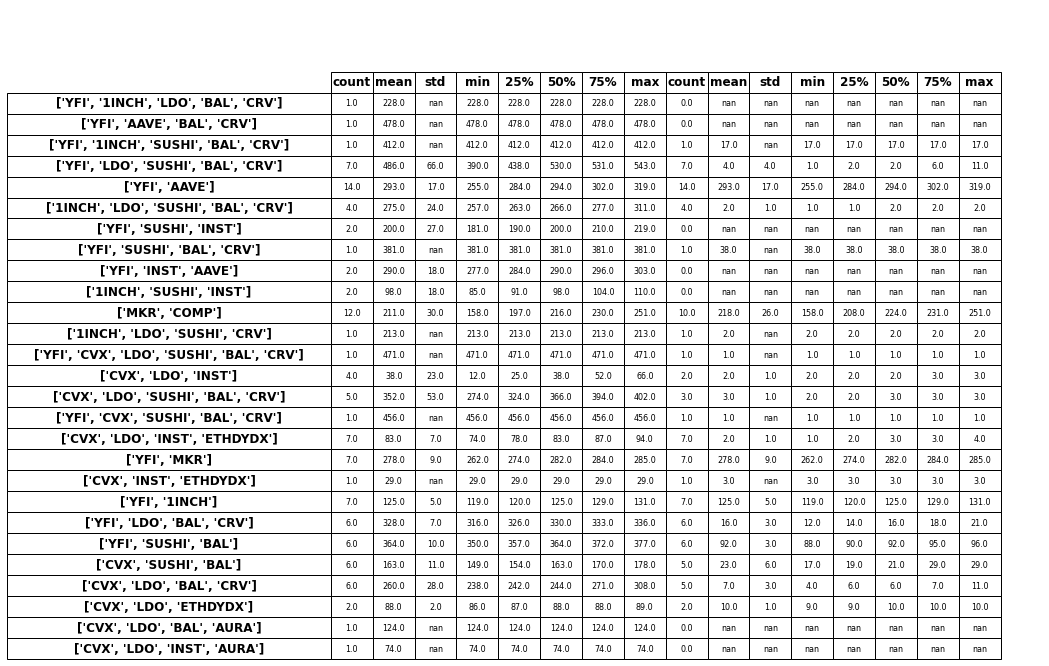

In [56]:
d1 = df_upper.T.describe().T.round(0)
d2 = df_lower.T.describe().T.round(0)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Display using matplotlib
fig, ax = plt.subplots(1, 1, figsize=(15, 12))

# Remove axis
ax.axis('off')

# Adjusted coordinates for tables to be closer
bbox1 = [0.15, 0, 0.4, 0.9]
bbox2 = [0.55, 0, 0.4, 0.9]

# Place the "Upper-bound" table 
table1 = ax.table(cellText=d1.values, colLabels=d1.columns, rowLabels=d1.index, 
                  bbox=bbox1, cellLoc='center', rowLoc='center')
table1.auto_set_font_size(False)
table1.set_fontsize(8)
table1.scale(1,2)

# Bold index rows for table1
for (i, j), cell in table1.get_celld().items():
    if i == 0:
        cell.set_text_props(weight='bold', fontsize=12)
    if j == -1:  # Index column
        cell.set_text_props(weight='bold', fontsize=12)

# Place the "Lower-bound" table
table2 = ax.table(cellText=d2.values, colLabels=d2.columns, 
                  bbox=bbox2, cellLoc='center', rowLoc='center')
table2.auto_set_font_size(False)
table2.set_fontsize(8)
table2.scale(1,2)

# Bold index rows for table1
for (i, j), cell in table2.get_celld().items():
    if i == 0:
        cell.set_text_props(weight='bold', fontsize=12)
        
        
# Add bold bounding boxes around tables
bold_width = 1.2 
rect1 = patches.Rectangle((bbox1[0], bbox1[1]), bbox1[2], bbox1[3]+0.03, linewidth=bold_width, edgecolor='black', facecolor='none')
rect2 = patches.Rectangle((bbox2[0], bbox2[1]), bbox2[2], bbox2[3]+0.03, linewidth=bold_width, edgecolor='black', facecolor='none')
ax.add_patch(rect1)
ax.add_patch(rect2)

# Add centered titles above each box
ax.text(0.35, 0.92, 'Upper-bound', transform=ax.transAxes, va='top', ha='center', fontsize=12, fontweight='bold')
ax.text(0.75, 0.92, 'Lower-bound', transform=ax.transAxes, va='top', ha='center', fontsize=12, fontweight='bold')

plt.tight_layout(pad=0)
# plt.subplots_adjust(left=0, right=0, top=0, bottom=0)
plt.savefig(join("output/cliques/", f'overview_clique_size.png'))

plt.show()


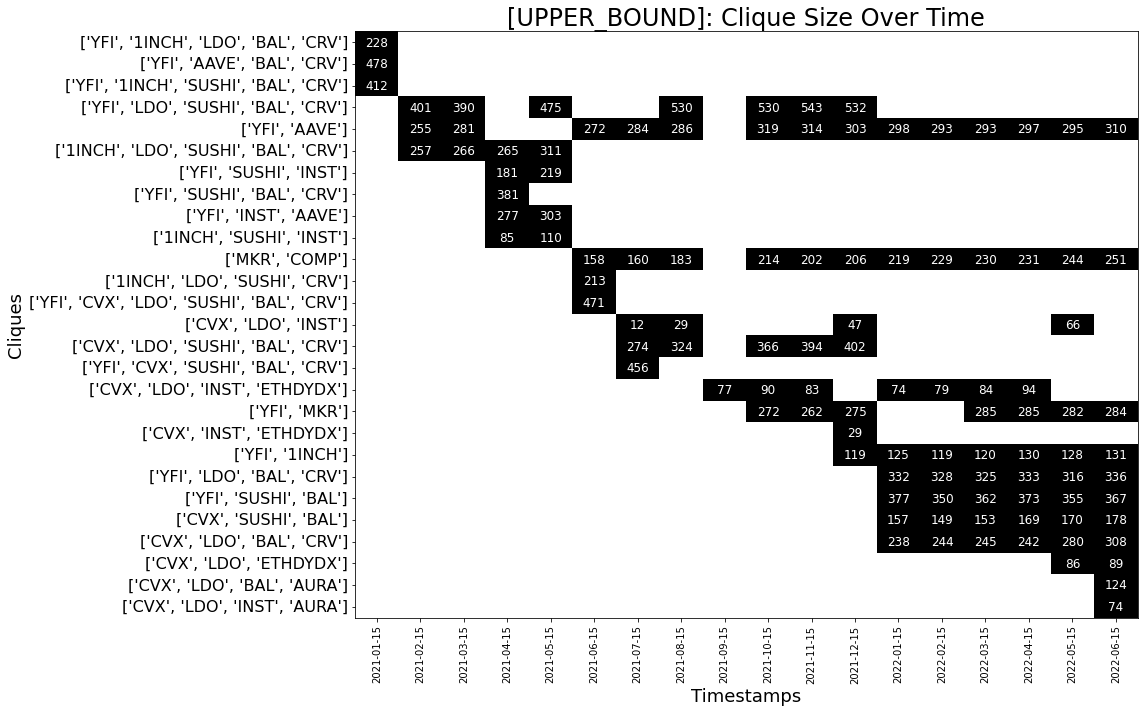

In [57]:
## show upper_bound
plot_clique_size_over_time(metric_dataframes, method='upper_bound', group='sample', save=True, show=True)

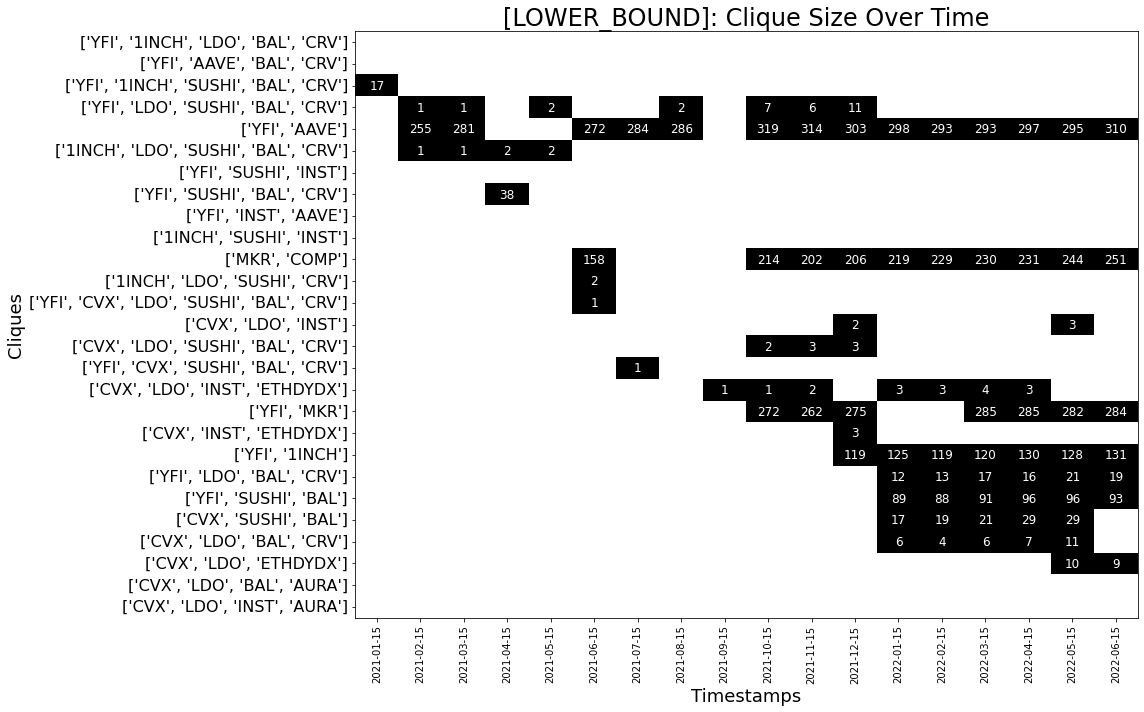

In [58]:
## show lower bound
plot_clique_size_over_time(metric_dataframes,method='lower_bound', group='sample', save=True, show=True)

### Fig:  No. of Communities [Remove]

In [528]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

def plot_community_membership_count(metric_dataframes, method='upper_bound', group='sample', output_path="output/cliques/", save=True, show=True):
    
    # Define df
    df = metric_dataframes[method][group]['no_communities_clique']
    
    # common index 
    df_index = metric_dataframes[method]['sample']['no_communities_clique']

        # Find the index of the first occurrence (value > 1) in each column (snapshot)
    first_occurrence_indices = (df_index.T > 1).idxmax()
        # Determine the minimum index (earliest occurrence) for each clique across all snapshots
    min_indices = first_occurrence_indices.groupby(first_occurrence_indices.index).min()
        # Sort the cliques based on their minimum indices to get the desired order
    cliques_order = min_indices.sort_values().index.tolist()

    # Reindex clique size to df_presence
    df = df.reindex(cliques_order)

    # Create a mask for cells where 'clique_size' is greater than 1
    mask = df.values > 1

    # Create a custom colormap with gray for values > 1 and white for values <= 1
    cmap = mcolors.ListedColormap(['white', 'black'])

    # Create the binary chart with custom coloring
    fig, ax = plt.subplots(figsize=(14, 10))
    im = ax.imshow(mask, cmap=cmap, aspect='auto', interpolation='none')

    # Set ticks and labels
    ax.set_xticks(np.arange(len(df.columns)))
    ax.set_yticks(np.arange(len(df.index)))
    ax.set_xticklabels(df.columns, rotation='vertical')
    ax.set_yticklabels(df.index, fontsize=10, va='center', linespacing=1.5)

    # Annotate the chart with 'clique_size' values, skipping 'NaN' values
    for i in range(len(df.index)):
        for j in range(len(df.columns)):
            value = df.values[i, j]
            if not np.isnan(value):
                text = ax.text(j, i, str(round(value)), ha='center', va='center', color='white', fontsize=10)

    # Set labels and title
    plt.xlabel('Timestamps', fontsize=12)
    plt.ylabel('Cliques', fontsize=12)
    plt.title(f'[{group.upper()}]: Community Membership Count', fontsize=14)

    # Adjust spacing for vertical axis labels
    plt.tight_layout()

    # Save the plot to the specified output path
    if save:
        plt.savefig(join(output_path, f'community_membership_count_{method}_{group}.png'))

    # Display the plot if show is True
    if show != True:
        
        plt.close(fig)
    
    else: 
        
        plt.show() 

# Example usage:
plot_community_membership_count(metric_dataframes, method='lower_bound', group='control', save=False, show=False)


In [ ]:
plot_community_membership_count(metric_dataframes, method='upper_bound', group='sample', save=False, show=True)
plot_community_membership_count(metric_dataframes, method='upper_bound',group='control', save=False, show=True)

In [ ]:
plot_community_membership_count(metric_dataframes, method='lower_bound', group='sample', save=False, show=True)
plot_community_membership_count(metric_dataframes, method='lower_bound',group='control', save=False, show=True)


### Fig: pct_presence [Remove]

In [531]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from os.path import join

def plot_pct_presence(metric_dataframes, method='upper_bound', group='sample', output_path="output/cliques/", save=True, show=True):
    
    # Define df
    df = metric_dataframes[method][group]['pct_presence'] * 100
    
    # common index 
    df_index = metric_dataframes[method]['sample']['pct_presence'] * 100
        # Find the index of the first occurrence (value > 1) in each column (snapshot)
    first_occurrence_indices = (df_index.T > 1).idxmax()
        # Determine the minimum index (earliest occurrence) for each clique across all snapshots
    min_indices = first_occurrence_indices.groupby(first_occurrence_indices.index).min()
        # Sort the cliques based on their minimum indices to get the desired order
    cliques_order = min_indices.sort_values().index.tolist()

    # Reindex clique size to df
    df = df.reindex(cliques_order)

    # Create a custom colormap with grayscale intensity based on metric values
    cmap = plt.get_cmap('CMRmap')  # 'gray_r' reverses the grayscale colormap

    # Create the chart with custom grayscale coloring
    fig, ax = plt.subplots(figsize=(14, 10))
    im = ax.imshow(df.values, cmap=cmap, aspect='auto', interpolation='none', vmin=0, vmax=100)  # Assuming values are in the range [0, 100]

    # Set ticks and labels
    ax.set_xticks(np.arange(len(df.columns)))
    ax.set_yticks(np.arange(len(df.index)))
    ax.set_xticklabels(df.columns, rotation='vertical')
    ax.set_yticklabels(df.index, fontsize=10, va='center', linespacing=1.5)

    # Annotate the chart with metric values, skipping 'NaN' values
    for i in range(len(df.index)):
        for j in range(len(df.columns)):
            value = df.values[i, j]
            if not np.isnan(value):
                text = ax.text(j, i, str(round(value))+'%', ha='center', va='center', color='white', fontsize=10)

    # Set labels and title
    plt.xlabel('Timestamps', fontsize=12)
    plt.ylabel('Cliques', fontsize=12)
    plt.title(f'[{group.upper()}]: Presence in available Tokens (%pct)', fontsize=14)

    # Show color bar indicating metric values with the grayscale colormap
    cbar = ax.figure.colorbar(im, ax=ax)
    cbar.ax.set_ylabel('Metric Value', rotation=-90, va="bottom")

    # Adjust spacing for vertical axis labels
    plt.tight_layout()

    # Save the plot to the specified output path
    if save:
        plt.savefig(join(output_path, f'pct_presence_{method}_{group}.png'))

    # Display the plot if show is True
    if show != True:
        
        plt.close(fig)
    
    else: 
        
        plt.show() 

# Example usage:
plot_pct_presence(metric_dataframes, method='upper_bound', group='control', save=False, show=False)


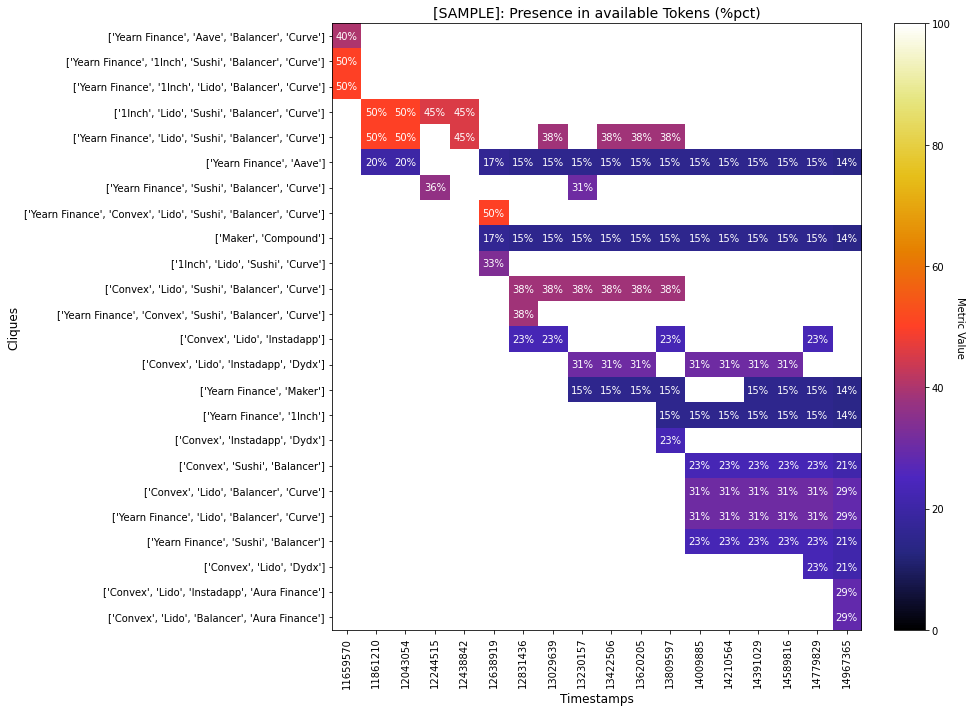

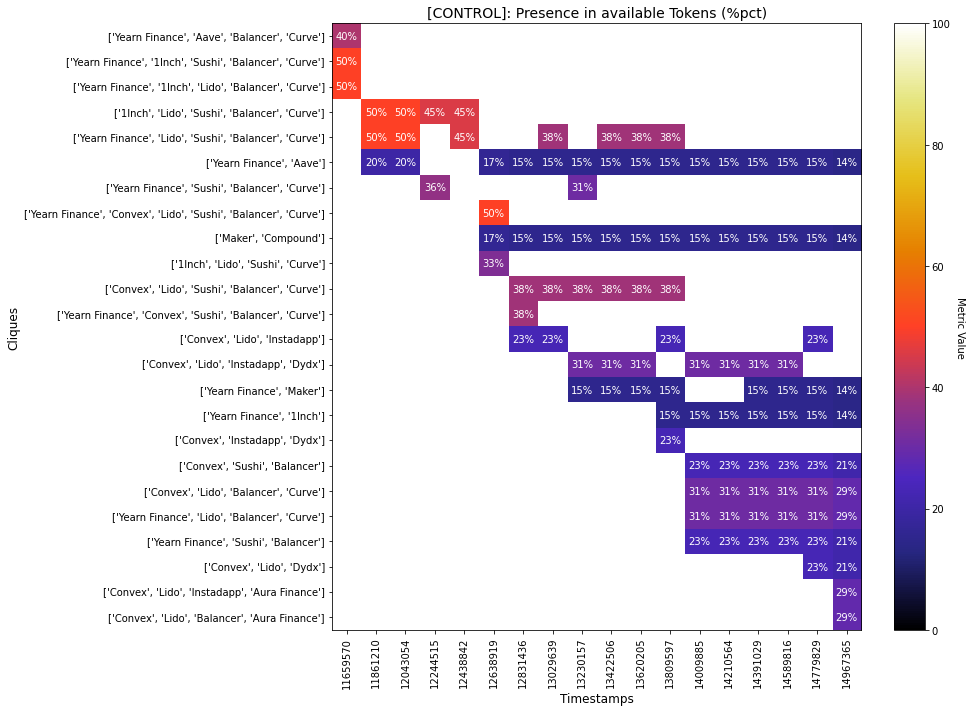

In [532]:
plot_pct_presence(metric_dataframes, method='upper_bound', group='sample', save=False, show=True)
plot_pct_presence(metric_dataframes, method='upper_bound', group='control', save=False, show=True)


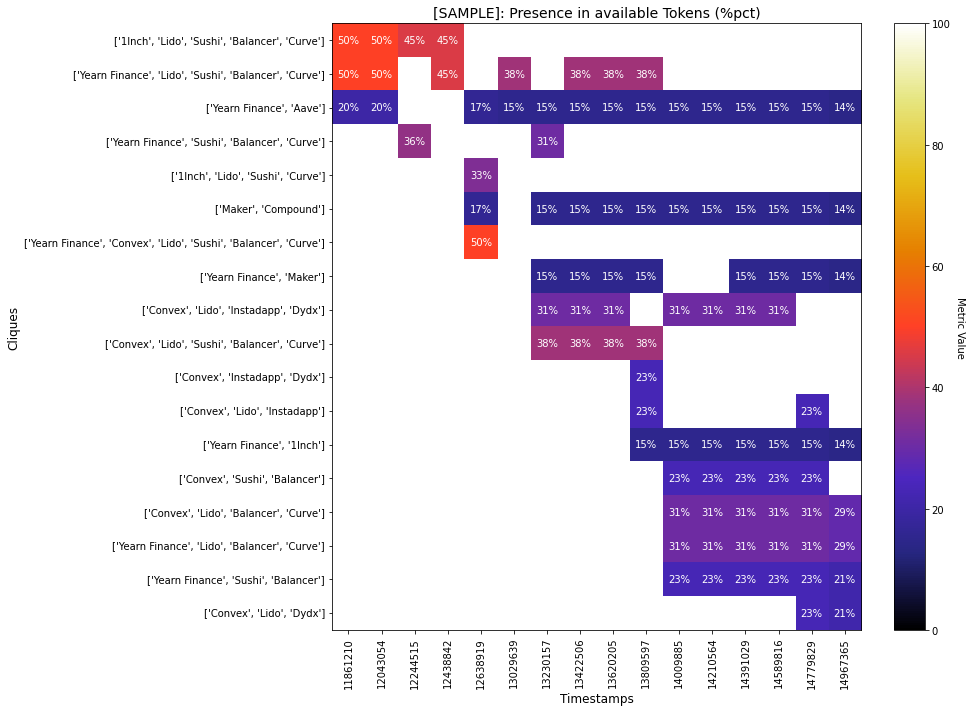

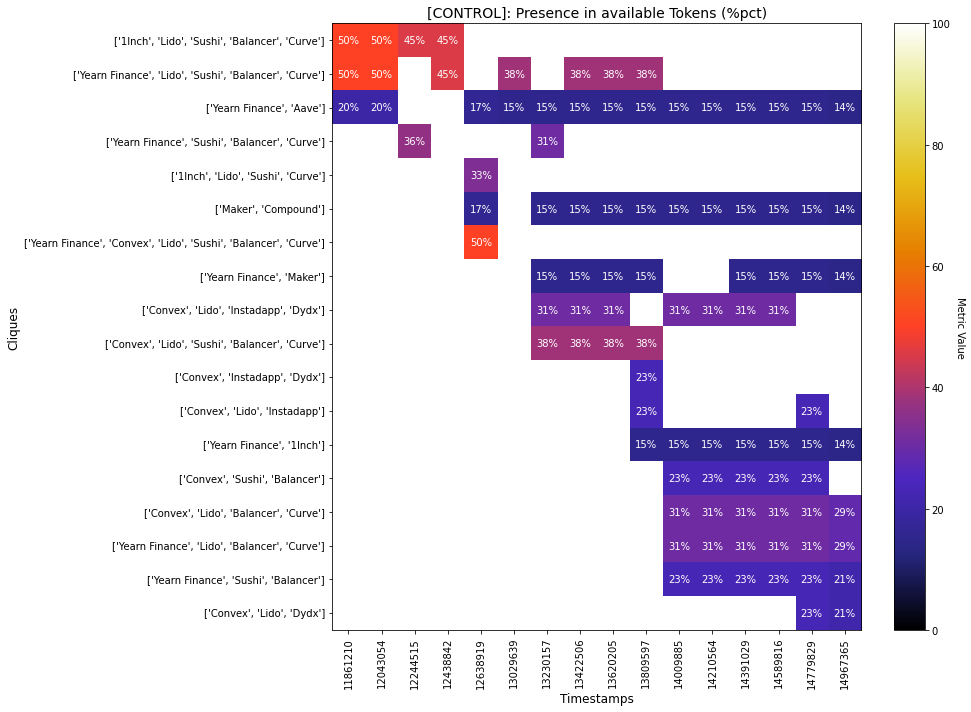

In [533]:
plot_pct_presence(metric_dataframes, method='lower_bound', group='sample', save=False, show=True)
plot_pct_presence(metric_dataframes, method='lower_bound', group='control', save=False, show=True)

### Fig: total_influence

In [59]:
# ## Mid-point figure

# df_upper = metric_dataframes['upper_bound']['sample']['internal_influence'] * 100
# df_lower = metric_dataframes['lower_bound']['sample']['internal_influence'] * 100

# # Assuming df_upper is your existing DataFrame
# df_midpoint = pd.DataFrame(index=df_upper.index, columns=df_upper.columns)

# # df_midpoint.loc["['1INCH', 'LDO', 'SUSHI', 'BAL', 'CRV']", "2021-01-15"]


# for column in df_midpoint.columns:

#     for index in df_midpoint.index:
        
#         # print(f'index: {index} || columns: {column}')
        
#         # Get values 
#         upper = df_upper.loc[index, column]
        
#         ## Note: Lower values are not available for all snapshots
#         try:
#             lower = df_lower.loc[index, column]
              
#         except: 
              
#             lower = np.nan
            
#         # possible scenario 
#         # Upper != np.nan and Lower != np.nan  | value => (upper + lower)/2
#         # Upper != np.nan and Lower == np.nan | value => (upper + 0)/2
#         # Upper == np.nan and Lower != np.nan | ERROR
#         # Upper == np.nan and Lower == np.nan | value => np.nan      
        
#         if np.isnan(lower)==False and np.isnan(upper)==False: 
            
#             # print('Scenario 1: Upper != np.nan and Lower != np.nan  | value => (upper + lower)/2')
              
#             value = (upper +  lower)/2
            
#         elif np.isnan(lower)==True and np.isnan(upper)==False: 
                  
#             # print('Scenario 2:  Upper != np.nan and Lower == np.nan | value => (upper + 0)/2')
#             lower = 0 
#             value = (upper + lower)/2
            
#         elif np.isnan(lower)==False and np.isnan(upper)==True:  
#             # print('Scenario 3: Upper == np.nan and Lower != np.nan | ERROR')
#             print(f"Error: Upper value not available but lower || Upper: {upper}  & lower: {lower}")
#             break
        
#         elif np.isnan(lower)==True and np.isnan(upper)==True:   
#             # print('Scenario 4: Upper == np.nan and Lower == np.nan | value => np.nan')
#             value = np.nan
              
#         else:
#               print('Scenario 5: Not acounted for')
        
#         # populate df_midpoint influence
#         # print(f"U: {upper} | L: {lower} | Mid: {value}")
#         df_midpoint.loc[index, column] = value


In [60]:
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt
# from os.path import join

# def plot_total_influence_midpoint_percentage(df, df_index, output_path="output/cliques/", save=True, show=True):
    
#     # Convert all values in the DataFrame to numeric
#     df = df.apply(pd.to_numeric, errors='coerce')
    
#     # Find the index of the first occurrence (value > 1) in each column (snapshot)
#     first_occurrence_indices = (df_index.T > 1).idxmax()
    
#     # Determine the minimum index (earliest occurrence) for each clique across all snapshots
#     min_indices = first_occurrence_indices.groupby(first_occurrence_indices.index).min()
    
#     # Sort the cliques based on their minimum indices to get the desired order
#     cliques_order = min_indices.sort_values().index.tolist()

#     # Reindex clique size to df
#     df = df.reindex(cliques_order)
    
#     # Create a custom colormap with grayscale intensity based on metric values
#     cmap = plt.get_cmap('CMRmap')

#     # Create the chart with custom grayscale coloring
#     fig, ax = plt.subplots(figsize=(16, 10))  # Adjust the figsize as needed
#     im = ax.imshow(df.values, cmap=cmap, aspect='auto', interpolation='none', vmin=0, vmax=100)  # Assuming values are in the range [0, 100]

#     # Set ticks and labels
#     ax.set_xticks(np.arange(len(df.columns)))
#     ax.set_yticks(np.arange(len(df.index)))
#     ax.set_xticklabels(df.columns, fontsize=16, rotation='vertical')  # Adjust fontsize as needed
#     ax.set_yticklabels(df.index, fontsize=16, va='center', linespacing=1.5)  # Adjust fontsize as needed

#     # Annotate the chart with metric values, displaying all values
#     for i in range(len(df.index)):
#         for j in range(len(df.columns)):
#             value = df.values[i, j]
#             if not np.isnan(value):
#                 text = ax.text(j, i, f'{int(value)}%', ha='center', va='center', color='white', fontsize=12)  # Adjust fontsize as needed

#     # Set labels and title
#     ax.set_xlabel('Timestamps', fontsize=18)  # Adjust fontsize as needed
#     ax.set_ylabel('Cliques', fontsize=18)  # Adjust fontsize as needed
#     ax.set_title('Internal Influence Midpoint', fontsize=24)  # Adjust fontsize as needed

#     # Show color bar indicating metric values with the grayscale colormap
#     cbar = ax.figure.colorbar(im, ax=ax)
#     cbar.ax.set_ylabel('Percentage', fontsize=18, rotation=-90, va="bottom")  # Adjust fontsize as needed
    
#     # Adjust spacing for vertical axis labels
#     plt.tight_layout()

#     # Save the plot to the specified output path
#     if save:
#         plt.savefig(join(output_path, 'internal_influence_percentage_midpoint.png'))

#     # Display the plot if show is True
#     if show:
#         plt.show()
#     else:
#         plt.close(fig)

# # Example usage:
# plot_total_influence_midpoint_percentage(df_midpoint, df_upper, output_path="output/cliques/", save=True, show=True)


In [61]:
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt
# import matplotlib.colors as mcolors
# from os.path import join

# def plot_total_influence_percentage(metric_dataframes, method='lower_bound', group='sample', output_path="output/cliques/", save=True, show=True):
#     # Define df
#     df = metric_dataframes[method][group]['total_influence'] * 100
#     df_pv = metric_dataframes[method]['pvalues']['total_influence']
    
#     # common index 
#     df_index = metric_dataframes[method]['sample']['total_influence'] * 100

#         # Find the index of the first occurrence (value > 1) in each column (snapshot)
#     first_occurrence_indices = (df_index.T > 1).idxmax()
#         # Determine the minimum index (earliest occurrence) for each clique across all snapshots
#     min_indices = first_occurrence_indices.groupby(first_occurrence_indices.index).min()
#         # Sort the cliques based on their minimum indices to get the desired order
#     cliques_order = min_indices.sort_values().index.tolist()

#     # Reindex clique size to df
#     df = df.reindex(cliques_order)
#     df_pv =df_pv.reindex(cliques_order)
    
#     # Create a custom colormap with grayscale intensity based on metric values
#     cmap = plt.get_cmap('CMRmap')  # 'gray_r' reverses the grayscale colormap

#     # Create the chart with custom grayscale coloring
#     fig, ax = plt.subplots(figsize=(35, 30))
#     im = ax.imshow(df.values, cmap=cmap, aspect='auto', interpolation='none', vmin=0, vmax=100)  # Assuming values are in the range [0, 100]

#     # Set ticks and labels
#     ax.set_xticks(np.arange(len(df.columns)))
#     ax.set_yticks(np.arange(len(df.index)))
#     ax.set_xticklabels(df.columns,fontsize=40, rotation='vertical')
#     ax.set_yticklabels(df.index, fontsize=40, va='center', linespacing=1.5)

#     # Annotate the chart with metric values, skipping 'NaN' values
    
#     # Annotate the chart with 'clique_size' values, skipping 'NaN' values
#     for i in range(len(df.index)):
#         for j in range(len(df.columns)):
#             value = df.values[i, j]
#             pval  = df_pv.values[i, j]
#             pval = pval_to_significance(pval)
#             if not np.isnan(value):
#                 text = ax.text(j, i, (f'{pval}\n' + str(round(value))+'%'), ha='center', va='center', color='white', fontsize=28)
#                 # text = ax.text(j, i, (f'{pval}\n' + str(round(value))+'%'), ha='center', va='center', color='white', fontsize=28)

#     # Set labels and title
#     plt.xlabel('Timestamps', fontsize=40)
#     plt.ylabel('Cliques', fontsize=40)
#     plt.title(f'[{method.upper()}]: Total Influence', fontsize=40)

#     # plt.title(f'[{method.upper()}][{group.upper()}]: Internal Influence (%pct)', fontsize=40)

#     # Show color bar indicating metric values with the grayscale colormap
#     cbar = ax.figure.colorbar(im, ax=ax)
#     cbar.ax.set_ylabel('Percentage',fontsize=40, rotation=-90, va="bottom")
    
#     # Add the custom box with significance information
#     plt.text(1.06, -0.1, 'Relative to Control:\n* = 0.1\n** = 0.05\n*** = 0.01', transform=ax.transAxes, fontsize=40, bbox=dict(facecolor='white', alpha=1))

#     # Adjust spacing for vertical axis labels
#     plt.tight_layout()

#     # Save the plot to the specified output path
#     if save:
#         plt.savefig(join(output_path, f'internal_influence_percentage_{method}_{group}.png'))

#     # Display the plot if show is True
#     if show != True:
        
#         plt.close(fig)
    
#     else: 
        
#         plt.show() 

# # Example usage:
# plot_total_influence_percentage(metric_dataframes, method='upper_bound', group='sample', save=False, show=True)

/tmp/ipykernel_434051/2758120174.py:104: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.set_ticklabels([f'{round(val)}%' for val in tick_vals])


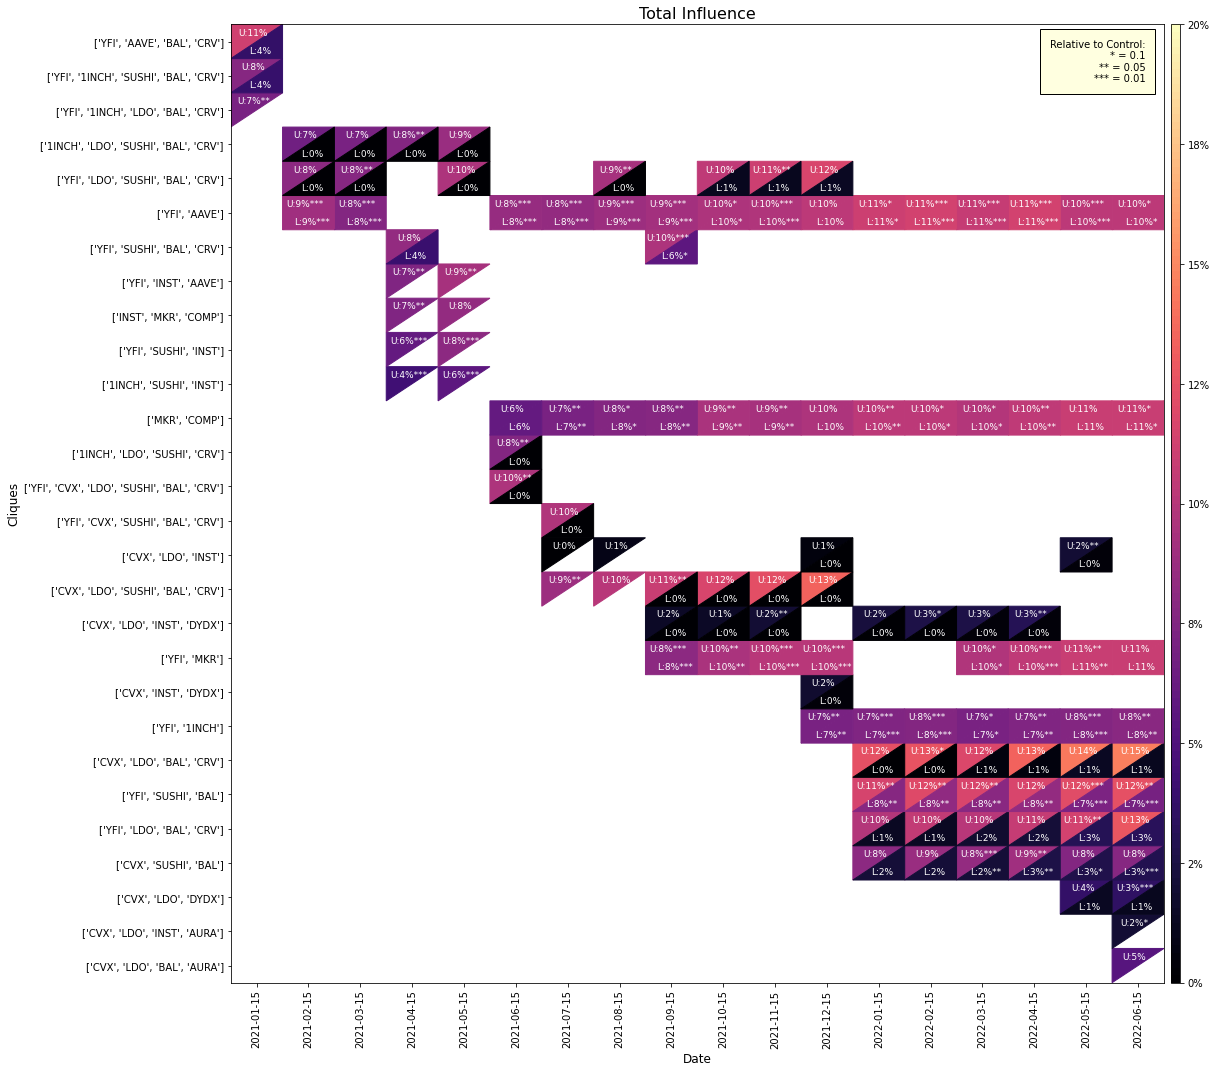

In [62]:
from matplotlib.cm import ScalarMappable
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.patches as patches
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from os.path import join

def plot_total_influence_percentage(metric_dataframes, output_path="output/cliques/", save=True, show=True):

    # Define df
    df_u = metric_dataframes['upper_bound']['sample']['total_influence'] * 100
    df_l = metric_dataframes['lower_bound']['sample']['total_influence'] * 100

    df_pv_u = metric_dataframes['upper_bound']['pvalues']['total_influence']
    df_pv_l = metric_dataframes['lower_bound']['pvalues']['total_influence']
    
    # reindex
    df_index = metric_dataframes['upper_bound']['sample']['total_influence'] * 100

        # Find the index of the first occurrence (value > 1) in each column (snapshot)
    first_occurrence_indices = (df_index.T > 0).idxmax()
        # Determine the minimum index (earliest occurrence) for each clique across all snapshots
    min_indices = first_occurrence_indices.groupby(first_occurrence_indices.index).min()
        # Sort the cliques based on their minimum indices to get the desired order
    cliques_order = min_indices.sort_values().index.tolist()

    # Reindex clique size to df
    df_u = df_u.reindex(cliques_order[::-1])
    df_pv_u =df_pv_u.reindex(cliques_order)

    fig, ax = plt.subplots(figsize=(17, 15))


    # Create colormap
    # cmap = mcolors.LinearSegmentedColormap.from_list("CMRmap", plt.get_cmap("CMRmap")(np.linspace(0, 1, 256)))
    cmap = plt.get_cmap("magma", lut=128)
    norm = mcolors.Normalize(vmin=0, vmax=20)

    cell_width = 1  # as we're not using imshow, we can stick with unit width and height
    cell_height = 1

    for clique in df_u.index:
        for date in df_u.columns:
            value_u = df_u.loc[clique, date]
            pval_u = df_pv_u.loc[clique, date]
            pval_u = pval_to_significance(pval_u)

            try: 
                value_l = df_l.loc[clique, date]
                pval_l = df_pv_l.loc[clique, date]
                pval_l = pval_to_significance(pval_l)
            except: 
                pval_l = ''
                value_l = np.nan

            x_pos = df_u.columns.get_loc(date) * cell_width
            y_pos = df_u.index.get_loc(clique) * cell_height

            # Plotting the triangles
            if not np.isnan(value_u):
                # Calculate triangle vertices for 90-degree rotation
                x1, y1 = x_pos, y_pos + cell_height
                x2, y2 = x_pos, y_pos
                x3, y3 = x_pos + cell_width, y_pos + cell_height

                # Draw triangle
                upper_triangle = patches.Polygon([(x1, y1), (x2, y2), (x3, y3)], closed=True, color=cmap(norm(value_u)), zorder=1)  
                ax.add_patch(upper_triangle)

                # Calculate centroid
                C_x = (x1 + x2 + x3) / 3 + 0.1 #last term manual adjustment 
                C_y = (y1 + y2 + y3) / 3 + 0.1 #last term manual adjustment

                # Place text at centroid
                ax.text(C_x, C_y, f'U:{round(value_u) if not np.isnan(value_u) else ""}%{pval_u}', ha='center', va='center', color='white', fontsize=9)


            if not np.isnan(value_l):
                # Calculate triangle vertices for 90-degree rotation
                x1, y1 = x_pos + cell_width, y_pos
                x2, y2 = x_pos + cell_width, y_pos + cell_height
                x3, y3 = x_pos, y_pos 

                # Draw triangle
                lower_triangle = patches.Polygon([(x1, y1), (x2, y2), (x3, y3)], closed=True, color=cmap(norm(value_l)), zorder=2)
                ax.add_patch(lower_triangle)

                # Calculate centroid
                C_x = (x1 + x2 + x3) / 3 - 0.1 #last term manual adjustment 
                C_y = (y1 + y2 + y3) / 3 - 0.1 # last term manual adjustment 

                # Place text at centroid
                ax.text(C_x, C_y, f'L:{round(value_l) if not np.isnan(value_l) else ""}%{pval_l}', ha='center', va='center', color='white', fontsize=9)
     
    #CBAR 
    ## Adding the colorbar for the colormap
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="1%", pad=0.1)  # '2%' determines the width of the colorbar
    cbar = plt.colorbar(ScalarMappable(norm=norm, cmap=cmap), cax=cax, orientation='vertical')
    ## add pct sign to tick vals of cbar 
    tick_vals = np.array(cbar.get_ticks()) 
    cbar.set_ticklabels([f'{round(val)}%' for val in tick_vals])
    
    # Significance box
    ### Add the custom box with significance information
    plt.text(0.98, 0.985, 'Relative to Control:\n* = 0.1\n** = 0.05\n*** = 0.01', 
         transform=ax.transAxes, fontsize=10, 
         verticalalignment='top', horizontalalignment='right',
         bbox=dict(facecolor='lightyellow', alpha=1, pad=10))

    
    ax.set_xlim(0, len(df_u.columns))
    ax.set_ylim(0, len(df_u.index))
    ax.set_xlabel('Date', size=12)
    ax.set_ylabel('Cliques', size=12)
    ax.set_title('Total Influence', size=16)
    ax.set_xticks(np.arange(len(df_u.columns))+0.5)
    ax.set_xticklabels(df_u.columns, rotation=90, ha='center')
    ax.set_yticks(np.arange(len(df_u.index))+0.5)
    ax.set_yticklabels(df_u.index)
    plt.tight_layout()

    if save:
        plt.savefig(f"{output_path}/total_influence_percentage.png", bbox_inches='tight')

    if show:
        plt.show()

# Assuming metric_dataframes is already defined somewhere in your code
plot_total_influence_percentage(metric_dataframes, save=True, show=True)

In [63]:
# plot_total_influence_percentage(metric_dataframes, method='lower_bound', group='sample', save=True, show=True)

### Fig: gini_total_influence

In [104]:
metric_dataframes['upper_bound']['sample']['gini_total_influence'].T.mean().mean()
# metric_dataframes['lower_bound']['sample']['gini_total_influence'].T.mean().median()

0.8967952040924188

/tmp/ipykernel_434051/838500017.py:100: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.set_ticklabels([f'{round(val,2)}%' for val in tick_vals])


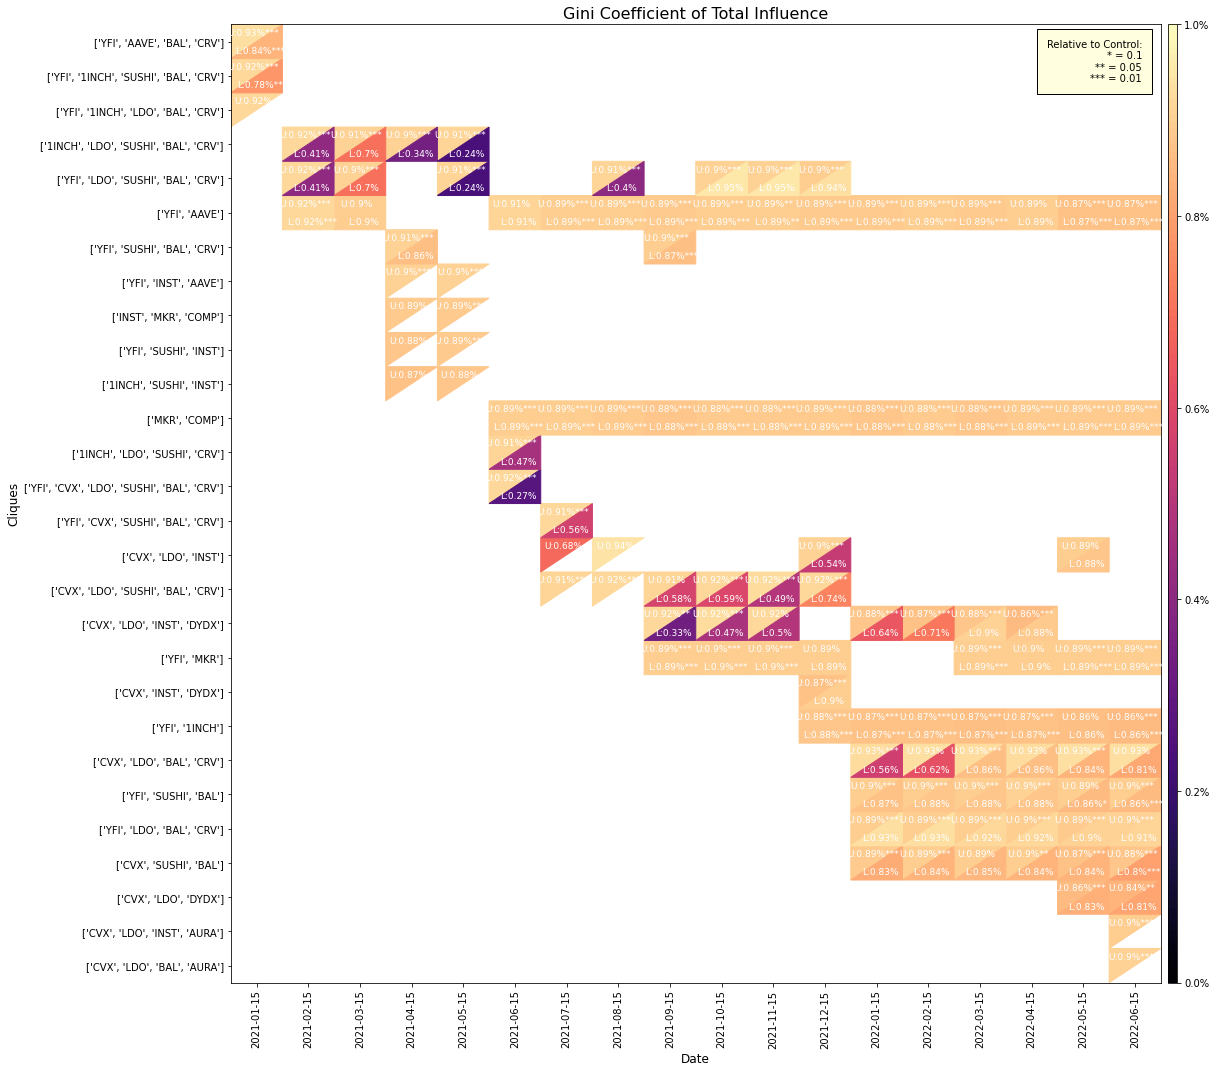

In [64]:
from matplotlib.cm import ScalarMappable
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.patches as patches


def plot_gini_total_influence_percentage(metric_dataframes, output_path="output/cliques/", save=True, show=True):

    # Define df
    df_u = metric_dataframes['upper_bound']['sample']['gini_total_influence'] 
    df_l = metric_dataframes['lower_bound']['sample']['gini_total_influence'] 

    df_pv_u = metric_dataframes['upper_bound']['pvalues']['gini_total_influence']
    df_pv_l = metric_dataframes['lower_bound']['pvalues']['gini_total_influence']
    
    # reindex
    df_index = metric_dataframes['upper_bound']['sample']['gini_total_influence'] 

        # Find the index of the first occurrence (value > 1) in each column (snapshot)
    first_occurrence_indices = (df_index.T > 0).idxmax()
        # Determine the minimum index (earliest occurrence) for each clique across all snapshots
    min_indices = first_occurrence_indices.groupby(first_occurrence_indices.index).min()
        # Sort the cliques based on their minimum indices to get the desired order
    cliques_order = min_indices.sort_values().index.tolist()

    # Reindex clique size to df
    df_u = df_u.reindex(cliques_order[::-1])
    df_pv_u =df_pv_u.reindex(cliques_order)

    fig, ax = plt.subplots(figsize=(17, 15))


    # Create colormap
    # cmap = mcolors.LinearSegmentedColormap.from_list("CMRmap", plt.get_cmap("CMRmap")(np.linspace(0, 1, 256)))
    cmap = plt.get_cmap("magma", lut=128)
    norm = mcolors.Normalize(vmin=0, vmax=1)

    cell_width = 1  # as we're not using imshow, we can stick with unit width and height
    cell_height = 1

    for clique in df_u.index:
        for date in df_u.columns:
            value_u = df_u.loc[clique, date]
            pval_u = df_pv_u.loc[clique, date]
            pval_u = pval_to_significance(pval_u)

            try: 
                value_l = df_l.loc[clique, date]
                pval_l = df_pv_l.loc[clique, date]
                pval_l = pval_to_significance(pval_l)
            except: 
                pval_l = ''
                value_l = np.nan

            x_pos = df_u.columns.get_loc(date) * cell_width
            y_pos = df_u.index.get_loc(clique) * cell_height

            # Plotting the triangles
            if not np.isnan(value_u):
                # Calculate triangle vertices for 90-degree rotation
                x1, y1 = x_pos, y_pos + cell_height
                x2, y2 = x_pos, y_pos
                x3, y3 = x_pos + cell_width, y_pos + cell_height

                # Draw triangle
                upper_triangle = patches.Polygon([(x1, y1), (x2, y2), (x3, y3)], closed=True, color=cmap(norm(value_u)), zorder=1)  
                ax.add_patch(upper_triangle)

                # Calculate centroid
                C_x = (x1 + x2 + x3) / 3 + 0.1 #last term manual adjustment 
                C_y = (y1 + y2 + y3) / 3 + 0.1 #last term manual adjustment

                # Place text at centroid
                ax.text(C_x, C_y, f'U:{round(value_u,2) if not np.isnan(value_u) else ""}%{pval_u}', ha='center', va='center', color='white', fontsize=9)


            if not np.isnan(value_l):
                # Calculate triangle vertices for 90-degree rotation
                x1, y1 = x_pos + cell_width, y_pos
                x2, y2 = x_pos + cell_width, y_pos + cell_height
                x3, y3 = x_pos, y_pos 

                # Draw triangle
                lower_triangle = patches.Polygon([(x1, y1), (x2, y2), (x3, y3)], closed=True, color=cmap(norm(value_l)), zorder=2)
                ax.add_patch(lower_triangle)

                # Calculate centroid
                C_x = (x1 + x2 + x3) / 3 - 0.1 #last term manual adjustment 
                C_y = (y1 + y2 + y3) / 3 - 0.1 # last term manual adjustment 

                # Place text at centroid
                ax.text(C_x, C_y, f'L:{round(value_l,2) if not np.isnan(value_l) else ""}%{pval_l}', ha='center', va='center', color='white', fontsize=9)
     
    #CBAR 
    ## Adding the colorbar for the colormap
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="1%", pad=0.1)  # '2%' determines the width of the colorbar
    cbar = plt.colorbar(ScalarMappable(norm=norm, cmap=cmap), cax=cax, orientation='vertical')
    ## add pct sign to tick vals of cbar 
    tick_vals = np.array(cbar.get_ticks()) 
    cbar.set_ticklabels([f'{round(val,2)}%' for val in tick_vals])
    
    # Significance box
    ### Add the custom box with significance information
    plt.text(0.98, 0.985, 'Relative to Control:\n* = 0.1\n** = 0.05\n*** = 0.01', 
         transform=ax.transAxes, fontsize=10, 
         verticalalignment='top', horizontalalignment='right',
         bbox=dict(facecolor='lightyellow', alpha=1, pad=10))

    
    ax.set_xlim(0, len(df_u.columns))
    ax.set_ylim(0, len(df_u.index))
    ax.set_xlabel('Date', size=12)
    ax.set_ylabel('Cliques', size=12)
    ax.set_title('Gini Coefficient of Total Influence', size=16)
    ax.set_xticks(np.arange(len(df_u.columns))+0.5)
    ax.set_xticklabels(df_u.columns, rotation=90, ha='center')
    ax.set_yticks(np.arange(len(df_u.index))+0.5)
    ax.set_yticklabels(df_u.index)
    plt.tight_layout()

    if save:
        plt.savefig(f"{output_path}/gini_total_influence_percentage.png", bbox_inches='tight')

    if show:
        plt.show()

# Assuming metric_dataframes is already defined somewhere in your code
plot_gini_total_influence_percentage(metric_dataframes, save=True, show=True)

In [41]:
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt
# import matplotlib.colors as mcolors
# from os.path import join

# def plot_skew_internal_influence(metric_dataframes, method='lower_bound', group='sample', output_path="output/cliques/", save=True, show=True):
#     # Define df
#     df = metric_dataframes[method][group]['gini_total_influence']
#     df_pv = metric_dataframes[method]['pvalues']['gini_total_influence']
    
#     # common index 
#     df_index = metric_dataframes[method]['sample']['gini_total_influence']

#         # Find the index of the first occurrence (value > 1) in each column (snapshot)
#     first_occurrence_indices = (df_index.T > 1).idxmax()
#         # Determine the minimum index (earliest occurrence) for each clique across all snapshots
#     min_indices = first_occurrence_indices.groupby(first_occurrence_indices.index).min()
#         # Sort the cliques based on their minimum indices to get the desired order
#     cliques_order = min_indices.sort_values().index.tolist()

#     # Reindex clique size to df
#     df = df.reindex(cliques_order)
#     df_pv = df_pv.reindex(cliques_order)
    
#     # Create a custom colormap with grayscale intensity based on metric values
#     cmap = plt.get_cmap('CMRmap')  # 'gray_r' reverses the grayscale colormap

#     # Create the chart with custom grayscale coloring
#     fig, ax = plt.subplots(figsize=(14, 10))
#     im = ax.imshow(df.values, cmap=cmap, aspect='auto', interpolation='none', vmin=0, vmax=1)  # Assuming values are in the range [0, 100]

#     # Set ticks and labels
#     ax.set_xticks(np.arange(len(df.columns)))
#     ax.set_yticks(np.arange(len(df.index)))
#     ax.set_xticklabels(df.columns, rotation='vertical')
#     ax.set_yticklabels(df.index, fontsize=10, va='center', linespacing=1.5)

#     # Annotate the chart with 'clique_size' values, skipping 'NaN' values
#     for i in range(len(df.index)):
#         for j in range(len(df.columns)):
#             value = df.values[i, j]
#             pval  = df_pv.values[i, j]
#             pval = pval_to_significance(pval)
#             if not np.isnan(value):
#                 text = ax.text(j, i, (str(round(value, 2))+pval), ha='center', va='center', color='black', fontsize=8)

#     # Set labels and title
#     plt.xlabel('Timestamps', fontsize=12)
#     plt.ylabel('Cliques', fontsize=12)
#     plt.title(f'[{group.upper()}]: Gini Total Influence', fontsize=14)

#     # Show color bar indicating metric values with the grayscale colormap
#     cbar = ax.figure.colorbar(im, ax=ax)
#     cbar.ax.set_ylabel('Metric Value', rotation=-90, va="bottom")
    
#     # Add the custom box with significance information
#     plt.text(1.05, -0.1, 'Relative to Control:\n* = 0.1\n** = 0.05\n*** = 0.01', transform=ax.transAxes, fontsize=8, bbox=dict(facecolor='white', alpha=1))


#     # Adjust spacing for vertical axis labels
#     plt.tight_layout()

#     # Save the plot to the specified output path
#     if save:
#         plt.savefig(join(output_path, f'gini_total_influence_{method}_{group}.png'))

#     # Display the plot if show is True
#     if show != True:
        
#         plt.close(fig)
    
#     else: 
        
#         plt.show() 

# # Example usage:
# plot_skew_internal_influence(metric_dataframes, method='upper_bound', group='sample', save=False, show=False)

### Fig: internal_influence 

In [825]:
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt
# import matplotlib.colors as mcolors
# from os.path import join

# def plot_internal_influence_percentage(metric_dataframes, method='lower_bound', group='sample', output_path="output/cliques/", save=True, show=True):
#     # Define df
#     df = metric_dataframes[method][group]['internal_influence'] * 100
#     df_pv = metric_dataframes[method]['pvalues']['internal_influence']

    
#     # common index 
#     df_index = metric_dataframes[method]['sample']['internal_influence'] * 100
    

#         # Find the index of the first occurrence (value > 1) in each column (snapshot)
#     first_occurrence_indices = (df_index.T > 1).idxmax()
#         # Determine the minimum index (earliest occurrence) for each clique across all snapshots
#     min_indices = first_occurrence_indices.groupby(first_occurrence_indices.index).min()
#         # Sort the cliques based on their minimum indices to get the desired order
#     cliques_order = min_indices.sort_values().index.tolist()

#     # Reindex clique size to df
#     df = df.reindex(cliques_order)
#     df_pv = df_pv.reindex(cliques_order)

#     # Create a custom colormap with grayscale intensity based on metric values
#     cmap = plt.get_cmap('CMRmap')  # 'gray_r' reverses the grayscale colormap

#     # Create the chart with custom grayscale coloring
#     fig, ax = plt.subplots(figsize=(14, 10))
#     im = ax.imshow(df.values, cmap=cmap, aspect='auto', interpolation='none', vmin=0, vmax=100)  # Assuming values are in the range [0, 100]

#     # Set ticks and labels
#     ax.set_xticks(np.arange(len(df.columns)))
#     ax.set_yticks(np.arange(len(df.index)))
#     ax.set_xticklabels(df.columns, rotation='vertical')
#     ax.set_yticklabels(df.index, fontsize=10, va='center', linespacing=1.5)

#     # Annotate the chart with metric values, skipping 'NaN' values
#     for i in range(len(df.index)):
#         for j in range(len(df.columns)):
#             value = df.values[i, j]
#             pval = df_pv.values[i, j]
#             pval = pval_to_significance(pval)

#             if not np.isnan(value):
#                 text = ax.text(j, i, str(round(value))+'%'+str(pval), ha='center', va='center', color='white', fontsize=8)

#     # Set labels and title
#     plt.xlabel('Timestamps', fontsize=12)
#     plt.ylabel('Cliques', fontsize=12)
#     plt.title(f'[{group.upper()}]: Internal Influence (%pct)', fontsize=14)

#     # Show color bar indicating metric values with the grayscale colormap
#     cbar = ax.figure.colorbar(im, ax=ax)
#     cbar.ax.set_ylabel('Metric Value', rotation=-90, va="bottom")
    
#     # Add the custom box with significance information
#     plt.text(1.05, -0.1, 'Relative to Control:\n* = 0.1\n** = 0.05\n*** = 0.01', transform=ax.transAxes, fontsize=8, bbox=dict(facecolor='white', alpha=1))

#     # Adjust spacing for vertical axis labels
#     plt.tight_layout()

#     # Save the plot to the specified output path
#     if save:
#         plt.savefig(join(output_path, f'internal_influence_percentage_{method}_{group}.png'))

#     # Display the plot if show is True
#     if show != True:
        
#         plt.close(fig)
    
#     else: 
        
#         plt.show() 

# # Example usage:
# plot_internal_influence_percentage(metric_dataframes, method='upper_bound', group='sample', save=False, show=False)

In [108]:
metric_dataframes['upper_bound']['sample']['internal_influence'].T.max()

0.31625817833491465

/tmp/ipykernel_434051/3077299809.py:100: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.set_ticklabels([f'{round(val)}%' for val in tick_vals])


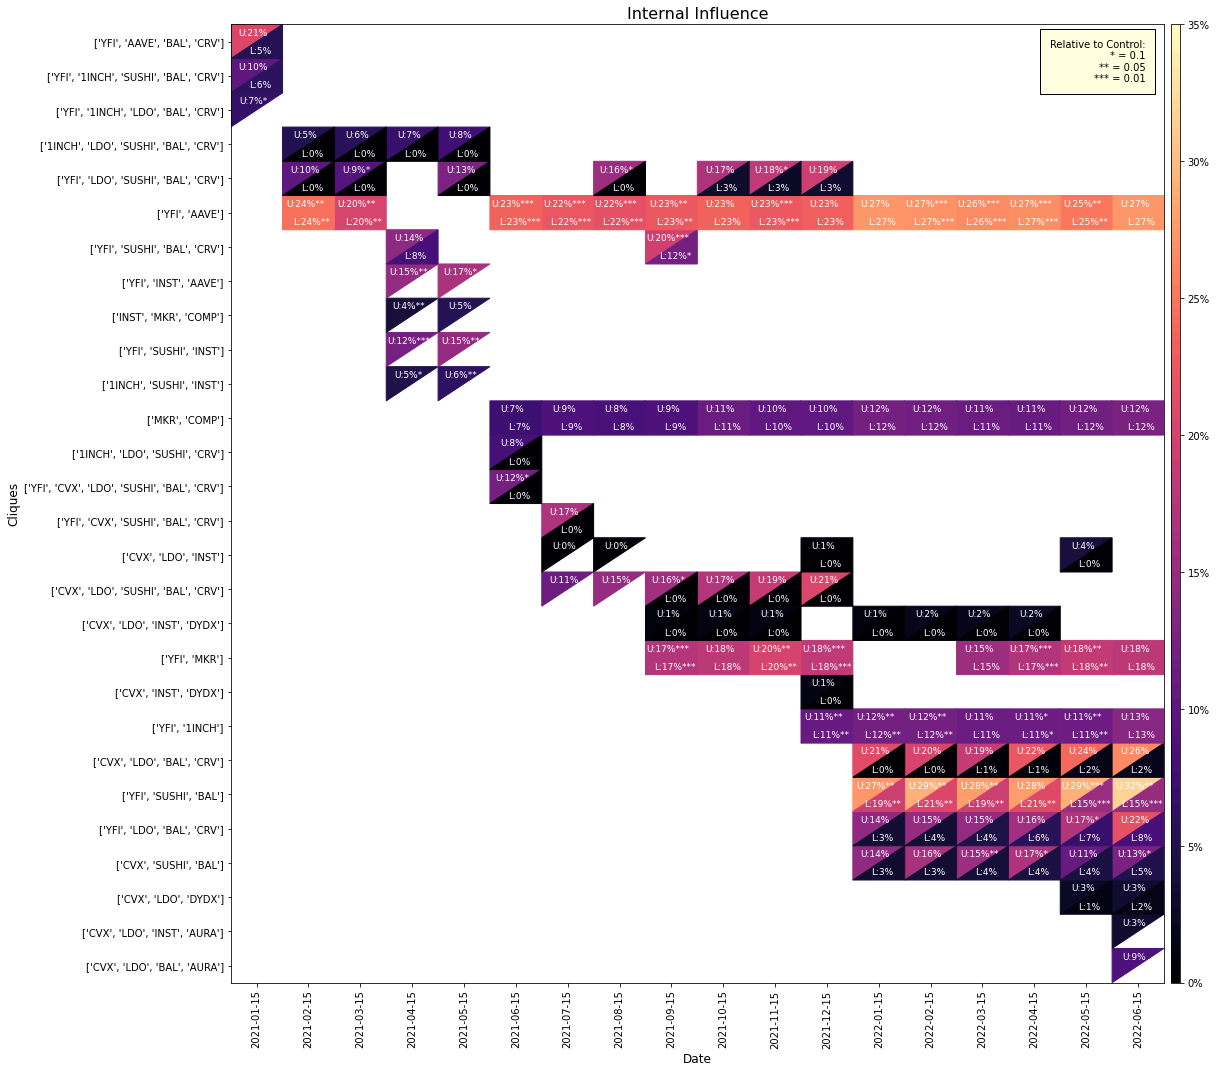

In [59]:
from matplotlib.cm import ScalarMappable
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.patches as patches


def plot_internal_influence_percentage(metric_dataframes, output_path="output/cliques/", save=True, show=True):

    # Define df
    df_u = metric_dataframes['upper_bound']['sample']['internal_influence'] * 100
    df_l = metric_dataframes['lower_bound']['sample']['internal_influence'] * 100

    df_pv_u = metric_dataframes['upper_bound']['pvalues']['internal_influence']
    df_pv_l = metric_dataframes['lower_bound']['pvalues']['internal_influence']
    
    # reindex
    df_index = metric_dataframes['upper_bound']['sample']['internal_influence'] * 100

        # Find the index of the first occurrence (value > 1) in each column (snapshot)
    first_occurrence_indices = (df_index.T > 0).idxmax()
        # Determine the minimum index (earliest occurrence) for each clique across all snapshots
    min_indices = first_occurrence_indices.groupby(first_occurrence_indices.index).min()
        # Sort the cliques based on their minimum indices to get the desired order
    cliques_order = min_indices.sort_values().index.tolist()

    # Reindex clique size to df
    df_u = df_u.reindex(cliques_order[::-1])
    df_pv_u =df_pv_u.reindex(cliques_order)

    fig, ax = plt.subplots(figsize=(17, 15))


    # Create colormap
    # cmap = mcolors.LinearSegmentedColormap.from_list("CMRmap", plt.get_cmap("CMRmap")(np.linspace(0, 1, 256)))
    cmap = plt.get_cmap("magma", lut=128)
    norm = mcolors.Normalize(vmin=0, vmax=35)

    cell_width = 1  # as we're not using imshow, we can stick with unit width and height
    cell_height = 1

    for clique in df_u.index:
        for date in df_u.columns:
            value_u = df_u.loc[clique, date]
            pval_u = df_pv_u.loc[clique, date]
            pval_u = pval_to_significance(pval_u)

            try: 
                value_l = df_l.loc[clique, date]
                pval_l = df_pv_l.loc[clique, date]
                pval_l = pval_to_significance(pval_l)
            except: 
                pval_l = ''
                value_l = np.nan

            x_pos = df_u.columns.get_loc(date) * cell_width
            y_pos = df_u.index.get_loc(clique) * cell_height

            # Plotting the triangles
            if not np.isnan(value_u):
                # Calculate triangle vertices for 90-degree rotation
                x1, y1 = x_pos, y_pos + cell_height
                x2, y2 = x_pos, y_pos
                x3, y3 = x_pos + cell_width, y_pos + cell_height

                # Draw triangle
                upper_triangle = patches.Polygon([(x1, y1), (x2, y2), (x3, y3)], closed=True, color=cmap(norm(value_u)), zorder=1)  
                ax.add_patch(upper_triangle)

                # Calculate centroid
                C_x = (x1 + x2 + x3) / 3 + 0.1 #last term manual adjustment 
                C_y = (y1 + y2 + y3) / 3 + 0.1 #last term manual adjustment

                # Place text at centroid
                ax.text(C_x, C_y, f'U:{round(value_u) if not np.isnan(value_u) else ""}%{pval_u}', ha='center', va='center', color='white', fontsize=9)


            if not np.isnan(value_l):
                # Calculate triangle vertices for 90-degree rotation
                x1, y1 = x_pos + cell_width, y_pos
                x2, y2 = x_pos + cell_width, y_pos + cell_height
                x3, y3 = x_pos, y_pos 

                # Draw triangle
                lower_triangle = patches.Polygon([(x1, y1), (x2, y2), (x3, y3)], closed=True, color=cmap(norm(value_l)), zorder=2)
                ax.add_patch(lower_triangle)

                # Calculate centroid
                C_x = (x1 + x2 + x3) / 3 - 0.1 #last term manual adjustment 
                C_y = (y1 + y2 + y3) / 3 - 0.1 # last term manual adjustment 

                # Place text at centroid
                ax.text(C_x, C_y, f'L:{round(value_l) if not np.isnan(value_l) else ""}%{pval_l}', ha='center', va='center', color='white', fontsize=9)
     
    #CBAR 
    ## Adding the colorbar for the colormap
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="1%", pad=0.1)  # '2%' determines the width of the colorbar
    cbar = plt.colorbar(ScalarMappable(norm=norm, cmap=cmap), cax=cax, orientation='vertical')
    ## add pct sign to tick vals of cbar 
    tick_vals = np.array(cbar.get_ticks()) 
    cbar.set_ticklabels([f'{round(val)}%' for val in tick_vals])
    
    # Significance box
    ### Add the custom box with significance information
    plt.text(0.98, 0.985, 'Relative to Control:\n* = 0.1\n** = 0.05\n*** = 0.01', 
         transform=ax.transAxes, fontsize=10, 
         verticalalignment='top', horizontalalignment='right',
         bbox=dict(facecolor='lightyellow', alpha=1, pad=10))

    
    ax.set_xlim(0, len(df_u.columns))
    ax.set_ylim(0, len(df_u.index))
    ax.set_xlabel('Date', size=12)
    ax.set_ylabel('Cliques', size=12)
    ax.set_title('Internal Influence', size=16)
    ax.set_xticks(np.arange(len(df_u.columns))+0.5)
    ax.set_xticklabels(df_u.columns, rotation=90, ha='center')
    ax.set_yticks(np.arange(len(df_u.index))+0.5)
    ax.set_yticklabels(df_u.index)
    plt.tight_layout()

    if save:
        plt.savefig(f"{output_path}/internal_influence_percentage.png", bbox_inches='tight')

    if show:
        plt.show()

# Assuming metric_dataframes is already defined somewhere in your code
plot_internal_influence_percentage(metric_dataframes, save=True, show=True)

### Fig: gini_internal_influence

In [ ]:
from matplotlib.cm import ScalarMappable
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.patches as patches


def plot_gini_external_influence_percentage(metric_dataframes, output_path="output/cliques/", save=True, show=True):

    # Define df
    df_u = metric_dataframes['upper_bound']['sample']['gini_internal_influence'] 
    df_l = metric_dataframes['lower_bound']['sample']['gini_internal_influence'] 

    df_pv_u = metric_dataframes['upper_bound']['pvalues']['gini_internal_influence']
    df_pv_l = metric_dataframes['lower_bound']['pvalues']['gini_internal_influence']
    
    # reindex
    df_index = metric_dataframes['upper_bound']['sample']['gini_internal_influence'] 

        # Find the index of the first occurrence (value > 1) in each column (snapshot)
    first_occurrence_indices = (df_index.T > 0).idxmax()
        # Determine the minimum index (earliest occurrence) for each clique across all snapshots
    min_indices = first_occurrence_indices.groupby(first_occurrence_indices.index).min()
        # Sort the cliques based on their minimum indices to get the desired order
    cliques_order = min_indices.sort_values().index.tolist()

    # Reindex clique size to df
    df_u = df_u.reindex(cliques_order[::-1])
    df_pv_u =df_pv_u.reindex(cliques_order)

    fig, ax = plt.subplots(figsize=(17, 15))


    # Create colormap
    # cmap = mcolors.LinearSegmentedColormap.from_list("CMRmap", plt.get_cmap("CMRmap")(np.linspace(0, 1, 256)))
    cmap = plt.get_cmap("magma", lut=128)
    norm = mcolors.Normalize(vmin=0, vmax=1)

    cell_width = 1  # as we're not using imshow, we can stick with unit width and height
    cell_height = 1

    for clique in df_u.index:
        for date in df_u.columns:
            value_u = df_u.loc[clique, date]
            pval_u = df_pv_u.loc[clique, date]
            pval_u = pval_to_significance(pval_u)

            try: 
                value_l = df_l.loc[clique, date]
                pval_l = df_pv_l.loc[clique, date]
                pval_l = pval_to_significance(pval_l)
            except: 
                pval_l = ''
                value_l = np.nan

            x_pos = df_u.columns.get_loc(date) * cell_width
            y_pos = df_u.index.get_loc(clique) * cell_height

            # Plotting the triangles
            if not np.isnan(value_u):
                # Calculate triangle vertices for 90-degree rotation
                x1, y1 = x_pos, y_pos + cell_height
                x2, y2 = x_pos, y_pos
                x3, y3 = x_pos + cell_width, y_pos + cell_height

                # Draw triangle
                upper_triangle = patches.Polygon([(x1, y1), (x2, y2), (x3, y3)], closed=True, color=cmap(norm(value_u)), zorder=1)  
                ax.add_patch(upper_triangle)

                # Calculate centroid
                C_x = (x1 + x2 + x3) / 3 + 0.1 #last term manual adjustment 
                C_y = (y1 + y2 + y3) / 3 + 0.1 #last term manual adjustment

                # Place text at centroid
                ax.text(C_x, C_y, f'U:{round(value_u, 2) if not np.isnan(value_u) else ""}%{pval_u}', ha='center', va='center', color='white', fontsize=9)


            if not np.isnan(value_l):
                # Calculate triangle vertices for 90-degree rotation
                x1, y1 = x_pos + cell_width, y_pos
                x2, y2 = x_pos + cell_width, y_pos + cell_height
                x3, y3 = x_pos, y_pos 

                # Draw triangle
                lower_triangle = patches.Polygon([(x1, y1), (x2, y2), (x3, y3)], closed=True, color=cmap(norm(value_l)), zorder=2)
                ax.add_patch(lower_triangle)

                # Calculate centroid
                C_x = (x1 + x2 + x3) / 3 - 0.1 #last term manual adjustment 
                C_y = (y1 + y2 + y3) / 3 - 0.1 # last term manual adjustment 

                # Place text at centroid
                ax.text(C_x, C_y, f'L:{round(value_l,2) if not np.isnan(value_l) else ""}%{pval_l}', ha='center', va='center', color='white', fontsize=9)
     
    #CBAR 
    ## Adding the colorbar for the colormap
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="1%", pad=0.1)  # '2%' determines the width of the colorbar
    cbar = plt.colorbar(ScalarMappable(norm=norm, cmap=cmap), cax=cax, orientation='vertical')
    ## add pct sign to tick vals of cbar 
    tick_vals = np.array(cbar.get_ticks()) 
    cbar.set_ticklabels([f'{round(val,2)}%' for val in tick_vals])
    
    # Significance box
    ### Add the custom box with significance information
    plt.text(0.98, 0.985, 'Relative to Control:\n* = 0.1\n** = 0.05\n*** = 0.01', 
         transform=ax.transAxes, fontsize=10, 
         verticalalignment='top', horizontalalignment='right',
         bbox=dict(facecolor='lightyellow', alpha=1, pad=10))

    
    ax.set_xlim(0, len(df_u.columns))
    ax.set_ylim(0, len(df_u.index))
    ax.set_xlabel('Date', size=12)
    ax.set_ylabel('Cliques', size=12)
    ax.set_title('Gini Coefficient of Internal Influence', size=16)
    ax.set_xticks(np.arange(len(df_u.columns))+0.5)
    ax.set_xticklabels(df_u.columns, rotation=90, ha='center')
    ax.set_yticks(np.arange(len(df_u.index))+0.5)
    ax.set_yticklabels(df_u.index)
    plt.tight_layout()

    if save:
        plt.savefig(f"{output_path}/gini_internal_influence_percentage.png", bbox_inches='tight')

    if show:
        plt.show()

# Assuming metric_dataframes is already defined somewhere in your code
plot_gini_external_influence_percentage(metric_dataframes, save=True, show=True)

/tmp/ipykernel_434051/1488974571.py:100: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.set_ticklabels([f'{round(val,2)}%' for val in tick_vals])


In [833]:
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt
# import matplotlib.colors as mcolors
# from os.path import join

# def plot_skew_internal_influence(metric_dataframes, method='lower_bound', group='sample', output_path="output/cliques/", save=True, show=True):
#     # Define df
#     df = metric_dataframes[method][group]['gini_internal_influence']
#     df_pv = metric_dataframes[method]['pvalues']['gini_internal_influence']

    
#     # common index 
#     df_index = metric_dataframes[method]['sample']['gini_internal_influence']

#         # Find the index of the first occurrence (value > 1) in each column (snapshot)
#     first_occurrence_indices = (df_index.T > 1).idxmax()
#         # Determine the minimum index (earliest occurrence) for each clique across all snapshots
#     min_indices = first_occurrence_indices.groupby(first_occurrence_indices.index).min()
#         # Sort the cliques based on their minimum indices to get the desired order
#     cliques_order = min_indices.sort_values().index.tolist()

#     # Reindex clique size to df
#     df = df.reindex(cliques_order)
#     df_pv = df_pv.reindex(cliques_order)


#     # Create a custom colormap with grayscale intensity based on metric values
#     cmap = plt.get_cmap('CMRmap')  # 'gray_r' reverses the grayscale colormap

#     # Create the chart with custom grayscale coloring
#     fig, ax = plt.subplots(figsize=(14, 10))
#     im = ax.imshow(df.values, cmap=cmap, aspect='auto', interpolation='none', vmin=0, vmax=1)  # Assuming values are in the range [0, 100]

#     # Set ticks and labels
#     ax.set_xticks(np.arange(len(df.columns)))
#     ax.set_yticks(np.arange(len(df.index)))
#     ax.set_xticklabels(df.columns, rotation='vertical')
#     ax.set_yticklabels(df.index, fontsize=10, va='center', linespacing=1.5)

#     # Annotate the chart with metric values, skipping 'NaN' values
#     for i in range(len(df.index)):
#         for j in range(len(df.columns)):
#             value = df.values[i, j]
#             pval = df_pv.values[i, j]
#             pval = pval_to_significance(pval)
#             if not np.isnan(value):
#                 text = ax.text(j, i, str(round(value, 1))+str(pval), ha='center', va='center', color='black', fontsize=8)

#     # Set labels and title
#     plt.xlabel('Timestamps', fontsize=12)
#     plt.ylabel('Cliques', fontsize=12)
#     plt.title(f'[{group.upper()}]: Skewness Internal Influence', fontsize=14)

#     # Show color bar indicating metric values with the grayscale colormap
#     cbar = ax.figure.colorbar(im, ax=ax)
#     cbar.ax.set_ylabel('Metric Value', rotation=-90, va="bottom")
    
#     # Add the custom box with significance information
#     plt.text(1.05, -0.1, 'Relative to Control:\n* = 0.1\n** = 0.05\n*** = 0.01', transform=ax.transAxes, fontsize=8, bbox=dict(facecolor='white', alpha=1))

#     # Adjust spacing for vertical axis labels
#     plt.tight_layout()

#     # Save the plot to the specified output path
#     if save:
#         plt.savefig(join(output_path, f'skew_internal_influence_{method}_{group}.png'))

#     # Display the plot if show is True
#     if show != True:
        
#         plt.close(fig)
    
#     else: 
        
#         plt.show() 

# # Example usage:
# plot_skew_internal_influence(metric_dataframes, method='upper_bound', group='sample', save=False, show=False)

### Fig: external_influence

In [837]:
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt
# import matplotlib.colors as mcolors
# from os.path import join

# def plot_external_influence(metric_dataframes, method='lower_bound', group='sample', output_path="output/cliques/", save=True, show=True):
#     # Define df
#     df = metric_dataframes[method][group]['external_influence'] * 100
#     df_pv = metric_dataframes[method]['pvalues']['external_influence']
    
#     # common index 
#     df_index = metric_dataframes[method]['sample']['external_influence'] * 100

#         # Find the index of the first occurrence (value > 1) in each column (snapshot)
#     first_occurrence_indices = (df_index.T > 1).idxmax()
#         # Determine the minimum index (earliest occurrence) for each clique across all snapshots
#     min_indices = first_occurrence_indices.groupby(first_occurrence_indices.index).min()
#         # Sort the cliques based on their minimum indices to get the desired order
#     cliques_order = min_indices.sort_values().index.tolist()

#     # Reindex clique size to df
#     df = df.reindex(cliques_order)
#     df_pv = df_pv.reindex(cliques_order)
    
#     # Create a custom colormap with grayscale intensity based on metric values
#     cmap = plt.get_cmap('CMRmap')  # 'gray_r' reverses the grayscale colormap

#     # Create the chart with custom grayscale coloring
#     fig, ax = plt.subplots(figsize=(14, 10))
#     im = ax.imshow(df.values, cmap=cmap, aspect='auto', interpolation='none', vmin=0, vmax=100)  # Assuming values are in the range [0, 100]

#     # Set ticks and labels
#     ax.set_xticks(np.arange(len(df.columns)))
#     ax.set_yticks(np.arange(len(df.index)))
#     ax.set_xticklabels(df.columns, rotation='vertical')
#     ax.set_yticklabels(df.index, fontsize=10, va='center', linespacing=1.5)
    
    
#     # Annotate the chart with metric values, skipping 'NaN' values
#     for i in range(len(df.index)):
#         for j in range(len(df.columns)):
#             value = df.values[i, j]
#             pval = df_pv.values[i, j]
#             pval = pval_to_significance(pval)
#             if not np.isnan(value):
#                 text = ax.text(j, i, str(round(value))+'%'+str(pval), ha='center', va='center', color='white', fontsize=8)

            
#     # Set labels and title
#     plt.xlabel('Timestamps', fontsize=12)
#     plt.ylabel('Cliques', fontsize=12)
#     plt.title(f'[{group.upper()}]: External Influence (%pct)', fontsize=14)

#     # Show color bar indicating metric values with the grayscale colormap
#     cbar = ax.figure.colorbar(im, ax=ax)
#     cbar.ax.set_ylabel('Metric Value', rotation=-90, va="bottom")
    
#     # Add the custom box with significance information
#     plt.text(1.05, -0.1, 'Relative to Control:\n* = 0.1\n** = 0.05\n*** = 0.01', transform=ax.transAxes, fontsize=8, bbox=dict(facecolor='white', alpha=1))


#     # Adjust spacing for vertical axis labels
#     plt.tight_layout()

#     # Save the plot to the specified output path
#     if save:
#         plt.savefig(join(output_path, f'external_influence_{method}_{group}.png'))

#     # Display the plot if show is True
#     if show != True:
        
#         plt.close(fig)
    
#     else: 
        
#         plt.show() 

# # Example usage:
# plot_external_influence(metric_dataframes, method='lower_bound', group='sample', save=False, show=False)

/tmp/ipykernel_434051/4105197659.py:100: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.set_ticklabels([f'{round(val)}%' for val in tick_vals])


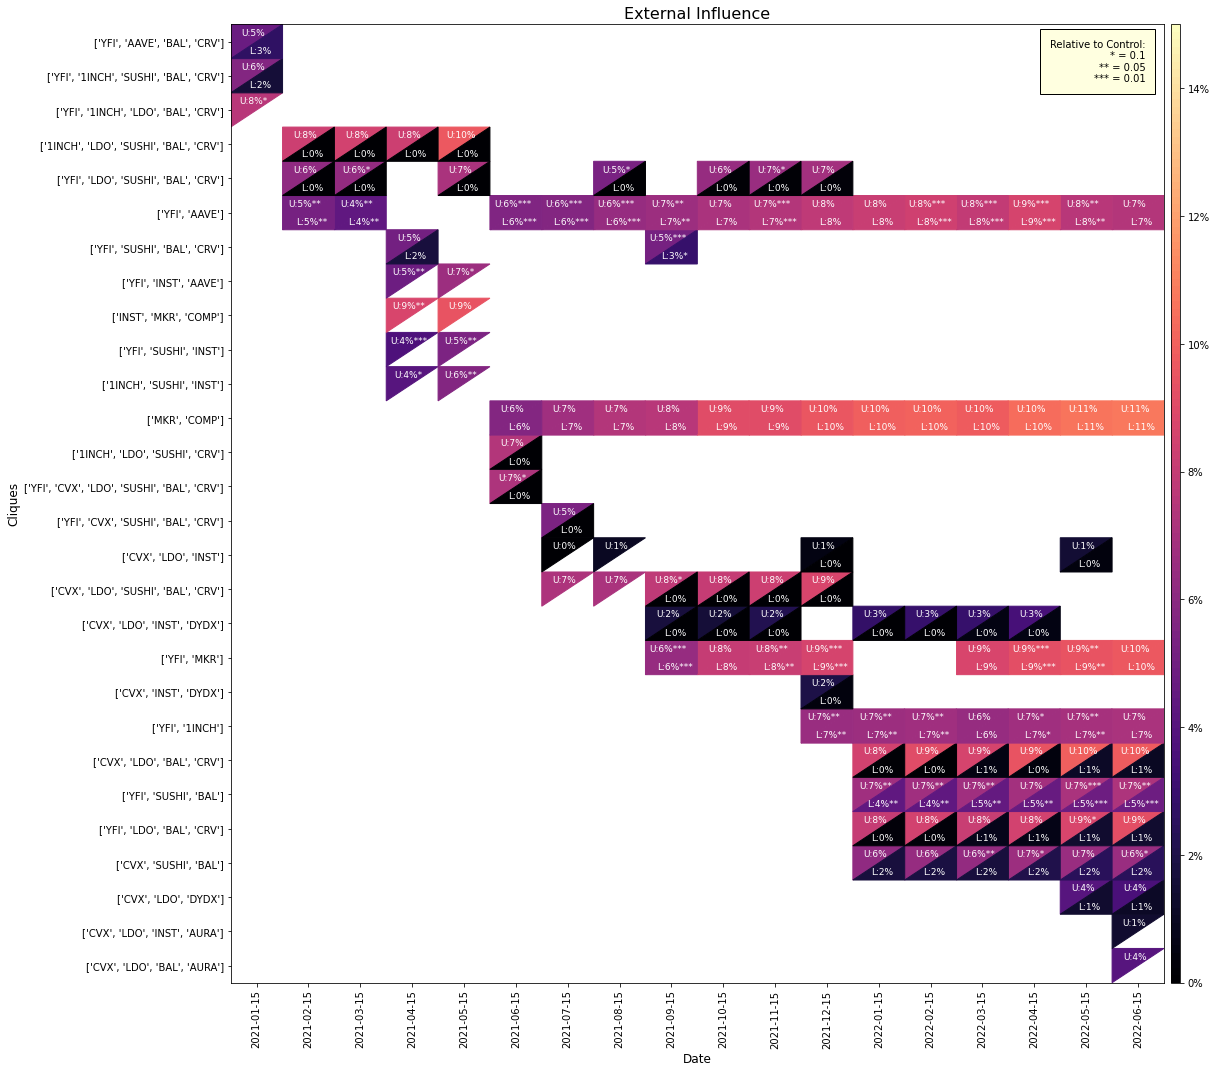

In [57]:
from matplotlib.cm import ScalarMappable
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.patches as patches


def plot_external_influence_percentage(metric_dataframes, output_path="output/cliques/", save=True, show=True):

    # Define df
    df_u = metric_dataframes['upper_bound']['sample']['external_influence'] * 100
    df_l = metric_dataframes['lower_bound']['sample']['external_influence'] * 100

    df_pv_u = metric_dataframes['upper_bound']['pvalues']['external_influence']
    df_pv_l = metric_dataframes['lower_bound']['pvalues']['external_influence']
    
    # reindex
    df_index = metric_dataframes['upper_bound']['sample']['external_influence'] * 100

        # Find the index of the first occurrence (value > 1) in each column (snapshot)
    first_occurrence_indices = (df_index.T > 0).idxmax()
        # Determine the minimum index (earliest occurrence) for each clique across all snapshots
    min_indices = first_occurrence_indices.groupby(first_occurrence_indices.index).min()
        # Sort the cliques based on their minimum indices to get the desired order
    cliques_order = min_indices.sort_values().index.tolist()

    # Reindex clique size to df
    df_u = df_u.reindex(cliques_order[::-1])
    df_pv_u =df_pv_u.reindex(cliques_order)

    fig, ax = plt.subplots(figsize=(17, 15))


    # Create colormap
    # cmap = mcolors.LinearSegmentedColormap.from_list("CMRmap", plt.get_cmap("CMRmap")(np.linspace(0, 1, 256)))
    cmap = plt.get_cmap("magma", lut=128)
    norm = mcolors.Normalize(vmin=0, vmax=15)

    cell_width = 1  # as we're not using imshow, we can stick with unit width and height
    cell_height = 1

    for clique in df_u.index:
        for date in df_u.columns:
            value_u = df_u.loc[clique, date]
            pval_u = df_pv_u.loc[clique, date]
            pval_u = pval_to_significance(pval_u)

            try: 
                value_l = df_l.loc[clique, date]
                pval_l = df_pv_l.loc[clique, date]
                pval_l = pval_to_significance(pval_l)
            except: 
                pval_l = ''
                value_l = np.nan

            x_pos = df_u.columns.get_loc(date) * cell_width
            y_pos = df_u.index.get_loc(clique) * cell_height

            # Plotting the triangles
            if not np.isnan(value_u):
                # Calculate triangle vertices for 90-degree rotation
                x1, y1 = x_pos, y_pos + cell_height
                x2, y2 = x_pos, y_pos
                x3, y3 = x_pos + cell_width, y_pos + cell_height

                # Draw triangle
                upper_triangle = patches.Polygon([(x1, y1), (x2, y2), (x3, y3)], closed=True, color=cmap(norm(value_u)), zorder=1)  
                ax.add_patch(upper_triangle)

                # Calculate centroid
                C_x = (x1 + x2 + x3) / 3 + 0.1 #last term manual adjustment 
                C_y = (y1 + y2 + y3) / 3 + 0.1 #last term manual adjustment

                # Place text at centroid
                ax.text(C_x, C_y, f'U:{round(value_u) if not np.isnan(value_u) else ""}%{pval_u}', ha='center', va='center', color='white', fontsize=9)


            if not np.isnan(value_l):
                # Calculate triangle vertices for 90-degree rotation
                x1, y1 = x_pos + cell_width, y_pos
                x2, y2 = x_pos + cell_width, y_pos + cell_height
                x3, y3 = x_pos, y_pos 

                # Draw triangle
                lower_triangle = patches.Polygon([(x1, y1), (x2, y2), (x3, y3)], closed=True, color=cmap(norm(value_l)), zorder=2)
                ax.add_patch(lower_triangle)

                # Calculate centroid
                C_x = (x1 + x2 + x3) / 3 - 0.1 #last term manual adjustment 
                C_y = (y1 + y2 + y3) / 3 - 0.1 # last term manual adjustment 

                # Place text at centroid
                ax.text(C_x, C_y, f'L:{round(value_l) if not np.isnan(value_l) else ""}%{pval_l}', ha='center', va='center', color='white', fontsize=9)
     
    #CBAR 
    ## Adding the colorbar for the colormap
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="1%", pad=0.1)  # '2%' determines the width of the colorbar
    cbar = plt.colorbar(ScalarMappable(norm=norm, cmap=cmap), cax=cax, orientation='vertical')
    ## add pct sign to tick vals of cbar 
    tick_vals = np.array(cbar.get_ticks()) 
    cbar.set_ticklabels([f'{round(val)}%' for val in tick_vals])
    
    # Significance box
    ### Add the custom box with significance information
    plt.text(0.98, 0.985, 'Relative to Control:\n* = 0.1\n** = 0.05\n*** = 0.01', 
         transform=ax.transAxes, fontsize=10, 
         verticalalignment='top', horizontalalignment='right',
         bbox=dict(facecolor='lightyellow', alpha=1, pad=10))

    
    ax.set_xlim(0, len(df_u.columns))
    ax.set_ylim(0, len(df_u.index))
    ax.set_xlabel('Date', size=12)
    ax.set_ylabel('Cliques', size=12)
    ax.set_title('External Influence', size=16)
    ax.set_xticks(np.arange(len(df_u.columns))+0.5)
    ax.set_xticklabels(df_u.columns, rotation=90, ha='center')
    ax.set_yticks(np.arange(len(df_u.index))+0.5)
    ax.set_yticklabels(df_u.index)
    plt.tight_layout()

    if save:
        plt.savefig(f"{output_path}/external_influence_percentage.png", bbox_inches='tight')

    if show:
        plt.show()

# Assuming metric_dataframes is already defined somewhere in your code
plot_external_influence_percentage(metric_dataframes, save=True, show=True)

### Fig: gini_external_influence

/tmp/ipykernel_434051/408835670.py:100: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.set_ticklabels([f'{round(val,2)}%' for val in tick_vals])


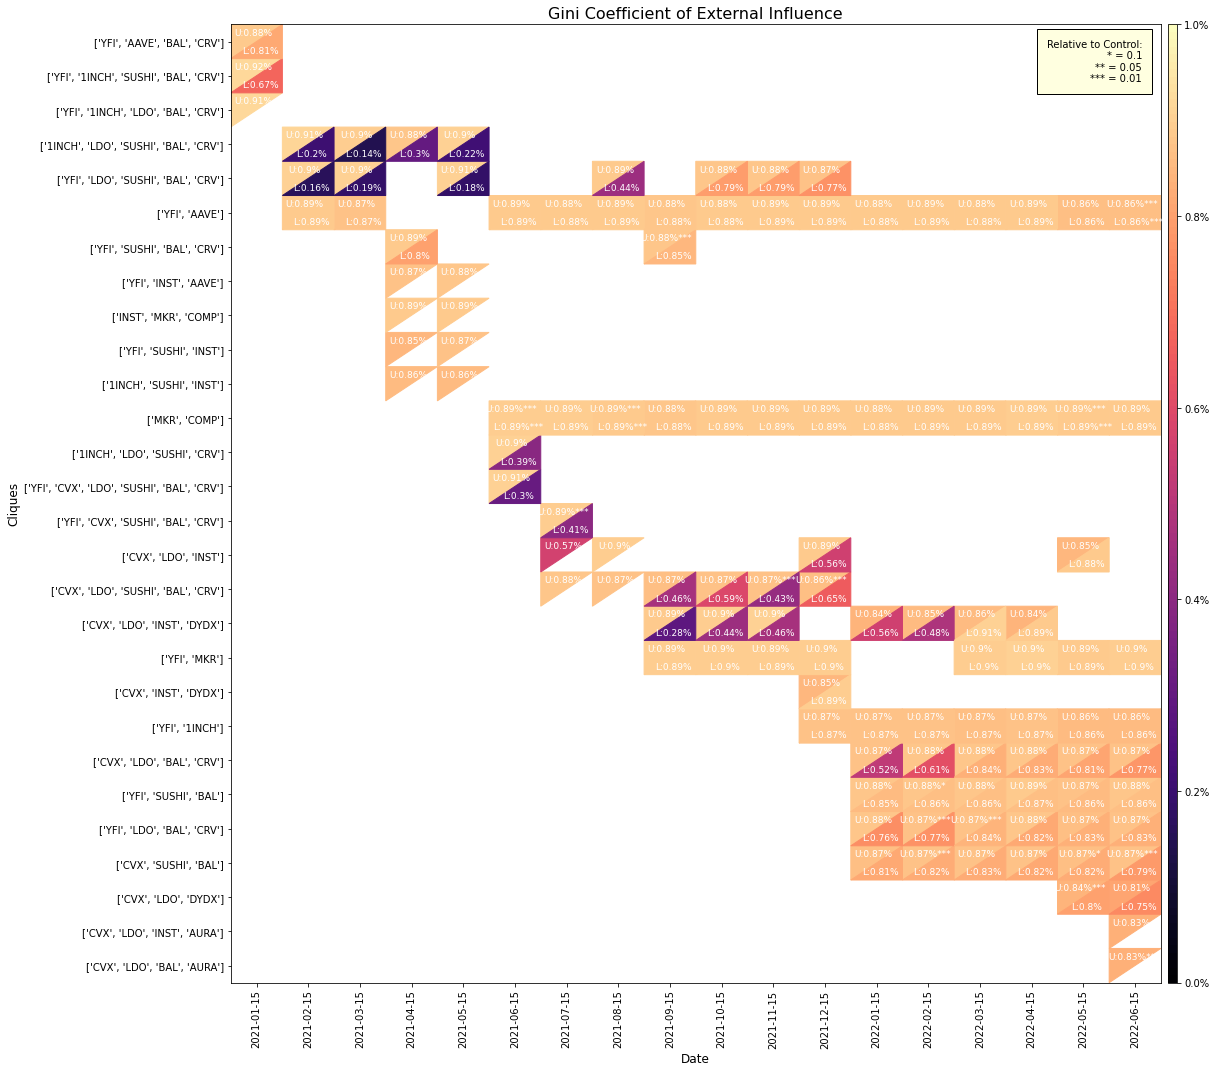

In [60]:
from matplotlib.cm import ScalarMappable
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.patches as patches


def plot_external_influence_percentage(metric_dataframes, output_path="output/cliques/", save=True, show=True):

    # Define df
    df_u = metric_dataframes['upper_bound']['sample']['gini_external_influence'] 
    df_l = metric_dataframes['lower_bound']['sample']['gini_external_influence'] 

    df_pv_u = metric_dataframes['upper_bound']['pvalues']['gini_external_influence']
    df_pv_l = metric_dataframes['lower_bound']['pvalues']['gini_external_influence']
    
    # reindex
    df_index = metric_dataframes['upper_bound']['sample']['gini_external_influence'] 

        # Find the index of the first occurrence (value > 1) in each column (snapshot)
    first_occurrence_indices = (df_index.T > 0).idxmax()
        # Determine the minimum index (earliest occurrence) for each clique across all snapshots
    min_indices = first_occurrence_indices.groupby(first_occurrence_indices.index).min()
        # Sort the cliques based on their minimum indices to get the desired order
    cliques_order = min_indices.sort_values().index.tolist()

    # Reindex clique size to df
    df_u = df_u.reindex(cliques_order[::-1])
    df_pv_u =df_pv_u.reindex(cliques_order)

    fig, ax = plt.subplots(figsize=(17, 15))


    # Create colormap
    # cmap = mcolors.LinearSegmentedColormap.from_list("CMRmap", plt.get_cmap("CMRmap")(np.linspace(0, 1, 256)))
    cmap = plt.get_cmap("magma", lut=128)
    norm = mcolors.Normalize(vmin=0, vmax=1)

    cell_width = 1  # as we're not using imshow, we can stick with unit width and height
    cell_height = 1

    for clique in df_u.index:
        for date in df_u.columns:
            value_u = df_u.loc[clique, date]
            pval_u = df_pv_u.loc[clique, date]
            pval_u = pval_to_significance(pval_u)

            try: 
                value_l = df_l.loc[clique, date]
                pval_l = df_pv_l.loc[clique, date]
                pval_l = pval_to_significance(pval_l)
            except: 
                pval_l = ''
                value_l = np.nan

            x_pos = df_u.columns.get_loc(date) * cell_width
            y_pos = df_u.index.get_loc(clique) * cell_height

            # Plotting the triangles
            if not np.isnan(value_u):
                # Calculate triangle vertices for 90-degree rotation
                x1, y1 = x_pos, y_pos + cell_height
                x2, y2 = x_pos, y_pos
                x3, y3 = x_pos + cell_width, y_pos + cell_height

                # Draw triangle
                upper_triangle = patches.Polygon([(x1, y1), (x2, y2), (x3, y3)], closed=True, color=cmap(norm(value_u)), zorder=1)  
                ax.add_patch(upper_triangle)

                # Calculate centroid
                C_x = (x1 + x2 + x3) / 3 + 0.1 #last term manual adjustment 
                C_y = (y1 + y2 + y3) / 3 + 0.1 #last term manual adjustment

                # Place text at centroid
                ax.text(C_x, C_y, f'U:{round(value_u,2) if not np.isnan(value_u) else ""}%{pval_u}', ha='center', va='center', color='white', fontsize=9)


            if not np.isnan(value_l):
                # Calculate triangle vertices for 90-degree rotation
                x1, y1 = x_pos + cell_width, y_pos
                x2, y2 = x_pos + cell_width, y_pos + cell_height
                x3, y3 = x_pos, y_pos 

                # Draw triangle
                lower_triangle = patches.Polygon([(x1, y1), (x2, y2), (x3, y3)], closed=True, color=cmap(norm(value_l)), zorder=2)
                ax.add_patch(lower_triangle)

                # Calculate centroid
                C_x = (x1 + x2 + x3) / 3 - 0.1 #last term manual adjustment 
                C_y = (y1 + y2 + y3) / 3 - 0.1 # last term manual adjustment 

                # Place text at centroid
                ax.text(C_x, C_y, f'L:{round(value_l,2) if not np.isnan(value_l) else ""}%{pval_l}', ha='center', va='center', color='white', fontsize=9)
     
    #CBAR 
    ## Adding the colorbar for the colormap
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="1%", pad=0.1)  # '2%' determines the width of the colorbar
    cbar = plt.colorbar(ScalarMappable(norm=norm, cmap=cmap), cax=cax, orientation='vertical')
    ## add pct sign to tick vals of cbar 
    tick_vals = np.array(cbar.get_ticks()) 
    cbar.set_ticklabels([f'{round(val,2)}%' for val in tick_vals])
    
    # Significance box
    ### Add the custom box with significance information
    plt.text(0.98, 0.985, 'Relative to Control:\n* = 0.1\n** = 0.05\n*** = 0.01', 
         transform=ax.transAxes, fontsize=10, 
         verticalalignment='top', horizontalalignment='right',
         bbox=dict(facecolor='lightyellow', alpha=1, pad=10))

    
    ax.set_xlim(0, len(df_u.columns))
    ax.set_ylim(0, len(df_u.index))
    ax.set_xlabel('Date', size=12)
    ax.set_ylabel('Cliques', size=12)
    ax.set_title('Gini Coefficient of External Influence', size=16)
    ax.set_xticks(np.arange(len(df_u.columns))+0.5)
    ax.set_xticklabels(df_u.columns, rotation=90, ha='center')
    ax.set_yticks(np.arange(len(df_u.index))+0.5)
    ax.set_yticklabels(df_u.index)
    plt.tight_layout()

    if save:
        plt.savefig(f"{output_path}/gini_external_influence_percentage.png", bbox_inches='tight')

    if show:
        plt.show()

# Assuming metric_dataframes is already defined somewhere in your code
plot_external_influence_percentage(metric_dataframes, save=True, show=True)

In [841]:
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt
# import matplotlib.colors as mcolors
# from os.path import join

# def plot_skew_external_influence(metric_dataframes, method='lower_bound', group='sample', output_path="output/cliques/", save=True, show=True):
#     # Define df
#     df = metric_dataframes[method][group]['gini_external_influence']
#     df_pv = metric_dataframes[method]['pvalues']['gini_external_influence']

    
#     # common index 
#     df_index = metric_dataframes[method]['sample']['gini_external_influence'] 
#     # Find the index of the first occurrence (value > 1) in each column (snapshot)
#     first_occurrence_indices = (df_index.T > 1).idxmax()
#     # Determine the minimum index (earliest occurrence) for each clique across all snapshots
#     min_indices = first_occurrence_indices.groupby(first_occurrence_indices.index).min()
#     # Sort the cliques based on their minimum indices to get the desired order
#     cliques_order = min_indices.sort_values().index.tolist()

#     # Reindex clique size to df
#     df = df.reindex(cliques_order)
#     df_pv = df_pv.reindex(cliques_order)

#     # Create a custom colormap with grayscale intensity based on metric values
#     cmap = plt.get_cmap('CMRmap')  # 'gray_r' reverses the grayscale colormap

#     # Create the chart with custom grayscale coloring
#     fig, ax = plt.subplots(figsize=(14, 10))
#     im = ax.imshow(df.values, cmap=cmap, aspect='auto', interpolation='none', vmin=0, vmax=1)  # Assuming values are in the range [0, 100]

#     # Set ticks and labels
#     ax.set_xticks(np.arange(len(df.columns)))
#     ax.set_yticks(np.arange(len(df.index)))
#     ax.set_xticklabels(df.columns, rotation='vertical')
#     ax.set_yticklabels(df.index, fontsize=10, va='center', linespacing=1.5)
    
#     # Annotate the chart with metric values, skipping 'NaN' values
#     for i in range(len(df.index)):
#         for j in range(len(df.columns)):
#             value = df.values[i, j]
#             pval = df_pv.values[i, j]
#             pval = pval_to_significance(pval)
#             if not np.isnan(value):
#                 text = ax.text(j, i, str(round(value, 2))+str(pval), ha='center', va='center', color='black', fontsize=8)

#     # Set labels and title
#     plt.xlabel('Timestamps', fontsize=12)
#     plt.ylabel('Cliques', fontsize=12)
#     plt.title(f'[{group.upper()}]: Gini External Influence', fontsize=14)

#     # Show color bar indicating metric values with the grayscale colormap
#     cbar = ax.figure.colorbar(im, ax=ax)
#     cbar.ax.set_ylabel('Metric Value', rotation=-90, va="bottom")
    
#     # Add the custom box with significance information
#     plt.text(1.05, -0.1, 'Relative to Control:\n* = 0.1\n** = 0.05\n*** = 0.01', transform=ax.transAxes, fontsize=8, bbox=dict(facecolor='white', alpha=1))


#     # Adjust spacing for vertical axis labels
#     plt.tight_layout()

#     # Save the plot to the specified output path
#     if save:
#         plt.savefig(join(output_path, f'gini_external_influence_{method}_{group}.png'))

#     # Display the plot if show is True
#     if show != True:
        
#         plt.close(fig)
    
#     else: 
        
#         plt.show() 


# # Example usage:
# plot_skew_external_influence(metric_dataframes, method='lower_bound', group='sample', save=False, show=False)


### Fig: wealth_clique

In [848]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from os.path import join

def plot_total_wealth_wallets(metric_dataframes, method='upper_bound', group='sample', output_path="output/cliques/", save=True, show=True):
    # Define df
    df = metric_dataframes[method][group]['wealth_clique']
    df_pv = metric_dataframes[method]['pvalues']['wealth_clique']

    # Common index calculation
    df_index = metric_dataframes[method]['sample']['wealth_clique']
    first_occurrence_indices = (df_index.T > 1).idxmax()
    min_indices = first_occurrence_indices.groupby(first_occurrence_indices.index).min()
    cliques_order = min_indices.sort_values().index.tolist()

    # Reindex clique size to df
    df = df.reindex(cliques_order)
    df = np.log10(df)
    df_pv = df_pv.reindex(cliques_order)

    # Create a custom colormap
    cmap = plt.get_cmap('CMRmap')  # You can change 'CMRmap' to any other colormap

    # Normalize the data for the colormap
    norm = mcolors.Normalize(vmin=np.nanmin(df.values) - 1, vmax=np.nanmax(df.values))

    # Create the colorful chart using the specified colormap
    fig, ax = plt.subplots(figsize=(14, 10))
    im = ax.imshow(df.values, cmap=cmap, norm=norm, aspect='auto', interpolation='none')

    # Set ticks and labels
    ax.set_xticks(np.arange(len(df.columns)))
    ax.set_yticks(np.arange(len(df.index)))
    ax.set_xticklabels(df.columns, rotation='vertical')
    ax.set_yticklabels(df.index, fontsize=10, va='center', linespacing=1.5)
    
    # Annotate the chart with metric values, skipping 'NaN' values
    for i in range(len(df.index)):
        for j in range(len(df.columns)):
            value = df.values[i, j]
            pval = df_pv.values[i, j]
            pval = pval_to_significance(pval)
            if not np.isnan(value):
                text = ax.text(j, i, str(round(value, 2))+str(pval), ha='center', va='center', color='black', fontsize=8)

    # Set labels and title
    plt.xlabel('Timestamps', fontsize=12)
    plt.ylabel('Cliques', fontsize=12)
    plt.title(f'[{group.upper()}]: Total Wealth Wallets (USD) - log10', fontsize=14)

    # Create a color bar indicating the values
    cbar = fig.colorbar(im, ax=ax)
    cbar.ax.set_ylabel('log10 Total Wealth', rotation=-90, va="bottom")
    
    # Add the custom box with significance information
    plt.text(1.05, -0.1, 'Relative to Control:\n* = 0.1\n** = 0.05\n*** = 0.01', transform=ax.transAxes, fontsize=8, bbox=dict(facecolor='white', alpha=1))


    # Adjust spacing for vertical axis labels
    plt.tight_layout()

    # Save the plot to the specified output path
    if save:
        plt.savefig(join(output_path, f'total_wealth_wallets_{group}.png'))

    # Display the plot or close it based on the show parameter
    if show != True:
        plt.close(fig)
    else:
        plt.show()

# Example usage:
plot_total_wealth_wallets(metric_dataframes, method='upper_bound', group='sample', save=False, show=False)


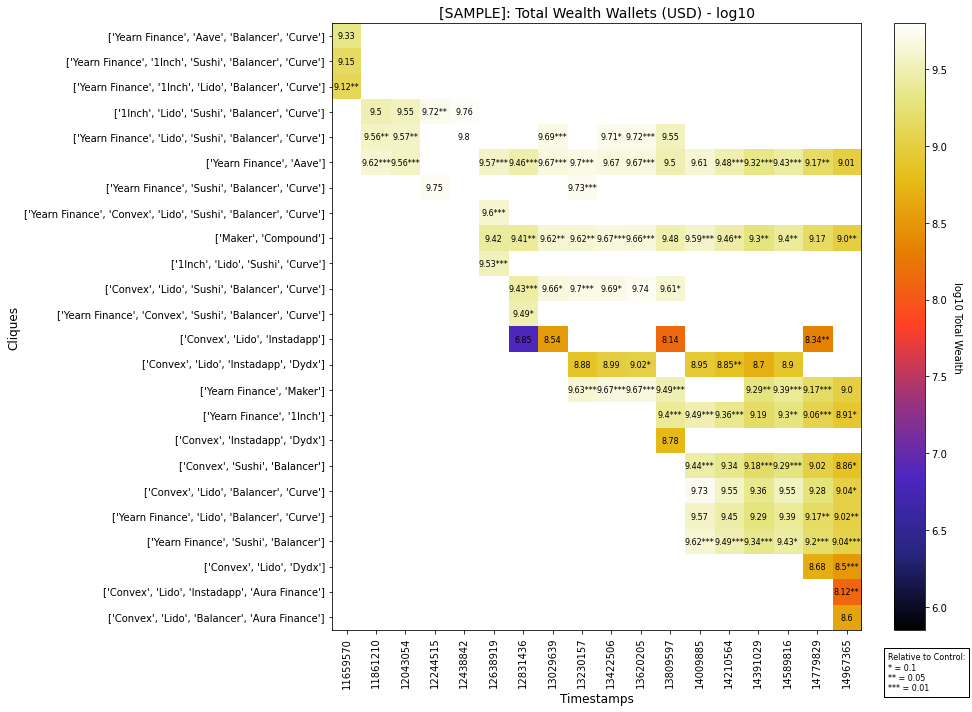

In [849]:
plot_total_wealth_wallets(metric_dataframes, method='upper_bound', group='sample', save=False, show=True)
# plot_total_wealth_wallets(metric_dataframes, method='upper_bound', group='control', save=False, show=True)


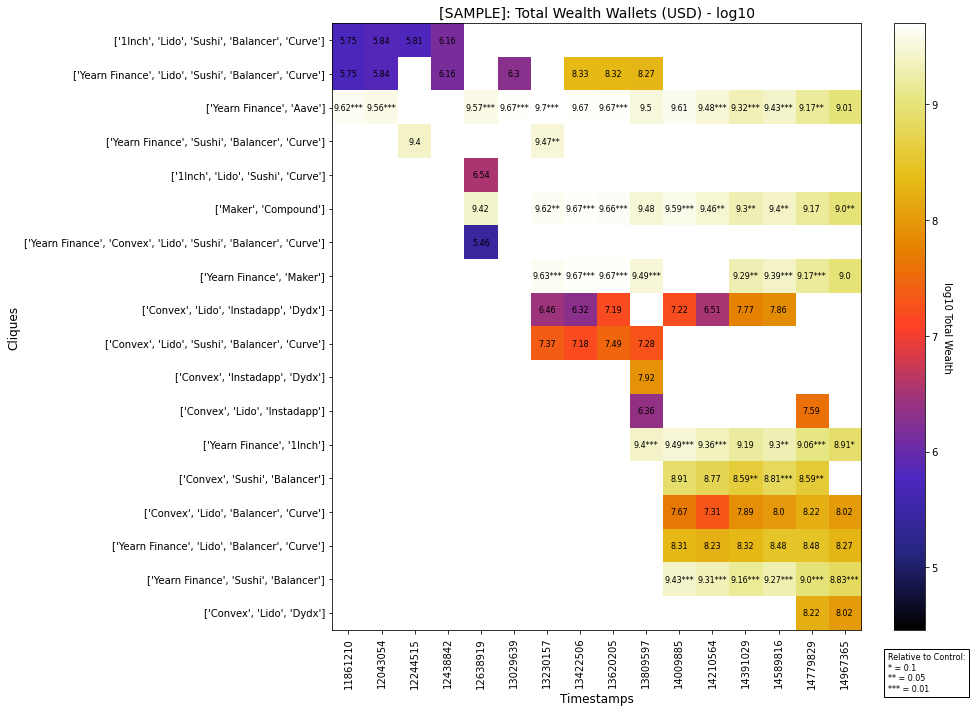

In [850]:
plot_total_wealth_wallets(metric_dataframes, method='lower_bound', group='sample', save=False, show=True)
# plot_total_wealth_wallets(metric_dataframes, method='lower_bound', group='control', save=False, show=True)


### Fig: gini_wealth_clique

In [852]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from os.path import join

def plot_skewness_wealth_clique(metric_dataframes, method='upper_bound', group='sample', output_path="output/cliques/", save=True, show=True):
    # Define df
    df = metric_dataframes[method][group]['gini_wealth_clique']
    df_pv = metric_dataframes[method]['pvalues']['wealth_clique']


    # Common index calculation
    df_index = metric_dataframes[method]['sample']['gini_wealth_clique']
    first_occurrence_indices = (df_index.T > 1).idxmax()
    min_indices = first_occurrence_indices.groupby(first_occurrence_indices.index).min()
    cliques_order = min_indices.sort_values().index.tolist()

    # Reindex clique size to df
    df = df.reindex(cliques_order)
    df_pv = df_pv.reindex(cliques_order)

    # Create a custom colormap
    cmap = plt.get_cmap('CMRmap')  # You can change 'CMRmap' to any other colormap

    # Normalize the data for the colormap
    norm = mcolors.Normalize(vmin=np.nanmin(df.values) - 1, vmax=np.nanmax(df.values))

    # Create the colorful chart using the specified colormap
    fig, ax = plt.subplots(figsize=(14, 10))
    im = ax.imshow(df.values, cmap=cmap, norm=norm, aspect='auto', interpolation='none')

    # Set ticks and labels
    ax.set_xticks(np.arange(len(df.columns)))
    ax.set_yticks(np.arange(len(df.index)))
    ax.set_xticklabels(df.columns, rotation='vertical')
    ax.set_yticklabels(df.index, fontsize=10, va='center', linespacing=1.5)
    
    # Annotate the chart with metric values, skipping 'NaN' values
    for i in range(len(df.index)):
        for j in range(len(df.columns)):
            value = df.values[i, j]
            pval = df_pv.values[i, j]
            pval = pval_to_significance(pval)
            if not np.isnan(value):
                text = ax.text(j, i, str(round(value, 2))+str(pval), ha='center', va='center', color='black', fontsize=8)

    # Set labels and title
    plt.xlabel('Timestamps', fontsize=12)
    plt.ylabel('Cliques', fontsize=12)
    plt.title(f'[{group.upper()}]: Gini of Wealth Clique Member Wallets', fontsize=14)

    # Create a color bar indicating the values
    cbar = fig.colorbar(im, ax=ax)
    
    # Add the custom box with significance information
    plt.text(1.05, -0.1, 'Relative to Control:\n* = 0.1\n** = 0.05\n*** = 0.01', transform=ax.transAxes, fontsize=8, bbox=dict(facecolor='white', alpha=1))

    # Adjust spacing for vertical axis labels
    plt.tight_layout()

    # Save the plot to the specified output path
    if save:
        plt.savefig(join(output_path, f'gini_wealth_clique_{method}_{group}.png'))

    # Display the plot or close it based on the show parameter
    if show != True:
        plt.close(fig)
    else:
        plt.show()

# Example usage:
plot_skewness_wealth_clique(metric_dataframes, method='upper_bound', group='sample', save=False, show=False)


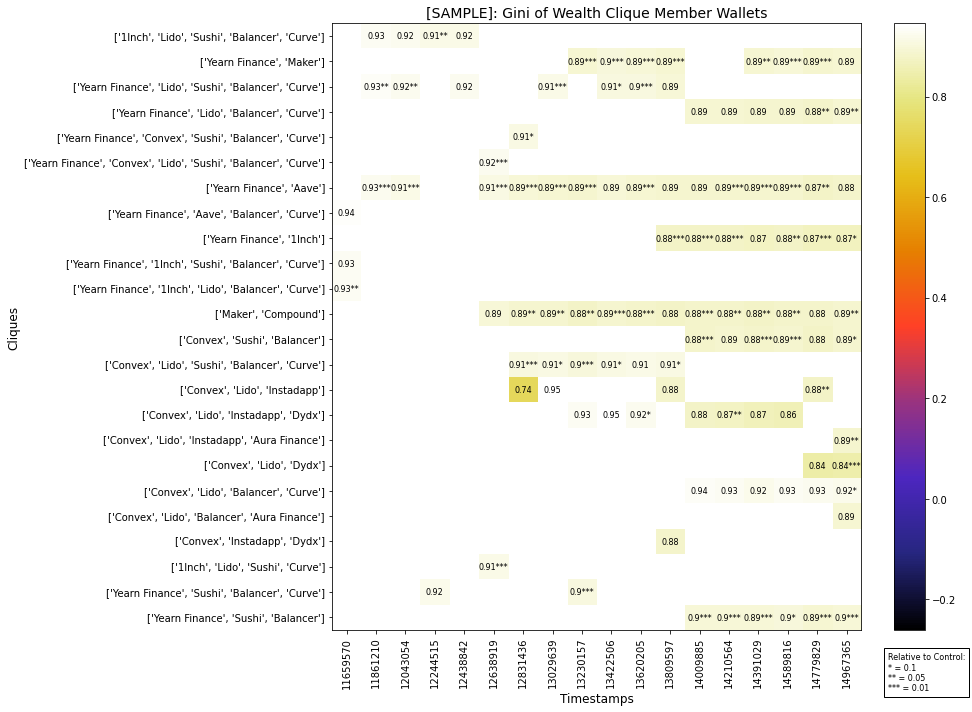

In [853]:
plot_skewness_wealth_clique(metric_dataframes, method='upper_bound', group='sample', save=False, show=True)
# plot_skewness_wealth_clique(metric_dataframes, method='upper_bound', group='control', save=False, show=True)


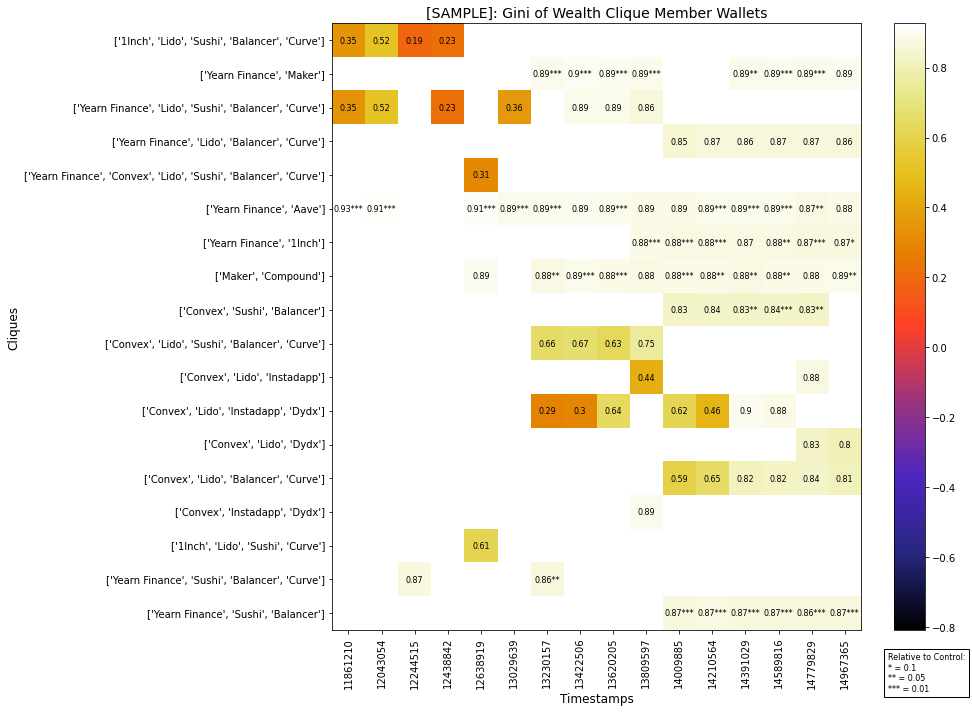

In [854]:
plot_skewness_wealth_clique(metric_dataframes, method='lower_bound', group='sample', save=False, show=True)
# plot_skewness_wealth_clique(metric_dataframes, method='lower_bound', group='control', save=False, show=True)


### Fig: median_wealth_level_clique

In [857]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from os.path import join

def plot_median_wealth_wallets(metric_dataframes, method='upper_bound', group='sample', output_path="output/cliques/", save=True, show=True):
    # Define df
    df = metric_dataframes[method][group]['median_wealth_level_clique']
    df_pv = metric_dataframes[method]['pvalues']['median_wealth_level_clique']


    # Common index calculation
    df_index = metric_dataframes[method]['sample']['median_wealth_level_clique']
    first_occurrence_indices = (df_index.T > 1).idxmax()
    min_indices = first_occurrence_indices.groupby(first_occurrence_indices.index).min()
    cliques_order = min_indices.sort_values().index.tolist()

    # Reindex clique size to df
    df = df.reindex(cliques_order)
    df = np.log10(df)
    df_pv = df_pv.reindex(cliques_order)


    # Create a custom colormap
    cmap = plt.get_cmap('CMRmap')  # You can change 'CMRmap' to any other colormap

    # Normalize the data for the colormap
    norm = mcolors.Normalize(vmin=np.nanmin(df.values) - 1, vmax=np.nanmax(df.values))

    # Create the colorful chart using the specified colormap
    fig, ax = plt.subplots(figsize=(14, 10))
    im = ax.imshow(df.values, cmap=cmap, norm=norm, aspect='auto', interpolation='none')

    # Set ticks and labels
    ax.set_xticks(np.arange(len(df.columns)))
    ax.set_yticks(np.arange(len(df.index)))
    ax.set_xticklabels(df.columns, rotation='vertical')
    ax.set_yticklabels(df.index, fontsize=10, va='center', linespacing=1.5)
    
    # Annotate the chart with metric values, skipping 'NaN' values
    for i in range(len(df.index)):
        for j in range(len(df.columns)):
            value = df.values[i, j]
            pval = df_pv.values[i, j]
            pval = pval_to_significance(pval)
            if not np.isnan(value):
                text = ax.text(j, i, str(round(value, 2))+str(pval), ha='center', va='center', color='black', fontsize=8)

    # Set labels and title
    plt.xlabel('Timestamps', fontsize=12)
    plt.ylabel('Cliques', fontsize=12)
    plt.title(f'[{group.upper()}]: Median Wealth Wallets (USD) - log10', fontsize=14)

    # Create a color bar indicating the values
    cbar = fig.colorbar(im, ax=ax)
    cbar.ax.set_ylabel('log10 Median Wealth', rotation=-90, va="bottom")
    
    # Add the custom box with significance information
    plt.text(1.05, -0.1, 'Relative to Control:\n* = 0.1\n** = 0.05\n*** = 0.01', transform=ax.transAxes, fontsize=8, bbox=dict(facecolor='white', alpha=1))


    # Adjust spacing for vertical axis labels
    plt.tight_layout()

    # Save the plot to the specified output path
    if save:
        plt.savefig(join(output_path, f'total_wealth_wallets_{method}_{group}.png'))

    # Display the plot or close it based on the show parameter
    if show != True:
        plt.close(fig)
    else:
        plt.show()

# Example usage:
plot_median_wealth_wallets(metric_dataframes, method='upper_bound', group='sample', save=False, show=False)


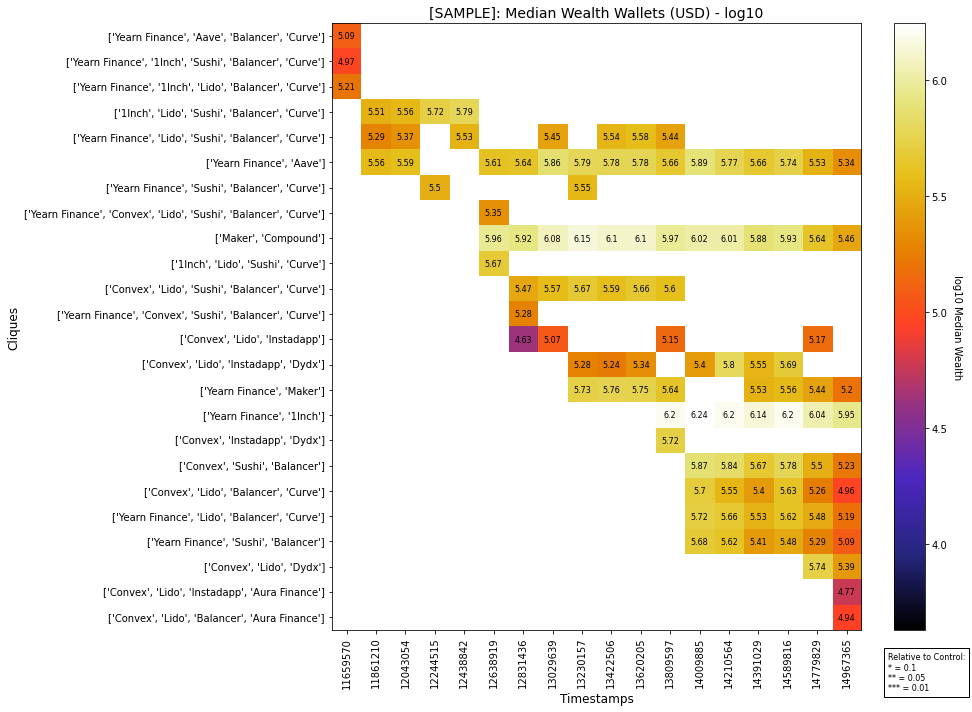

In [858]:
plot_median_wealth_wallets(metric_dataframes, method='upper_bound', group='sample', save=False, show=True)
# plot_median_wealth_wallets(metric_dataframes, method='upper_bound', group='control', save=False, show=True)

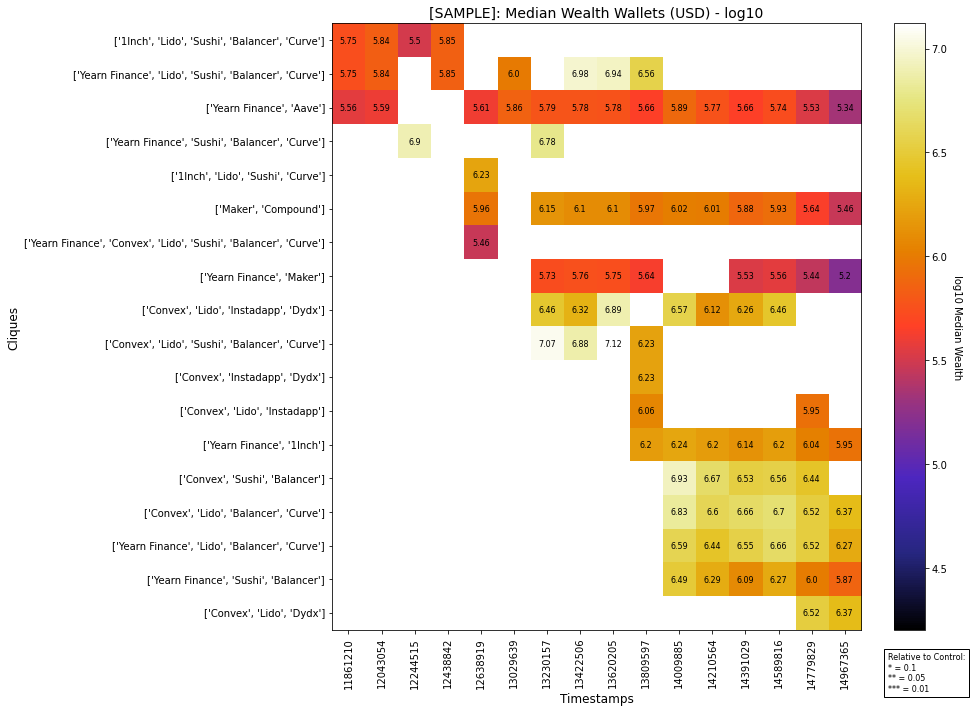

In [859]:
plot_median_wealth_wallets(metric_dataframes, method='lower_bound', group='sample', save=False, show=True)
# plot_median_wealth_wallets(metric_dataframes, method='lower_bound', group='control', save=False, show=True)

### Fig: median_no_assets_clique


In [867]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from os.path import join

def plot_median_no_assets_clique(metric_dataframes, method='upper_bound', group='sample', output_path="output/cliques/", save=True, show=True):
    # Define df
    df = metric_dataframes[method][group]['median_no_assets_clique']
    df_pv = metric_dataframes[method]['pvalues']['median_no_assets_clique']


    # Common index calculation
    df_index = metric_dataframes[method]['sample']['median_no_assets_clique']
    first_occurrence_indices = (df_index.T > 1).idxmax()
    min_indices = first_occurrence_indices.groupby(first_occurrence_indices.index).min()
    cliques_order = min_indices.sort_values().index.tolist()

    # Reindex clique size to df
    df = df.reindex(cliques_order)
    df_pv = df_pv.reindex(cliques_order)

    # Create a custom colormap
    cmap = plt.get_cmap('CMRmap')  # You can change 'CMRmap' to any other colormap

    # Normalize the data for the colormap
    norm = mcolors.Normalize(vmin=np.nanmin(df.values) - 1, vmax=np.nanmax(df.values))

    # Create the colorful chart using the specified colormap
    fig, ax = plt.subplots(figsize=(14, 10))
    im = ax.imshow(df.values, cmap=cmap, norm=norm, aspect='auto', interpolation='none')

    # Set ticks and labels
    ax.set_xticks(np.arange(len(df.columns)))
    ax.set_yticks(np.arange(len(df.index)))
    ax.set_xticklabels(df.columns, rotation='vertical')
    ax.set_yticklabels(df.index, fontsize=10, va='center', linespacing=1.5)
    
    # Annotate the chart with metric values, skipping 'NaN' values
    for i in range(len(df.index)):
        for j in range(len(df.columns)):
            value = df.values[i, j]
            pval = df_pv.values[i, j]
            pval = pval_to_significance(pval)
            if not np.isnan(value):
                text = ax.text(j, i, str(round(value, 2))+str(pval), ha='center', va='center', color='black', fontsize=8)

    # Set labels and title
    plt.xlabel('Timestamps', fontsize=12)
    plt.ylabel('Cliques', fontsize=12)
    plt.title(f'[{group.upper()}]: Median Assets Held', fontsize=14)

    # Create a color bar indicating the values
    cbar = fig.colorbar(im, ax=ax)
    cbar.ax.set_ylabel('Median Assets Held', rotation=-90, va="bottom")
    
    # Add the custom box with significance information
    plt.text(1.05, -0.1, 'Relative to Control:\n* = 0.1\n** = 0.05\n*** = 0.01', transform=ax.transAxes, fontsize=8, bbox=dict(facecolor='white', alpha=1))


    # Adjust spacing for vertical axis labels
    plt.tight_layout()

    # Save the plot to the specified output path
    if save:
        plt.savefig(join(output_path, f'median_number_assets_wallets_{method}_{group}.png'))

    # Display the plot or close it based on the show parameter
    if show != True:
        plt.close(fig)
    else:
        plt.show()

# Example usage:
plot_median_no_assets_clique(metric_dataframes, method='upper_bound', group='sample', save=False, show=False)


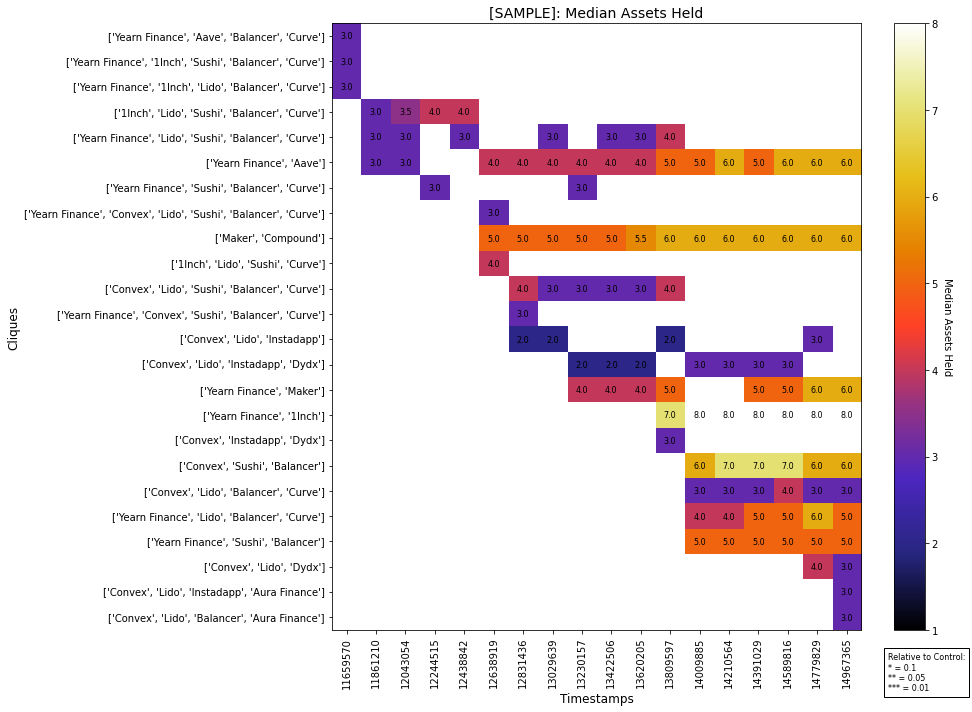

In [868]:
plot_median_no_assets_clique(metric_dataframes, method='upper_bound', group='sample', save=False, show=True)
# plot_median_no_assets_clique(metric_dataframes, method='upper_bound', group='control', save=False, show=True)

## check what is wrong here ... 

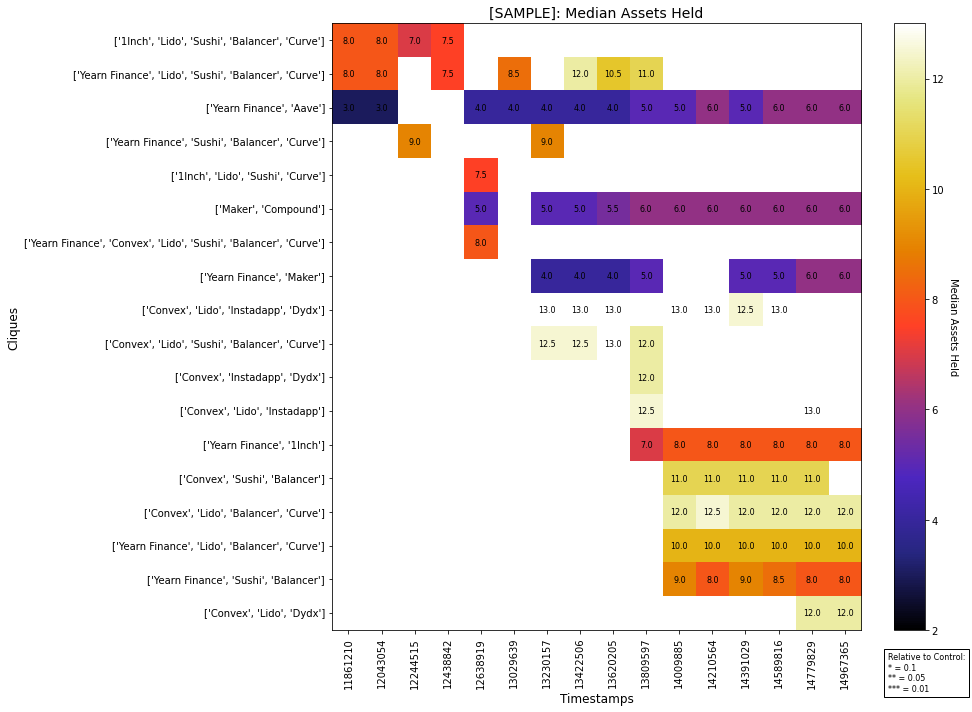

In [869]:
plot_median_no_assets_clique(metric_dataframes, method='lower_bound', group='sample', save=False, show=True)
# plot_median_no_assets_clique(metric_dataframes, method='lower_bound', group='control', save=False, show=True)

## check what is wrong here ... 

### Fig: max_influence_label

In [871]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from os.path import join

def plot_max_influence_label(metric_dataframes, method='upper_bound', group='sample', output_path="output/cliques/", save=True, show=True):
    # Define df
    df = metric_dataframes[method][group]['max_influence_label']
    df_pv = metric_dataframes[method]['pvalues']['max_influence_label']
    
    # Common index calculation
    df_index = metric_dataframes[method]['sample']['size_clique']
    first_occurrence_indices = (df_index.T > 0).idxmax()
    min_indices = first_occurrence_indices.groupby(first_occurrence_indices.index).min()
    cliques_order = min_indices.sort_values().index.tolist()
    
    df = df.reindex(cliques_order)
    df_pv = df_pv.reindex(cliques_order)
    # Flatten multi-level columns (if they exist)
    # df.columns = ['_'.join(map(str, col)).strip() for col in df.columns.values]

    # Extract the labels into separate DataFrames
    df_labels_raw = df.applymap(lambda x: x[0] if isinstance(x, tuple) else np.nan)
    df_labels = df_labels_raw.replace(token_lookup)  # Ensure token_lookup is defined and correct

    # Extract values into separate DataFrames
    df_values = df.applymap(lambda x: x[1] if isinstance(x, tuple) else np.nan)

    # Get unique labels
    unique_labels = df_labels.stack().unique()

    # Create a colormap with a unique color for each label
    colors = plt.cm.tab20(np.linspace(0, 1, len(unique_labels)))
    colormap = mcolors.ListedColormap(colors)

    # Create a figure and axis
    fig, ax = plt.subplots(figsize=(14, 10))

    # Plot colored cells based on labels
    cax = ax.imshow(df_labels.replace(dict(zip(unique_labels, range(len(unique_labels))))), cmap=colormap,
                    aspect='auto', interpolation='none')

    # Set ticks and labels
    ax.set_xticks(np.arange(len(df_labels.columns)))
    ax.set_yticks(np.arange(len(df_labels.index)))
    ax.set_xticklabels(df_labels.columns, rotation='vertical')
    ax.set_yticklabels(df_labels.index, fontsize=10, va='center', linespacing=1.5)

    # Annotate the chart with metric values, using the values from df_values
    for i in range(len(df_labels.index)):
        for j in range(len(df_labels.columns)):
            label = df_labels.iloc[i, j]  # Use .iloc for direct indexing
            value = df_values.iloc[i, j]  # Use .iloc for direct indexing
            pval = df_pv.values[i, j]
            pval = pval_to_significance(pval)
            if pd.notna(value):  # Check for non-NaN values
                text = ax.text(j, i, f'{value*100:.1f}{pval}', ha='center', va='center', color='black', fontsize=8)

    # Set labels and title
    plt.xlabel('Timestamps', fontsize=12)
    plt.ylabel('Cliques', fontsize=12)
    plt.title('Max Influence Value by User Group %pct', fontsize=14)

    # Create a color bar indicating labels
    cbar = fig.colorbar(cax, ticks=range(len(unique_labels)))
    cbar.ax.set_yticklabels(unique_labels)
    
    # Add the custom box with significance information
    plt.text(1.05, -0.1, 'Relative to Control:\n* = 0.1\n** = 0.05\n*** = 0.01', transform=ax.transAxes, fontsize=8, bbox=dict(facecolor='white', alpha=1))

    # Adjust spacing for vertical axis labels
    plt.tight_layout()

    # Save the plot to the specified output path
    if save:
        plt.savefig(join(output_path, 'max_influence_label.png'))

    # Display the plot or close it based on the show parameter
    if show != True:
        plt.close(fig)
    else:
        plt.show()

# Example usage:
plot_max_influence_label(metric_dataframes, method='upper_bound', group='sample', output_path="output/cliques/", save=True, show=False)

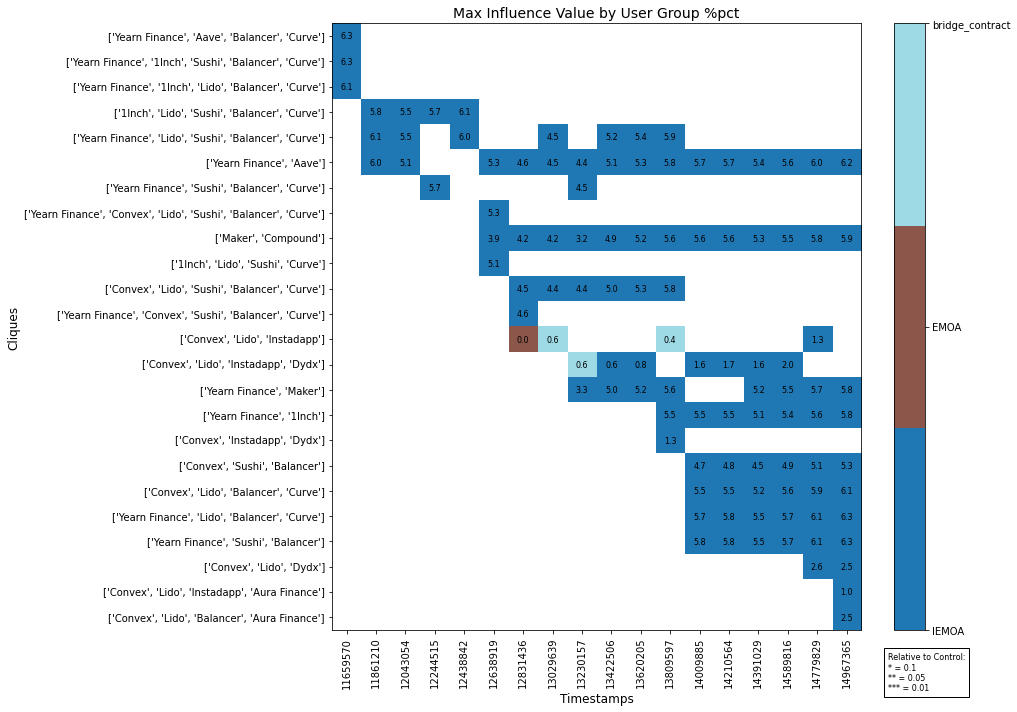

In [872]:
plot_max_influence_label(metric_dataframes, method='upper_bound', group='sample', output_path="output/cliques/", save=True, show=True)
# plot_max_influence_label(metric_dataframes, method='upper_bound', group='control', output_path="output/cliques/", save=True, show=True)

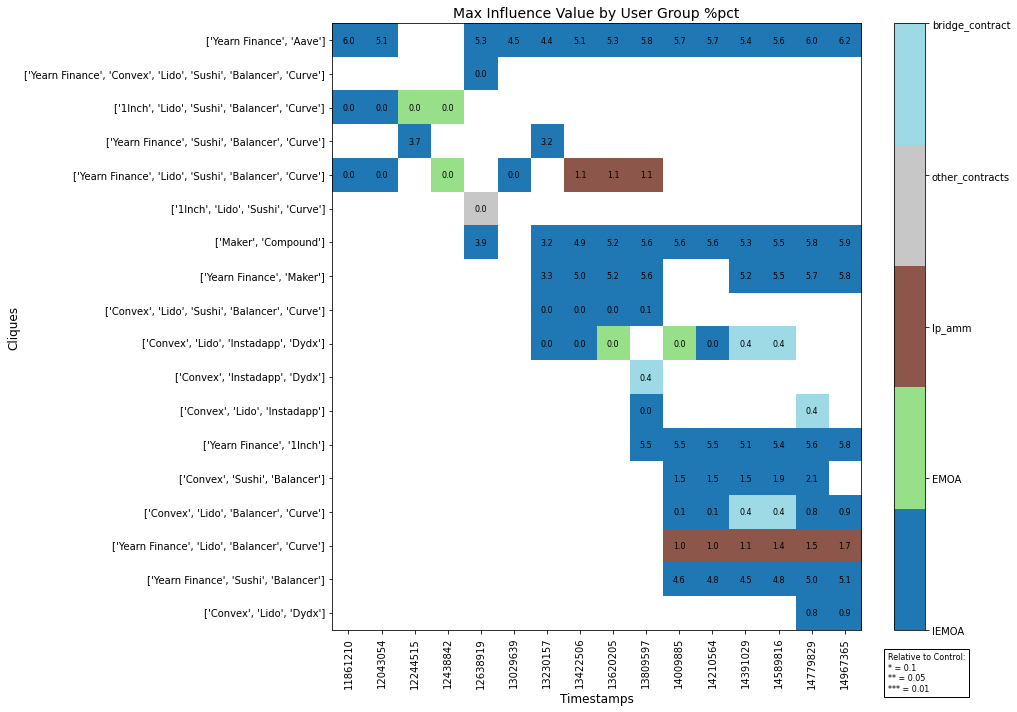

In [873]:
plot_max_influence_label(metric_dataframes, method='lower_bound', group='sample', output_path="output/cliques/", save=True, show=True)
# plot_max_influence_label(metric_dataframes, method='lower_bound', group='control', output_path="output/cliques/", save=True, show=True)